This script first parse clusters that belong to the vascular class into excitable cells and else, then fetch genes specific to each class (trinaries > 0.9 for at least one cluster in that class, and with trinaries less than 0.1 in all other clusters) and their dN/dS. Statistics and Visualizaitons follows. Code adapted from mouse.cluster_descriptive_stats.zeisel_2018.ipynb

In [337]:
import numpy as np
import pandas as pd
import loompy
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['png'] # can be svg if needed
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['figure.dpi']= 300
import seaborn as sns
import scipy.stats as stats
import pingouin as pg
import matplotlib
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from copy import deepcopy
import heapq
import os
from openpyxl import load_workbook
from sklearn import linear_model
from scipy import stats
from itertools import combinations
import glob

In [363]:
# statistical significance between two independent correlation coefficients
# implemented from https://github.com/psinger/CorrelationStats/blob/master/corrstats.py
# by Philipp Singer
# Fisher method (Z-transformation)
# Use of this method for Spearman's Rho justified by Myers et Sirois 2006
# https://onlinelibrary.wiley.com/doi/10.1002/0471667196.ess5050.pub2
def independent_corr(r1, r2, n1, n2, twotailed=True):
    z1 = 0.5 * np.log((1 + r1)/(1 - r1))
    z2 = 0.5 * np.log((1 + r2)/(1 - r2))
    se_diff_r = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))
    diff = z1 - z2
    z = abs(diff / se_diff_r)
    p = (1 - stats.norm.cdf(z))
    if twotailed:
        p *= 2
    return z, p

In [304]:
color_NEAMO_dict = {
    'endothelia':'tab:blue',
    'astrocyte':'tab:olive',
    'neuron':'tab:red',
    'microglia':'tab:orange',
    'oligodendrocyte':'tab:cyan',
    'other':'tab:gray'
}

color_excitable_dict = {
    'PNS_glia':'tab:blue', # non-excitable clusters
    'endothelia':'tab:blue', 
    'enteric_glia':'tab:blue', 
    'enteric_neuron':'tab:red', # excitable clusters
    'exc_neuron':'tab:red', 
    'excitable':'tab:red', 
    'glia':'tab:blue', 
    'immune':'tab:blue', 
    'inh_neuron':'tab:red',
    'mix_neuron':'tab:red', 
    'neuroblasts':'tab:cyan', # else
    'other':'tab:cyan', # else
    'pns_neuron':'tab:red'
}

color_neuron_dict = {
    'PNS_glia':'tab:gray', # non-neuronal
    'endothelia':'tab:gray', 
    'enteric_glia':'tab:gray', 
    'enteric_neuron':'tab:gray',
    'exc_neuron':'tab:red', # CNS neurons
    'excitable':'tab:gray', 
    'glia':'tab:gray', 
    'immune':'tab:gray', 
    'inh_neuron':'tab:red',
    'mix_neuron':'tab:red', 
    'neuroblasts':'tab:gray', 
    'other':'tab:gray', 
    'pns_neuron':'tab:orange' # PNS neurons
}

color_glia_endo_immune_dict = {
    'PNS_glia':'tab:olive', #
    'endothelia':'tab:blue', # endothelia
    'enteric_glia':'tab:cyan', # 
    'enteric_neuron':'tab:gray',
    'exc_neuron':'tab:gray',
    'excitable':'tab:gray', 
    'glia':'tab:green', # 
    'immune':'tab:pink', # immune
    'inh_neuron':'tab:gray',
    'mix_neuron':'tab:gray', 
    'neuroblasts':'tab:gray', 
    'other':'tab:gray', 
    'pns_neuron':'tab:gray'
}

color_exc_inh_dict = {
    'PNS_glia':'tab:gray', # non-neuronal
    'endothelia':'tab:gray', 
    'enteric_glia':'tab:gray', 
    'enteric_neuron':'tab:gray',
    'exc_neuron':'tab:green', # excitatory CNS neurons
    'excitable':'tab:gray', 
    'glia':'tab:gray', 
    'immune':'tab:gray', 
    'inh_neuron':'tab:red', # inhibitory CNS neurons
    'mix_neuron':'tab:orange', # mix cluster CNS neurons
    'neuroblasts':'tab:gray', 
    'other':'tab:gray', 
    'pns_neuron':'tab:gray' # PNS neurons
}

In [131]:
# In case there is need to display a certain decimal places
# pd.set_option('display.precision', 3) # set display decimal places to 3
# pd.reset_option('display.precision') # reset to default

### Import Average dN/dS

In [23]:
avg_dNdS_df=pd.read_csv('../results/Ensembl98_mouse/mouse.dNdS_stats.all_genes.tsv',sep='\t',usecols=['Gene stable ID','Gene name','mean'],index_col='Gene stable ID')

In [24]:
avg_dNdS_df.rename(columns={'mean':'avg_dNdS'},inplace=True)

In [25]:
avg_dNdS_df.avg_dNdS.to_numpy().shape[0] # number of genes from average dN/dS dataframe

19388

### Structures of loom file

In [5]:
agg = loompy.connect('../data/single-cell/zeisel_2018/l5_all.agg.loom')

To replicate my analysis with the Ben Barres database using the Zeisel et al., 2018 determined clusters, I need to trim down the clusters. This was mannually down with the linhe_class in expanded.mmc3.xlsx. 

In [6]:
cluster_description_df = pd.read_excel('../data/single-cell/zeisel_2018/expanded.mmc3.xlsx')

/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [608]:
len(agg.ca.ClusterName[agg.ca.TaxonomyRank2=='PNS neurons'])

33

In [601]:
len(agg.ca.ClusterName[agg.ca.TaxonomyRank1=='Neurons'])

214

In [610]:
np.unique(agg.ca.TaxonomyRank3,return_counts=True)

(array(['Astroependymal cells', 'Cerebellum neurons',
        'Cholinergic, monoaminergic and peptidergic neurons',
        'Di- and mesencephalon neurons', 'Enteric neurons',
        'Hindbrain neurons', 'Immature neural', 'Immune cells',
        'Neural crest-like glia', 'Oligodendrocytes',
        'Peripheral sensory neurons', 'Spinal cord neurons',
        'Sympathetic neurons', 'Telencephalon interneurons',
        'Telencephalon projecting neurons', 'Vascular cells'], dtype=object),
 array([14,  6, 31, 38,  9, 15,  9,  5, 13,  9, 17, 21,  7, 29, 32, 10]))

### Total UMI, and average UMI per cell across 265 clusters

In [373]:
agg[:,:].shape

(27998, 265)

In [374]:
agg.ca.NCells.shape

(265,)

In [314]:
# There are 160796 cells across 265 clusters
total_NCells = np.sum(agg.ca.NCells)

# For each gene, its total UMI counts across the 160796 cells
total_UMI = np.dot(agg[:,:],agg.ca.NCells)

In [315]:
total_UMI_df = pd.DataFrame()
total_UMI_df['Accession']=agg.ra.Accession
total_UMI_df['total_UMI']=total_UMI
total_UMI_df['UMI_per_cell']=total_UMI/total_NCells

In [316]:
total_UMI_df = pd.merge(left=total_UMI_df,right=avg_dNdS_df,left_on='Accession',right_on='Gene stable ID',how='inner')

In [319]:
total_UMI_df = total_UMI_df[total_UMI_df['total_UMI']!=0]

### Total CNS UMI, and average CNS UMI per cell across 265 clusters

In [7]:
CNS_neuron_cluster_list=cluster_description_df[cluster_description_df['linhe_class'].isin(['exc_neuron','inh_neuron','mix_neuron'])]['Cluster name'].tolist()
CNS_glia_cluster_list=cluster_description_df[cluster_description_df['linhe_class']=='glia']['Cluster name'].tolist()
CNS_endothelia_cluster_list=cluster_description_df[cluster_description_df['linhe_class']=='endothelia']['Cluster name'].tolist()

In [368]:
len(CNS_neuron_cluster_list)
len(CNS_glia_cluster_list)
len(CNS_endothelia_cluster_list)

170

23

2

In [379]:
CNS_NCells_arr = agg.ca.NCells[np.isin(agg.ca.ClusterName,CNS_neuron_cluster_list)]

In [380]:
total_CNS_NCells = np.sum(CNS_NCells_arr)
total_CNS_UMI = np.dot(agg[:,np.isin(agg.ca.ClusterName,CNS_neuron_cluster_list)],CNS_NCells_arr)

In [383]:
total_CNS_UMI_df = pd.DataFrame()
total_CNS_UMI_df['Accession']=agg.ra.Accession
total_CNS_UMI_df['total_CNS_UMI']=total_CNS_UMI
total_CNS_UMI_df['CNS_UMI_per_cell']=total_CNS_UMI/total_CNS_NCells
total_CNS_UMI_df = pd.merge(left=total_CNS_UMI_df,right=avg_dNdS_df,left_on='Accession',right_on='Gene stable ID',how='inner')
total_CNS_UMI_df = total_CNS_UMI_df[total_CNS_UMI_df['total_CNS_UMI']!=0]

### Original Taxonomy Rank 1 cell type specific genes

In [6]:
TaxonomyRank1_list = np.unique(agg.ca.TaxonomyRank1).tolist()

In [7]:
TaxonomyRank1_specific_avg_dNdS_df_dict = {}
TaxonomyRank1_specific_median_avg_dNdS_dict={}
for celltype in TaxonomyRank1_list:
    # list of cell types excluding the current cell type
    others_list = [celltype for celltype in TaxonomyRank1_list if celltype != celltype]
    # genes that are expressed in at least one cluster within current cell type
    condition1=(np.any(agg['trinaries'][:,(agg.ca.TaxonomyRank1==celltype)]>=0.9,axis=1))
    # genes that are not expressed in any cluter other than clusters within the current cell type
    condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.TaxonomyRank1, others_list)]<=0.1,axis=1))
    # genes specific to the current cell type
    accession_list = agg.ra.Accession[(condition1&condition2)]
    N_genes = len(accession_list)
    # dN/dS values averaged across 92 mammalian species
    TaxonomyRank1_specific_avg_dNdS_df_dict[celltype]=avg_dNdS_df[avg_dNdS_df.index.isin(accession_list)]
    N_genes_w_dNdS = TaxonomyRank1_specific_avg_dNdS_df_dict[celltype].shape[0]
    # median dN/dS for each cell type
    TaxonomyRank1_specific_median_avg_dNdS_dict[celltype]=np.median(TaxonomyRank1_specific_avg_dNdS_df_dict[celltype]['avg_dNdS'])
    print(f"{celltype}-specific genes: {N_genes}")
    print(f"{celltype}-specific genes with dN/dS:{N_genes_w_dNdS}")

Glia-specific genes: 7278
Glia-specific genes with dN/dS:6982
Immune cells-specific genes: 1255
Immune cells-specific genes with dN/dS:1195
Neurons-specific genes: 11016
Neurons-specific genes with dN/dS:10495
Vascular cells-specific genes: 3880
Vascular cells-specific genes with dN/dS:3749


In [8]:
{k: v for k, v in sorted(TaxonomyRank1_specific_median_avg_dNdS_dict.items(), key=lambda item: item[1])}

{'Vascular cells': 0.0799518758171381,
 'Neurons': 0.0866486138952809,
 'Glia': 0.08716958906770289,
 'Immune cells': 0.0872783182063568}

As previously discussed, vascular cells include smooth muscle cells, which are excitable cells; also, neurons here include PNS neurons--could they be different from each other? 

In [244]:
pg.mwu(TaxonomyRank1_specific_avg_dNdS_df_dict['Neurons']['avg_dNdS'],TaxonomyRank1_specific_avg_dNdS_df_dict['Vascular cells']['avg_dNdS'],alternative='two-sided')

U-val alternative     p-val       RBC      CLES
MWU  20545748.5   two-sided  0.000054 -0.044369  0.522185

In [242]:
pg.mwu(TaxonomyRank1_specific_avg_dNdS_df_dict['Glia']['avg_dNdS'],TaxonomyRank1_specific_avg_dNdS_df_dict['Vascular cells']['avg_dNdS'],alternative='two-sided')

U-val alternative     p-val       RBC      CLES
MWU  13703044.0   two-sided  0.000058 -0.047012  0.523506

In [241]:
pg.mwu(TaxonomyRank1_specific_avg_dNdS_df_dict['Glia']['avg_dNdS'],TaxonomyRank1_specific_avg_dNdS_df_dict['Neurons']['avg_dNdS'],alternative='two-sided')

U-val alternative     p-val       RBC      CLES
MWU  36752562.0   two-sided  0.725937 -0.003126  0.501563

In [245]:
pg.mwu(TaxonomyRank1_specific_avg_dNdS_df_dict['Immune cells']['avg_dNdS'],TaxonomyRank1_specific_avg_dNdS_df_dict['Vascular cells']['avg_dNdS'],alternative='two-sided')

U-val alternative    p-val      RBC      CLES
MWU  2366118.5   two-sided  0.00334 -0.05629  0.528145

In [246]:
pg.mwu(TaxonomyRank1_specific_avg_dNdS_df_dict['Immune cells']['avg_dNdS'],TaxonomyRank1_specific_avg_dNdS_df_dict['Neurons']['avg_dNdS'],alternative='two-sided')

U-val alternative     p-val       RBC      CLES
MWU  6360977.5   two-sided  0.414419 -0.014387  0.507193

In [247]:
pg.mwu(TaxonomyRank1_specific_avg_dNdS_df_dict['Immune cells']['avg_dNdS'],TaxonomyRank1_specific_avg_dNdS_df_dict['Glia']['avg_dNdS'],alternative='two-sided')

U-val alternative     p-val       RBC      CLES
MWU  4219599.0   two-sided  0.525683 -0.011471  0.505735

### Original Taxonomy Rank 2 Cell Type Specific Genes

In [9]:
TaxonomyRank2_list = np.unique(agg.ca.TaxonomyRank2).tolist()

In [10]:
TaxonomyRank2_specific_avg_dNdS_df_dict = {}
TaxonomyRank2_specific_median_avg_dNdS_dict={}
for celltype in TaxonomyRank2_list:
    # list of cell types excluding the current cell type
    others_list = [celltype for celltype in TaxonomyRank2_list if celltype != celltype]
    # genes that are expressed in at least one cluster within current cell type
    condition1=(np.any(agg['trinaries'][:,(agg.ca.TaxonomyRank2==celltype)]>=0.9,axis=1))
    # genes that are not expressed in any cluter other than clusters within the current cell type
    condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.TaxonomyRank2, others_list)]<=0.1,axis=1))
    # genes specific to the current cell type
    accession_list = agg.ra.Accession[(condition1&condition2)]
    N_genes = len(accession_list)
    # dN/dS values averaged across 92 mammalian species
    TaxonomyRank2_specific_avg_dNdS_df_dict[celltype]=avg_dNdS_df[avg_dNdS_df.index.isin(accession_list)]
    N_genes_w_dNdS = TaxonomyRank2_specific_avg_dNdS_df_dict[celltype].shape[0]
    # median dN/dS for each cell type
    TaxonomyRank2_specific_median_avg_dNdS_dict[celltype]=np.median(TaxonomyRank2_specific_avg_dNdS_df_dict[celltype]['avg_dNdS'])
    print(f"{celltype}-specific genes: {N_genes}")
    print(f"{celltype}-specific genes with dN/dS:{N_genes_w_dNdS}")

CNS glia-specific genes: 5802
CNS glia-specific genes with dN/dS:5586
CNS neurons-specific genes: 9673
CNS neurons-specific genes with dN/dS:9290
Immune cells-specific genes: 1255
Immune cells-specific genes with dN/dS:1195
Neural crest-like glia-specific genes: 5176
Neural crest-like glia-specific genes with dN/dS:4980
PNS neurons-specific genes: 9542
PNS neurons-specific genes with dN/dS:9134
Vascular cells-specific genes: 3880
Vascular cells-specific genes with dN/dS:3749


In [251]:
agg.ca.TaxonomyRank1[agg.ca.ClusterName=='MGL1'] # Microglia is counted as immune cells in their taxonomy. 

array(['Immune cells'], dtype=object)

In [11]:
{k: v for k, v in sorted(TaxonomyRank2_specific_median_avg_dNdS_dict.items(), key=lambda item: item[1])}

{'Vascular cells': 0.0799518758171381,
 'CNS neurons': 0.0820148272041865,
 'Neural crest-like glia': 0.08250181230278145,
 'CNS glia': 0.0844271866003623,
 'PNS neurons': 0.08461452132775696,
 'Immune cells': 0.0872783182063568}

It is interesting that PNS neurons are less conserved than CNS and neural crest-like glial cells. 

### Original Taxonomy Rank 3 Cell Type Specific Genes

In [611]:
TaxonomyRank3_list = np.unique(agg.ca.TaxonomyRank3).tolist()

In [612]:
TaxonomyRank3_specific_avg_dNdS_df_dict = {}
TaxonomyRank3_specific_median_avg_dNdS_dict={}
for celltype in TaxonomyRank3_list:
    # list of cell types excluding the current cell type
    others_list = [celltype for celltype in TaxonomyRank2_list if celltype != celltype]
    # genes that are expressed in at least one cluster within current cell type
    condition1=(np.any(agg['trinaries'][:,(agg.ca.TaxonomyRank2==celltype)]>=0.9,axis=1))
    # genes that are not expressed in any cluter other than clusters within the current cell type
    condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.TaxonomyRank2, others_list)]<=0.1,axis=1))
    # genes specific to the current cell type
    accession_list = agg.ra.Accession[(condition1&condition2)]
    N_genes = len(accession_list)
    # dN/dS values averaged across 92 mammalian species
    TaxonomyRank3_specific_avg_dNdS_df_dict[celltype]=avg_dNdS_df[avg_dNdS_df.index.isin(accession_list)]
    N_genes_w_dNdS = TaxonomyRank3_specific_avg_dNdS_df_dict[celltype].shape[0]
    # median dN/dS for each cell type
    TaxonomyRank3_specific_median_avg_dNdS_dict[celltype]=np.median(TaxonomyRank3_specific_avg_dNdS_df_dict[celltype]['avg_dNdS'])
    print(f"{celltype}-specific genes: {N_genes}")
    print(f"{celltype}-specific genes with dN/dS:{N_genes_w_dNdS}")

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Astroependymal cells-specific genes: 0
Astroependymal cells-specific genes with dN/dS:0
Cerebellum neurons-specific genes: 0
Cerebellum neurons-specific genes with dN/dS:0
Cholinergic, monoaminergic and peptidergic neurons-specific genes: 0
Cholinergic, monoaminergic and peptidergic neurons-specific genes with dN/dS:0
Di- and mesencephalon neurons-specific genes: 0
Di- and mesencephalon neurons-specific genes with dN/dS:0
Enteric neurons-specific genes: 0
Enteric neurons-specific genes with dN/dS:0
Hindbrain neurons-specific genes: 0
Hindbrain neurons-specific genes with dN/dS:0
Immature neural-specific genes: 0
Immature neural-specific genes with dN/dS:0
Immune cells-specific genes: 1255
Immune cells-specific genes with dN/dS:1195
Neural crest-like glia-specific genes: 5176
Neural crest-like glia-specific genes with dN/dS:4980
Oligodendrocytes-specific genes: 0
Oligodendrocytes-specific genes with dN/dS:0
Peripheral sensory neurons-specific genes: 0
Peripheral sensory neurons-specific

This doesn't yield neuronal subtype-specific genes, since neuronal subtypes canceled each other out.

### Breaking Down Vascular Taxonomy

In [15]:
vascular_clusters_list = agg.ca.ClusterName[agg.ca.TaxonomyRank1=='Vascular cells'].tolist()

In [16]:
for cluster in vascular_clusters_list:
    description = agg.ca.Description[agg.ca.ClusterName==cluster][0]
    print(f"{cluster}: {description}")

ABC: Vascular leptomeningeal cells
VLMC2: Vascular leptomeningeal cells
VLMC1: Vascular leptomeningeal cells
VSMCA: Vascular smooth muscle cells, arterial
PER3: Pericytes
VECA: Vascular endothelial cells, arterial
PER2: Pericytes, possibly mixed with VENC
PER1: Pericytes
VECV: Vascular endothelial cells, venous
VECC: Vascular endothelial cells, capillary


According to Figure 1 of Zeisel et al., 2018:

The vascular leptomeningeal cells (ABC, VLMC2, VLMC1) are neural crest-drived cells and are clustered together. 

VECA, PER3, VSMCA are clustered together.

PER1, PER2, VECC, and VECV are clustered together. 

This is kind of weird: PER1, 2, and 3 are pericytes, while VECA, VECC, and VECV are vascular endothelial cells from arterial, capillary, and venous, respectively,and VSMCA are smooth muscle cells. 

Also, note that pericytes (Helbig et al., 1992) and smooth muscle cells are excitable. 

In [17]:
all_clusters_list = agg.ca.ClusterName.tolist()

In [252]:
len(all_clusters_list)

265

In [18]:
# Take a look at the dN/dS of genes specific to each vascular clusters
Vascular_cluster_specific_avg_dNdS_df_dict = {}
Vascular_cluster_specific_median_avg_dNdS_dict={}
for celltype in vascular_clusters_list:
    # list of cell types excluding the current cell type
    others_list = [celltype for celltype in all_clusters_list if celltype != celltype]
    # genes that are expressed in at least one cluster within current cell type
    condition1=(np.any(agg['trinaries'][:,(agg.ca.ClusterName==celltype)]>=0.9,axis=1))
    # genes that are not expressed in any cluter other than clusters within the current cell type
    condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, others_list)]<=0.1,axis=1))
    # genes specific to the current cell type
    accession_list = agg.ra.Accession[(condition1&condition2)]
    N_genes = len(accession_list)
    # dN/dS values averaged across 92 mammalian species
    Vascular_cluster_specific_avg_dNdS_df_dict[celltype]=avg_dNdS_df[avg_dNdS_df.index.isin(accession_list)]
    N_genes_w_dNdS = Vascular_cluster_specific_avg_dNdS_df_dict[celltype].shape[0]
    # median dN/dS for each cell type
    Vascular_cluster_specific_median_avg_dNdS_dict[celltype]=np.median(Vascular_cluster_specific_avg_dNdS_df_dict[celltype]['avg_dNdS'])
    print(f"{celltype}-specific genes: {N_genes}")
    print(f"{celltype}-specific genes with dN/dS:{N_genes_w_dNdS}")

ABC-specific genes: 2135
ABC-specific genes with dN/dS:2065
VLMC2-specific genes: 1469
VLMC2-specific genes with dN/dS:1411
VLMC1-specific genes: 950
VLMC1-specific genes with dN/dS:908
VSMCA-specific genes: 938
VSMCA-specific genes with dN/dS:896
PER3-specific genes: 762
PER3-specific genes with dN/dS:732
VECA-specific genes: 2086
VECA-specific genes with dN/dS:2016
PER2-specific genes: 3061
PER2-specific genes with dN/dS:2964
PER1-specific genes: 2226
PER1-specific genes with dN/dS:2151
VECV-specific genes: 1855
VECV-specific genes with dN/dS:1794
VECC-specific genes: 1917
VECC-specific genes with dN/dS:1854


In [19]:
{k: v for k, v in sorted(Vascular_cluster_specific_median_avg_dNdS_dict.items(), key=lambda item: item[1])}

{'PER3': 0.0744469436841732,
 'VSMCA': 0.0753727836586391,
 'VECA': 0.075470779680372,
 'ABC': 0.0765852275548463,
 'VLMC2': 0.0777185962138436,
 'PER1': 0.0777185962138436,
 'PER2': 0.0778828535860907,
 'VECC': 0.0778828535860907,
 'VECV': 0.07796449638246555,
 'VLMC1': 0.07936658929685164}

### TaxonomySymbol-expressed genes

In [260]:
len(agg.ca.TaxonomySymbol!='Enne')

265

In [261]:
agg.shape

(27998, 265)

In [264]:
(agg['trinaries'][:,(agg.ca.TaxonomySymbol!='Enne')]<=0.1).shape

(27998, 256)

In [267]:
np.unique(np.any(agg['trinaries'][:,(agg.ca.TaxonomySymbol!='Enne')]<=0.1,axis=1),return_counts=True)

(array([False,  True]), array([  190, 27808]))

In [268]:
np.unique(np.all(agg['trinaries'][:,(agg.ca.TaxonomySymbol!='Enne')]<=0.1,axis=1),return_counts=True)

(array([False]), array([27998]))

In [273]:
np.unique(np.all(agg['trinaries'][:,(agg.ca.ClusterName!='ENT9')]<0.9,axis=1),return_counts=True)

(array([False,  True]), array([12188, 15810]))

This is true for most TaxonomySymbols; this means I cannot define TaxonomySymbol-specific genes the same way as TaxonomyRank1 or TaxonomyRank2. 

I have noticed that the Description column attribute in the loom file doesn't match with supplimentary table 3's Taxonomy_Group column and have instead matched the TaxonomySymbol attribute to the Taxonomy_Group column of the sup table (see mouse.TaxonomySymbol-to-Taxonomy_Group.zeisel_2019.ipynb). Here I want to see where each TaxonomySymbol is in the distribution of TaxonomySymbol-expressed genes' dN/dS. 

In [28]:
TaxonomySymbol_list = np.unique(agg.ca.TaxonomySymbol).tolist()

In [105]:
# Preparing a dataframe for plotting
# symbol-specific genes and their avg dNdS
symbol_expressed_dNdS_dict={}
symbol_expressed_median_dNdS_dict={}
symbol_dNdS_df=pd.DataFrame(columns=['Gene stable ID','Gene name','avg_dNdS','TaxonomySymbol'])
for symbol in TaxonomySymbol_list:
    condition=(np.any(agg['trinaries'][:,agg.ca.TaxonomySymbol==symbol]>=0.9,axis=1))
    accession_list = agg.ra.Accession[condition]
    N_genes = len(accession_list)
    # dN/dS values averaged across 92 mammalian species
    df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_list)].copy(deep=True)
    dNdS_list = df['avg_dNdS'].to_list()
    symbol_expressed_dNdS_dict[symbol]=deepcopy(dNdS_list)
    N_genes_w_dNdS = len(dNdS_list)
    # median dN/dS for each cell type
    median_dNdS=np.median(dNdS_list)
    symbol_expressed_median_dNdS_dict[symbol]=deepcopy(median_dNdS)
    # append values to dataframe
    df = df.reset_index()
    df['TaxonomySymbol']=symbol
    symbol_dNdS_df = pd.concat([symbol_dNdS_df,df])
    # print(f"{symbol}-expressed genes: {N_genes}")
    # print(f"{symbol}-expressed genes with dN/dS:{N_genes_w_dNdS}")
    # print(f"{symbol}-expressed genes median dN/dS:{median_dNdS}")

In [112]:
symbol_dNdS_df.avg_dNdS.max()

2.7182011667328174

In [136]:
# Oct 4, 2022: Fix sort function; was producing a list ranked by symbol name
# {k: v for k, v in sorted(symbol_expressed_median_dNdS_dict.items(), key=lambda item: item[1])}
# sorting TaxonomySymbol by median dN/dS values
ranked_symbols_list = []
for (k,v) in sorted(symbol_expressed_median_dNdS_dict.items(), key=lambda item: item[1]):
    ranked_symbols_list.append(k)

In [234]:
symbol_dNdS_df

Gene stable ID Gene name  avg_dNdS TaxonomySymbol
0     ENSMUSG00000064370   mt-Cytb  0.020620           Cbnn
1     ENSMUSG00000064367    mt-Nd5  0.040241           Cbnn
2     ENSMUSG00000024346     Pfdn1  0.051274           Cbnn
3     ENSMUSG00000024897     Apba1  0.063623           Cbnn
4     ENSMUSG00000028461   Ccdc107  0.370515           Cbnn
...                  ...       ...       ...            ...
2143  ENSMUSG00000058690    Ccser2  0.247597           Vsmc
2144  ENSMUSG00000047888    Tnrc6b  0.135369           Vsmc
2145  ENSMUSG00000028998     Tomm7  0.089940           Vsmc
2146  ENSMUSG00000004040     Stat3  0.011350           Vsmc
2147  ENSMUSG00000054312    Mrps21  0.057106           Vsmc

[138674 rows x 4 columns]

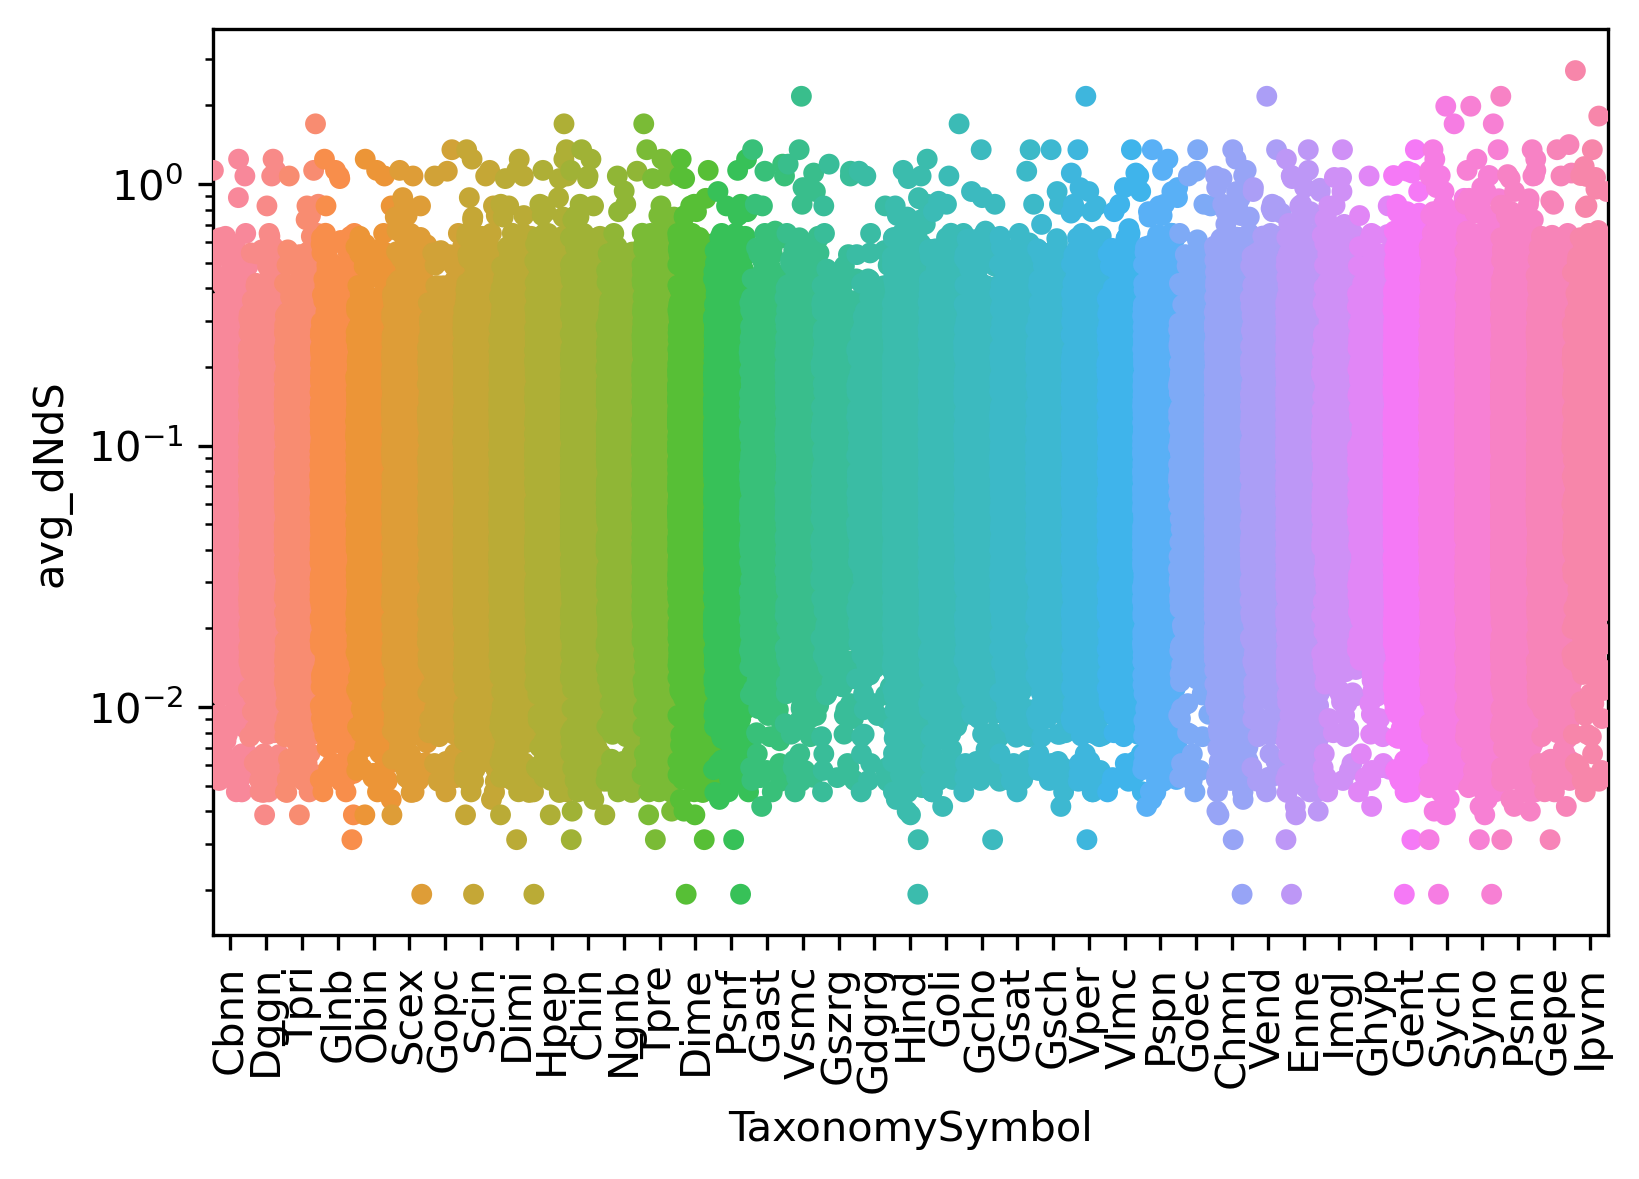

In [236]:
# plt.figure(figsize=(8.5,11))
_ = plt.figure()
# max_dNdS = symbol_dNdS_df.avg_dNdS.max()
# min_dNdS = symbol_dNdS_df.avg_dNdS.min()
_ = sns.stripplot(x='TaxonomySymbol',y='avg_dNdS',data=symbol_dNdS_df,order=ranked_symbols_list,jitter=0.5)
_ = plt.gca().set_yscale('log')
_ = plt.xticks(rotation=90)

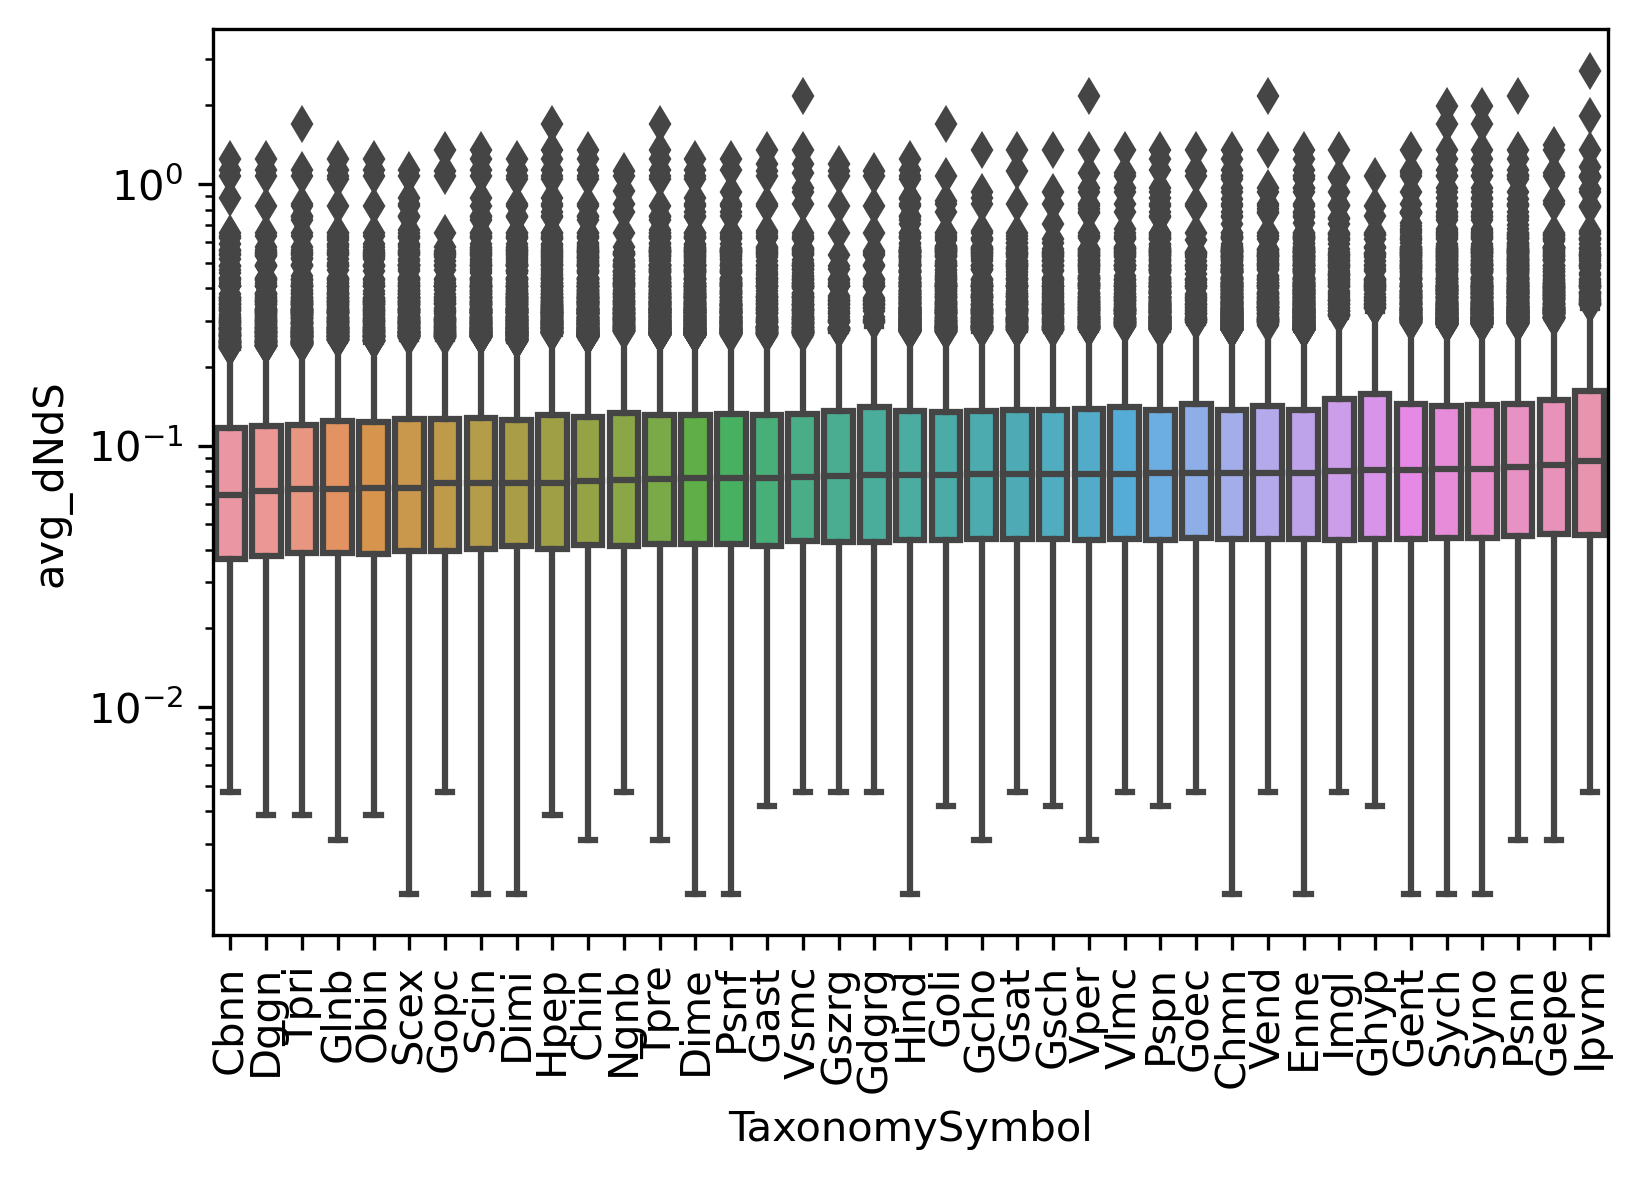

In [138]:
# plt.figure(figsize=(8.5,11))
_ = plt.figure()
# max_dNdS = symbol_dNdS_df.avg_dNdS.max()
# min_dNdS = symbol_dNdS_df.avg_dNdS.min()
_ = sns.boxplot(x='TaxonomySymbol',y='avg_dNdS',data=symbol_dNdS_df,order=ranked_symbols_list)
_ = plt.gca().set_yscale('log')
_ = plt.xticks(rotation=90)

Using TaxonomySymbol still gives too many groups. Also, I noticed there are a lot of cases where a mix_neuron cluster is in a excitatory or inhibitory neuron Taxonomy_Group, or neuroblasts being in a neuron Taxonomy_Group. I want to mannually assigned group to the clusters and discard the clusters that are ambiguious: this is important, because mix-cell-type clusters would make it impossible to detect group-specific genes (e.g., excitatory neuron-specific genes will not be able to be detected when running against trinaries of mix-cell-type clusters, since the excitatory neuron-specific genes are also detected in the mix-cell-type clusters). 

In [486]:
np.unique(cluster_description_df['linhe_class'],return_counts=True)

(array(['PNS_glia', 'endothelia', 'enteric_glia', 'enteric_neuron',
        'exc_neuron', 'excitable', 'glia', 'immune', 'inh_neuron',
        'mix_neuron', 'neuroblasts', 'other', 'pns_neuron'], dtype=object),
 array([ 3,  2,  8,  9, 63,  4, 23,  2, 61, 46, 11,  9, 24]))

### linhe_class-specific genes

In [369]:
NEG_specific_dict={}
NEG_specific_median_dict={}

In [370]:
# Take a look at the dN/dS of CNS neuron-specific genes

# genes that are expressed in CNS excitatory or inhibitory neurons
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]>=0.9,axis=1))
# genes not expressed in CNS glial clusters
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]<=0.1,axis=1))
# genes not expressed in CNS endothelial clusters
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]<=0.1,axis=1))
# Accession ID of neuron-specific genes
accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
cell_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_list)].copy(deep=True)
gene_num = cell_df.shape[0]
NEG_specific_median_dict['CNS_neuron'] = cell_df.copy(deep=True)
median_dNdS=np.median(cell_df['avg_dNdS'])
print(f"CNS_neuron-specific genes with dN/dS: {gene_num}")
print(f"CNS_neuron-specific genes median dN/dS:{median_dNdS}")

CNS_neuron-specific genes with dN/dS: 3652
CNS_neuron-specific genes median dN/dS:0.0889212822567712


In [371]:
# Take a look at the dN/dS of CNS glia-specific genes

# genes that are expressed in CNS glial clusters
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]>=0.9,axis=1))
# genes not expressed in CNS neuronal clusters
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]<=0.1,axis=1))
# genes not expressed in CNS endothelial clusters
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]<=0.1,axis=1))

# Accession ID of neuron-specific genes
accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
cell_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_list)].copy(deep=True)
gene_num = cell_df.shape[0]
median_dNdS=np.median(cell_df['avg_dNdS'])
NEG_specific_median_dict['CNS_glia'] = cell_df.copy(deep=True)
print(f"CNS_glia-specific genes with dN/dS: {gene_num}")
print(f"CNS_glia-specific genes median dN/dS:{median_dNdS}")

CNS_glia-specific genes with dN/dS: 0
CNS_glia-specific genes median dN/dS:nan


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [372]:
# Take a look at the dN/dS of CNS endothelia-specific genes

# genes that are expressed in CNS endothelia clusters
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]>=0.9,axis=1))
# genes not expressed in CNS neuronal clusters
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]<=0.1,axis=1))
# genes not expressed in CNS glial clusters
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]<=0.1,axis=1))

# Accession ID of neuron-specific genes
accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
cell_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_list)].copy(deep=True)
gene_num = cell_df.shape[0]
median_dNdS=np.median(cell_df['avg_dNdS'])
NEG_specific_median_dict['CNS_endothelia'] = cell_df.copy(deep=True)
print(f"CNS_endothelia-specific genes with dN/dS: {gene_num}")
print(f"CNS_endothelia-specific genes median dN/dS:{median_dNdS}")

CNS_endothelia-specific genes with dN/dS: 0
CNS_endothelia-specific genes median dN/dS:nan


This means with the strigent criteria where a CNS glia-specific genes is defined only when the gene is expressed in any glia cluster but not expressed in any CNS neuron or CNS endothelia cluster, you do not find any gene. This is probably due to the huge number of CNS neuron clusters. 

### linhe_class-enriched genes (similar criteria I used for Ben Barres Data)

In [50]:
np.mean(agg[:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)])
np.mean(agg[:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)])
np.mean(agg[:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)])

0.16568544723556533

0.09644761512205548

0.1054652556399856

In [51]:
all_Accession_list = agg.ra.Accession.tolist()

In [52]:
# dataframes storing CNS neuron-specific, CNS glia-specific, and CNS endothelia-specidfic genes
n_list = []
g_list = []
e_list = []

for Accession in all_Accession_list:
    # Check if we have dN/dS value for that gene
    if Accession in avg_dNdS_df.index:

        # define expression level as average expression across corresponding clusters
        n_mean = np.mean(agg[agg.ra.Accession==Accession,:][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)])
        g_mean = np.mean(agg[agg.ra.Accession==Accession,:][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)])
        e_mean = np.mean(agg[agg.ra.Accession==Accession,:][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)])

        # dN/dS, averaged across 92 species, for that gene
        avg_dNdS = avg_dNdS_df.loc[Accession,'avg_dNdS']
        gene_name = avg_dNdS_df.loc[Accession,'Gene name']

        # define cell type-specific genes as genes 
        # with greater than four times expression than 
        # the average of the other two cell types
        if n_mean > (g_mean+e_mean)*2:
            n_list.append(
                {
                    'Accession':Accession,
                    'Gene_name':gene_name,
                    'avg_dNdS':avg_dNdS,
                    'CNS_NEG':'CNS_Neuron'
                }
            )

        if g_mean > (n_mean+e_mean)*2:
            g_list.append(
                {
                    'Accession':Accession,
                    'Gene_name':gene_name,
                    'avg_dNdS':avg_dNdS,
                    'CNS_NEG':'CNS_Glia'
                }
            )

        if e_mean > (n_mean+g_mean)*2:
            e_list.append(
                {
                    'Accession':Accession,
                    'Gene_name':gene_name,
                    'avg_dNdS':avg_dNdS,
                    'CNS_NEG':'CNS_Endothelia'
                }
            )

# Concatenate NEG and convert to dataframe
NEG_list = n_list+g_list+e_list
NEG_df = pd.DataFrame(NEG_list)

In [53]:
NEG_df

Accession Gene_name  avg_dNdS         CNS_NEG
0     ENSMUSG00000024647     Cbln2  0.047158      CNS_Neuron
1     ENSMUSG00000029503     P2rx2  0.140467      CNS_Neuron
2     ENSMUSG00000039942    Ptger4  0.076129      CNS_Neuron
3     ENSMUSG00000059187     Tafa1  0.018042      CNS_Neuron
4     ENSMUSG00000079560     Hoxa3  0.053325      CNS_Neuron
...                  ...       ...       ...             ...
7761  ENSMUSG00000027215      Cd82  0.130647  CNS_Endothelia
7762  ENSMUSG00000038712    Mindy1  0.141459  CNS_Endothelia
7763  ENSMUSG00000034936     Arl4d  0.027979  CNS_Endothelia
7764  ENSMUSG00000019820      Utrn  0.117890  CNS_Endothelia
7765  ENSMUSG00000039264    Gimap3  0.507580  CNS_Endothelia

[7766 rows x 4 columns]

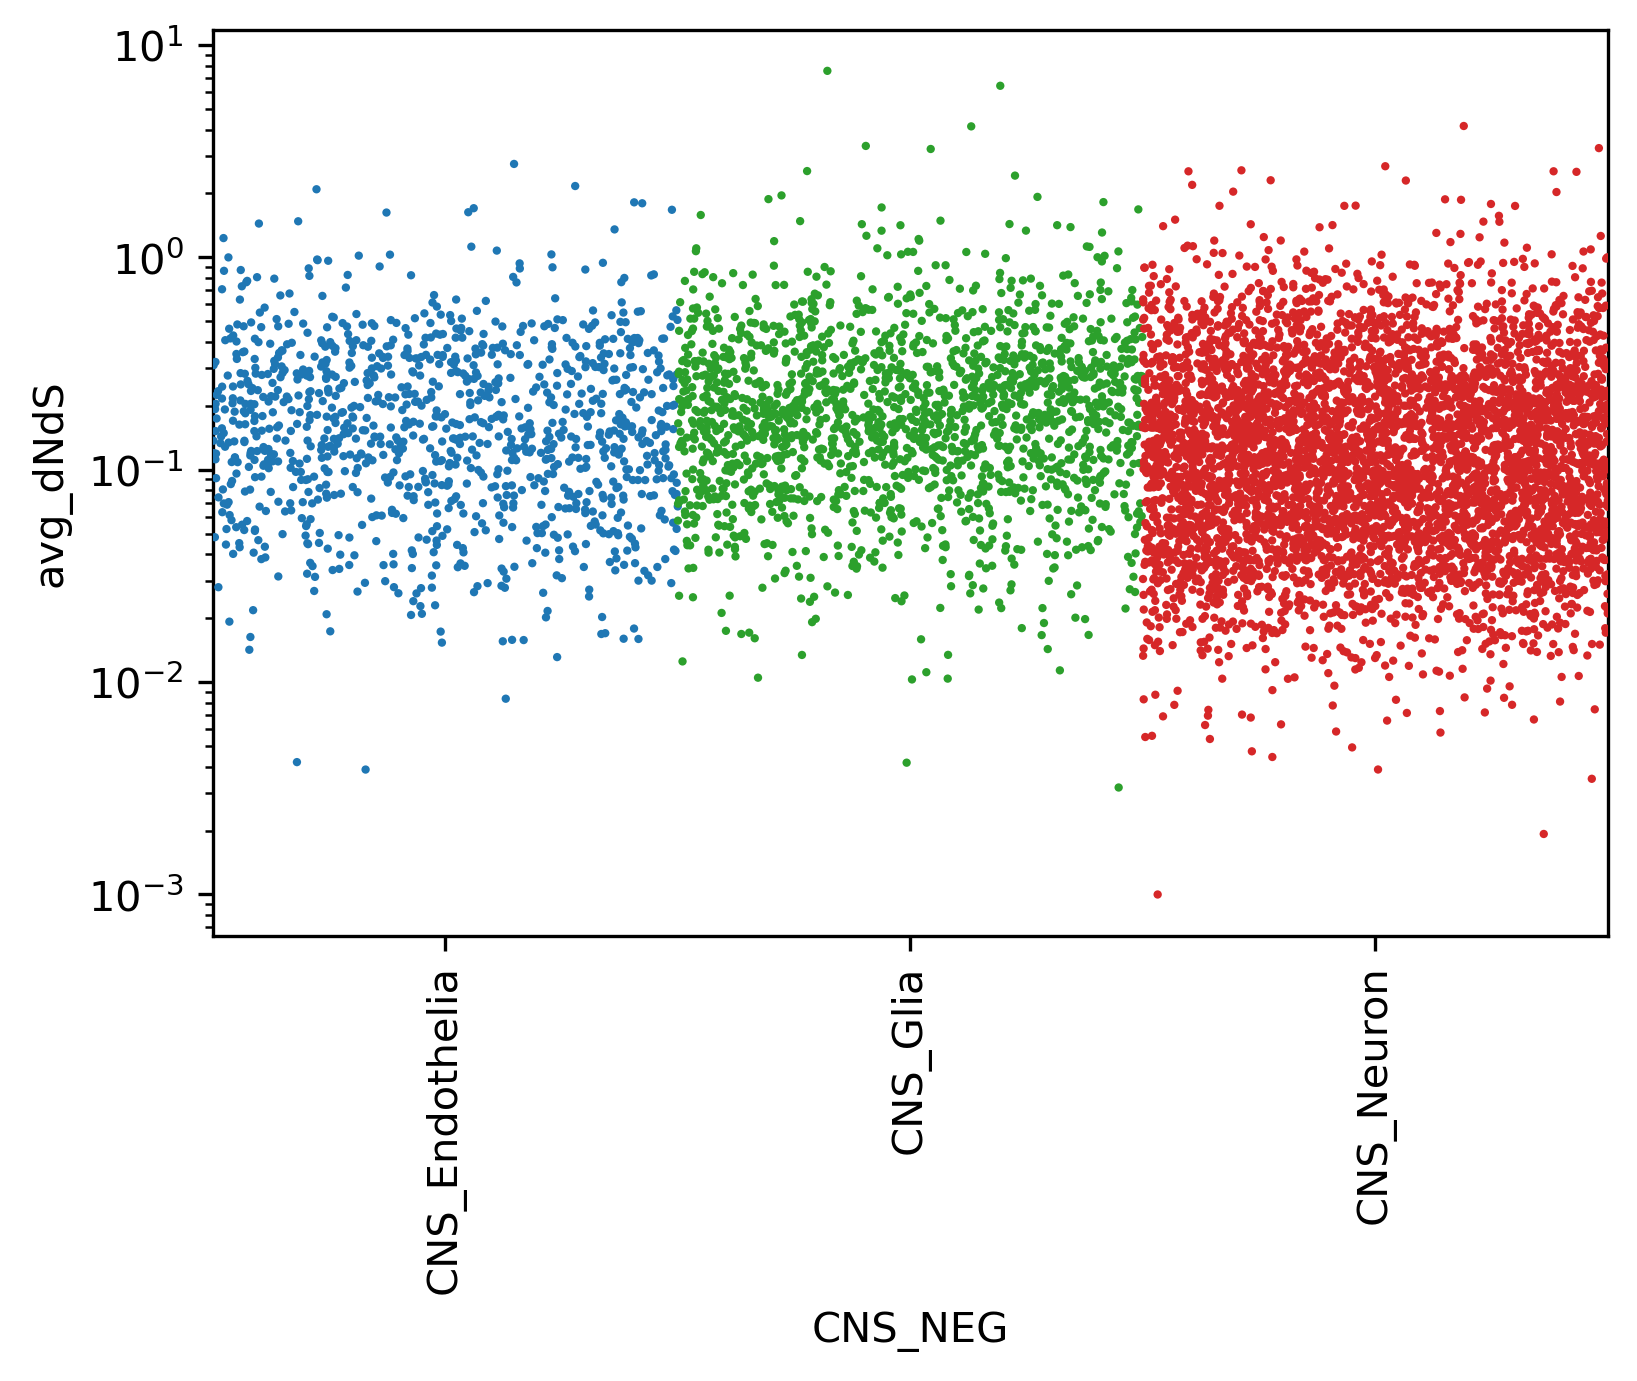

In [376]:
# plt.figure(figsize=(8.5,11))
_ = plt.figure()
# max_dNdS = symbol_dNdS_df.avg_dNdS.max()
# min_dNdS = symbol_dNdS_df.avg_dNdS.min()
palette = {
    'CNS_Endothelia':'Tab:blue',
    'CNS_Glia':'Tab:green',
    'CNS_Neuron':'Tab:red'
}
_ = sns.stripplot(x='CNS_NEG',y='avg_dNdS',data=NEG_df,order=['CNS_Endothelia','CNS_Glia','CNS_Neuron'],jitter=0.5,palette=palette,size=2)
_ = plt.gca().set_yscale('log')
_ = plt.xticks(rotation=90)

Note that this is different from the one I generated for Ben Barres data: here one dot is the 92 species average dN/dS for one gene; the one for Barres data is one dot for one species dN/dS against mouse for one gene (potentailly having up to 92 dots per gene). 

In [378]:
np.median(NEG_df[NEG_df['CNS_NEG']=='CNS_Neuron']['avg_dNdS'])

0.1121047608523907

In [379]:
np.median(NEG_df[NEG_df['CNS_NEG']=='CNS_Endothelia']['avg_dNdS'])

0.1539743613004061

In [380]:
np.median(NEG_df[NEG_df['CNS_NEG']=='CNS_Glia']['avg_dNdS'])

0.18063822031707724

In [381]:
pg.mwu(NEG_df[NEG_df['CNS_NEG']=='CNS_Glia']['avg_dNdS'], NEG_df[NEG_df['CNS_NEG']=='CNS_Neuron']['avg_dNdS'], alternative='two-sided')

U-val alternative         p-val       RBC      CLES
MWU  5480345.0   two-sided  1.295409e-60 -0.263172  0.631586

In [382]:
pg.mwu(NEG_df[NEG_df['CNS_NEG']=='CNS_Endothelia']['avg_dNdS'], NEG_df[NEG_df['CNS_NEG']=='CNS_Neuron']['avg_dNdS'], alternative='two-sided')

U-val alternative         p-val       RBC      CLES
MWU  3188617.0   two-sided  4.078831e-21 -0.181813  0.590907

In [383]:
pg.mwu(NEG_df[NEG_df['CNS_NEG']=='CNS_Glia']['avg_dNdS'], NEG_df[NEG_df['CNS_NEG']=='CNS_Endothelia']['avg_dNdS'], alternative='two-sided')

U-val alternative     p-val       RBC      CLES
MWU  1047576.0   two-sided  0.000195 -0.082705  0.541353

### CNS NEG by trinaries

##### 0.9 threshold for trinaries

In [26]:
# Neuron
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]>=0.9,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]<0.9,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]<0.9,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

n_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
n_tri_df['CNS_NEG']='CNS_Neuron'

# Glia
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]>=0.9,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]<0.9,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]<0.9,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

g_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
g_tri_df['CNS_NEG']='CNS_glia'

# endothelia
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]>=0.9,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]<0.9,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]<0.9,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

e_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
e_tri_df['CNS_NEG']='CNS_glia'

In [40]:
n_tri_df['avg_dNdS'].describe()
e_tri_df['avg_dNdS'].describe()
g_tri_df['avg_dNdS'].describe()

count    4349.000000
mean        0.116467
std         0.102332
min         0.001926
25%         0.048893
50%         0.086985
75%         0.152133
max         1.246333
Name: avg_dNdS, dtype: float64

count    149.000000
mean       0.175415
std        0.214659
min        0.013113
25%        0.075490
50%        0.120599
75%        0.203891
max        2.168086
Name: avg_dNdS, dtype: float64

count    818.000000
mean       0.189202
std        0.159097
min        0.004173
25%        0.086495
50%        0.142759
75%        0.242948
max        1.417029
Name: avg_dNdS, dtype: float64

##### 0.99 trinaries thrshold

In [41]:
# setting threshold
low_thr=0.99
high_thr=0.99
# Neuron
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

n_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
n_tri_df['CNS_NEG']='CNS_Neuron'

# Glia
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

g_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
g_tri_df['CNS_NEG']='CNS_glia'

# endothelia
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

e_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
e_tri_df['CNS_NEG']='CNS_glia'

# Descriptive
n_tri_df['avg_dNdS'].describe()
e_tri_df['avg_dNdS'].describe()
g_tri_df['avg_dNdS'].describe()

count    3786.000000
mean        0.110647
std         0.098299
min         0.001926
25%         0.046669
50%         0.082169
75%         0.144961
max         1.246333
Name: avg_dNdS, dtype: float64

count    168.000000
mean       0.176620
std        0.205959
min        0.013113
25%        0.075898
50%        0.124787
75%        0.209379
max        2.168086
Name: avg_dNdS, dtype: float64

count    927.000000
mean       0.177877
std        0.152755
min        0.004173
25%        0.081460
50%        0.136748
75%        0.229538
max        1.417029
Name: avg_dNdS, dtype: float64

##### 0.999 threshold

In [44]:
# setting threshold
low_thr=0.999
high_thr=0.999
# Neuron
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

n_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
n_tri_df['CNS_NEG']='CNS_Neuron'

# Glia
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

g_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
g_tri_df['CNS_NEG']='CNS_glia'

# endothelia
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

e_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
e_tri_df['CNS_NEG']='CNS_glia'

# Descriptive
n_tri_df['avg_dNdS'].describe()
e_tri_df['avg_dNdS'].describe()
g_tri_df['avg_dNdS'].describe()

count    3561.000000
mean        0.107272
std         0.096071
min         0.001926
25%         0.044740
50%         0.079318
75%         0.139882
max         1.246333
Name: avg_dNdS, dtype: float64

count    173.000000
mean       0.181392
std        0.212336
min        0.013113
25%        0.076893
50%        0.123965
75%        0.211249
max        2.168086
Name: avg_dNdS, dtype: float64

count    952.000000
mean       0.174313
std        0.151094
min        0.004173
25%        0.079068
50%        0.133697
75%        0.224998
max        1.417029
Name: avg_dNdS, dtype: float64

##### 0.9999 threshold

In [45]:
# setting threshold
low_thr=0.9999
high_thr=0.9999
# Neuron
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

n_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
n_tri_df['CNS_NEG']='CNS_Neuron'

# Glia
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

g_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
g_tri_df['CNS_NEG']='CNS_glia'

# endothelia
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

e_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
e_tri_df['CNS_NEG']='CNS_glia'

# Descriptive
n_tri_df['avg_dNdS'].describe()
e_tri_df['avg_dNdS'].describe()
g_tri_df['avg_dNdS'].describe()

count    3430.000000
mean        0.104972
std         0.094173
min         0.001926
25%         0.043561
50%         0.077901
75%         0.136571
max         1.246333
Name: avg_dNdS, dtype: float64

count    174.000000
mean       0.179443
std        0.212498
min        0.013113
25%        0.075680
50%        0.120211
75%        0.210625
max        2.168086
Name: avg_dNdS, dtype: float64

count    977.000000
mean       0.169734
std        0.146456
min        0.004173
25%        0.075451
50%        0.130846
75%        0.223531
max        1.417029
Name: avg_dNdS, dtype: float64

##### 0.99999 threshold

In [46]:
# setting threshold
low_thr=0.99999
high_thr=0.99999
# Neuron
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

n_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
n_tri_df['CNS_NEG']='CNS_Neuron'

# Glia
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

g_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
g_tri_df['CNS_NEG']='CNS_glia'

# endothelia
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

e_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
e_tri_df['CNS_NEG']='CNS_glia'

# Descriptive
n_tri_df['avg_dNdS'].describe()
e_tri_df['avg_dNdS'].describe()
g_tri_df['avg_dNdS'].describe()

count    3317.000000
mean        0.103592
std         0.093452
min         0.001926
25%         0.043056
50%         0.076561
75%         0.134861
max         1.246333
Name: avg_dNdS, dtype: float64

count    185.000000
mean       0.181319
std        0.213825
min        0.013113
25%        0.076893
50%        0.120599
75%        0.211249
max        2.168086
Name: avg_dNdS, dtype: float64

count    986.000000
mean       0.169446
std        0.153090
min        0.004173
25%        0.074842
50%        0.129808
75%        0.222051
max        1.700935
Name: avg_dNdS, dtype: float64

##### 0.1 and 0.9 threshold

In [42]:
# setting threshold
low_thr=0.1
high_thr=0.9
# Neuron
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

n_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
n_tri_df['CNS_NEG']='CNS_Neuron'

# Glia
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

g_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
g_tri_df['CNS_NEG']='CNS_glia'

# endothelia
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

e_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
e_tri_df['CNS_NEG']='CNS_glia'

# Descriptive
n_tri_df['avg_dNdS'].describe()
e_tri_df['avg_dNdS'].describe()
g_tri_df['avg_dNdS'].describe()

count    3652.000000
mean        0.119860
std         0.105605
min         0.001926
25%         0.049730
50%         0.088921
75%         0.157445
max         1.246333
Name: avg_dNdS, dtype: float64

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: avg_dNdS, dtype: float64

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: avg_dNdS, dtype: float64

##### 0.01 and 0.99 threshold

In [43]:
# setting threshold
low_thr=0.01
high_thr=0.99
# Neuron
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

n_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
n_tri_df['CNS_NEG']='CNS_Neuron'

# Glia
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

g_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
g_tri_df['CNS_NEG']='CNS_glia'

# endothelia
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_endothelia_cluster_list)]>=high_thr,axis=1))
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_neuron_cluster_list)]<low_thr,axis=1))
condition3=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, CNS_glia_cluster_list)]<low_thr,axis=1))

accession_list = agg.ra.Accession[(condition1&condition2&condition3)]
accession_set = set(avg_dNdS_df.index)&set(accession_list)

e_tri_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
e_tri_df['CNS_NEG']='CNS_glia'

# Descriptive
n_tri_df['avg_dNdS'].describe()
e_tri_df['avg_dNdS'].describe()
g_tri_df['avg_dNdS'].describe()

count    2513.000000
mean        0.114602
std         0.105269
min         0.001926
25%         0.048139
50%         0.082571
75%         0.147889
max         1.246333
Name: avg_dNdS, dtype: float64

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: avg_dNdS, dtype: float64

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: avg_dNdS, dtype: float64

### VING specific genes by 0.999 threshold trinaries

In [200]:
TaxonomyRank1_list = np.unique(agg.ca.TaxonomyRank1).tolist()
VING_tri_999_df=pd.DataFrame()
for celltype in TaxonomyRank1_list:
    # genes that are expressed in at least one cluster within current cell type
    condition1=(np.any(agg['trinaries'][:,(agg.ca.TaxonomyRank1==celltype)]>=0.999,axis=1))
    # genes that are not expressed in any cluter other than clusters within the current cell type
    condition2=(np.all(agg['trinaries'][:,(agg.ca.TaxonomyRank1!=celltype)]<0.999,axis=1))
    # genes specific to the current cell type
    accession_list = agg.ra.Accession[(condition1&condition2)]
    accession_set = set(avg_dNdS_df.index)&set(accession_list)
    df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_set)].copy(deep=True)
    df['VING']=celltype
    VING_tri_999_df=pd.concat([VING_tri_999_df,df])
    print(celltype)
    df['avg_dNdS'].describe()

Glia


count    782.000000
mean       0.185981
std        0.140793
min        0.007683
25%        0.087156
50%        0.152798
75%        0.239966
max        1.417029
Name: avg_dNdS, dtype: float64

Immune cells


count    129.000000
mean       0.295686
std        0.343347
min        0.010488
25%        0.106598
50%        0.192013
75%        0.364258
max        2.718201
Name: avg_dNdS, dtype: float64

Neurons


count    3760.000000
mean        0.118240
std         0.109379
min         0.001926
25%         0.049222
50%         0.088649
75%         0.152771
max         1.986306
Name: avg_dNdS, dtype: float64

Vascular cells


count    194.000000
mean       0.147267
std        0.114819
min        0.019317
25%        0.072088
50%        0.118550
75%        0.186648
max        0.806812
Name: avg_dNdS, dtype: float64

In [201]:
for (type1,type2) in list(combinations(TaxonomyRank1_list,2)):
    print(f"{type1} vs {type2}")
    pg.mwu(VING_tri_999_df[VING_tri_999_df['VING']==type1]['avg_dNdS'],VING_tri_999_df[VING_tri_999_df['VING']==type2]['avg_dNdS'],alternative='two-sided')

Glia vs Immune cells


U-val alternative     p-val      RBC      CLES
MWU  41418.0   two-sided  0.001123  0.17885  0.410575

Glia vs Neurons


U-val alternative         p-val      RBC      CLES
MWU  2008695.0   two-sided  1.309962e-58 -0.36631  0.683155

Glia vs Vascular cells


U-val alternative     p-val       RBC    CLES
MWU  90160.0   two-sided  0.000047 -0.188599  0.5943

Immune cells vs Neurons


U-val alternative         p-val       RBC      CLES
MWU  358526.0   two-sided  2.216522e-20 -0.478336  0.739168

Immune cells vs Vascular cells


U-val alternative         p-val      RBC      CLES
MWU  16720.0   two-sided  3.098937e-07 -0.33621  0.668105

Neurons vs Vascular cells


U-val alternative     p-val       RBC      CLES
MWU  292732.0   two-sided  0.000003  0.197379  0.401311

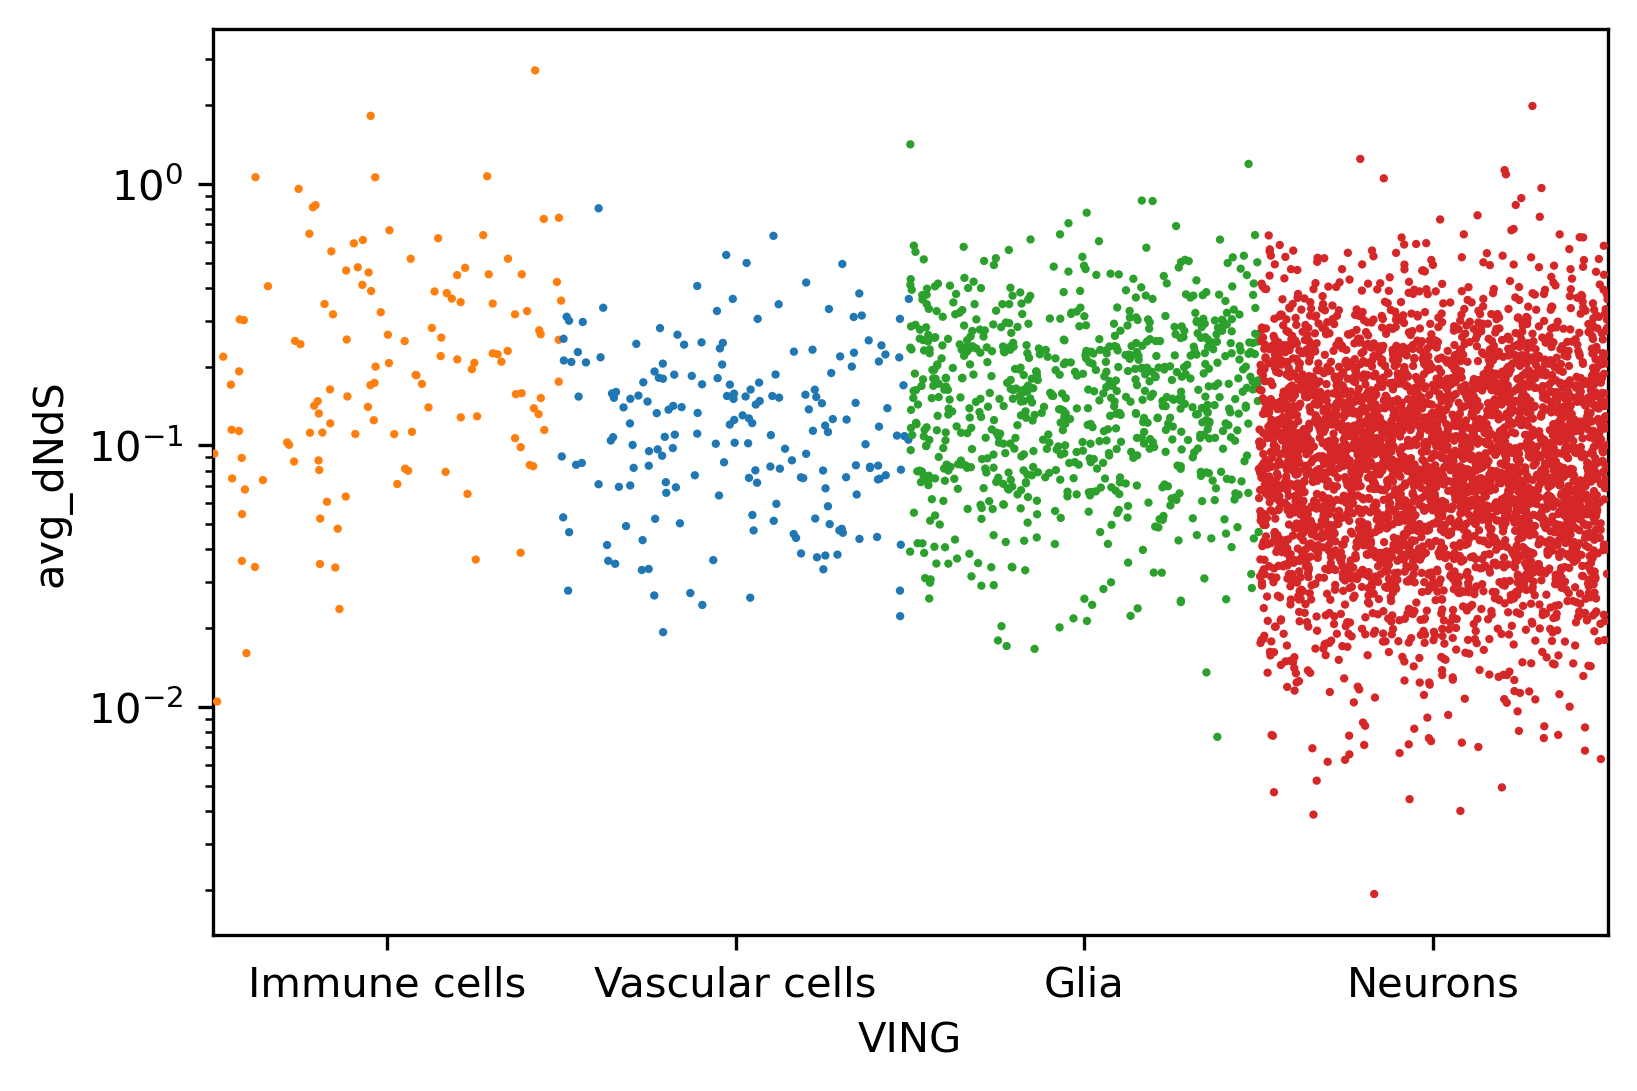

In [212]:
# plt.figure(figsize=(8.5,11))
_ = plt.figure()
# max_dNdS = symbol_dNdS_df.avg_dNdS.max()
# min_dNdS = symbol_dNdS_df.avg_dNdS.min()
palette = {
    'Immune cells':'Tab:orange',
    'Vascular cells':'Tab:blue',
    'Glia':'Tab:green',
    'Neurons':'Tab:red'
}
_ = sns.stripplot(x='VING',y='avg_dNdS',data=VING_tri_999_df,order=['Immune cells','Vascular cells','Glia','Neurons'],jitter=0.5,palette=palette,size=2)
_ = plt.gca().set_yscale('log')
_ = plt.rc('xtick',labelsize=1)
# _ = plt.xticks(rotation=90)

In [206]:
VING_tri_999_df

Gene name  avg_dNdS            VING
Gene stable ID                                        
ENSMUSG00000027379      Bub1  0.327491            Glia
ENSMUSG00000035683      Melk  0.176147            Glia
ENSMUSG00000019975     Ikbip  0.185786            Glia
ENSMUSG00000039543    Cfap70  0.194459            Glia
ENSMUSG00000020930   Ccdc103  0.199612            Glia
...                      ...       ...             ...
ENSMUSG00000070867   Trabd2b  0.080753  Vascular cells
ENSMUSG00000036381    P2ry14  0.133103  Vascular cells
ENSMUSG00000038543  BC028528  0.498656  Vascular cells
ENSMUSG00000034738   Nostrin  0.205482  Vascular cells
ENSMUSG00000006386       Tek  0.095079  Vascular cells

[4865 rows x 3 columns]

### Original NEAMO genes: dNdS vs expresison level 

I want to see if the original discovery of low dN/dS for neuron-specific genes only due to neurons expressing genes at high level (supposedly higher expression level leads to lower dN/dS)

In [226]:
NEAMO_dict = {}
for file in glob.glob('../results/mouse.celltype-specific_genes/protein-coding_w_dNdS/Ensembl_ID_*.tsv'):
    celltype = file[74:-4]
    df = pd.read_csv(file,sep='\t',names=['Gene stable ID'])
    NEAMO_dict[celltype]=df.copy(deep=True)

In [292]:
NEAMO_dict.keys()

dict_keys(['endothelia', 'astrocyte', 'neuron', 'microglia', 'glia', 'oligodendrocyte'])

##### Correlated with total UMI (sum of 265 clusters)

In [321]:
total_UMI_df['Barres_NEAMO']='other'

for celltype in ['endothelia', 'astrocyte', 'neuron', 'microglia', 'oligodendrocyte']:
    total_UMI_df.loc[np.isin(total_UMI_df['Accession'],NEAMO_dict[celltype]['Gene stable ID']),'Barres_NEAMO']=celltype

In [335]:
total_UMI_df

Accession  total_UMI  UMI_per_cell Gene name  avg_dNdS  \
0      ENSMUSG00000024647    17009.0      0.105780     Cbln2  0.047158   
1      ENSMUSG00000041544     4379.0      0.027233     Disp3  0.049768   
2      ENSMUSG00000029503     3082.0      0.019167     P2rx2  0.140467   
3      ENSMUSG00000039942     1128.0      0.007015    Ptger4  0.076129   
4      ENSMUSG00000059187    41416.0      0.257569     Tafa1  0.018042   
...                   ...        ...           ...       ...       ...   
19141  ENSMUSG00000035757    13429.0      0.083516   Selenoo  0.103501   
19142  ENSMUSG00000026860    69379.0      0.431472   Sh3glb2  0.043883   
19143  ENSMUSG00000026766    22544.0      0.140202    Mmadhc  0.092318   
19144  ENSMUSG00000026799    10737.0      0.066774     Med27  0.016523   
19145  ENSMUSG00000021832    37439.0      0.232835     Psmc6  0.118070   

      Barres_NEAMO  
0           neuron  
1            other  
2           neuron  
3        microglia  
4            other  
...            ...  
19141        other  
19142        other  
19143        other  
19144        other  
19145        other  

[17494 rows x 6 columns]

[None, None]

<AxesSubplot:xlabel='total_UMI', ylabel='avg_dNdS'>

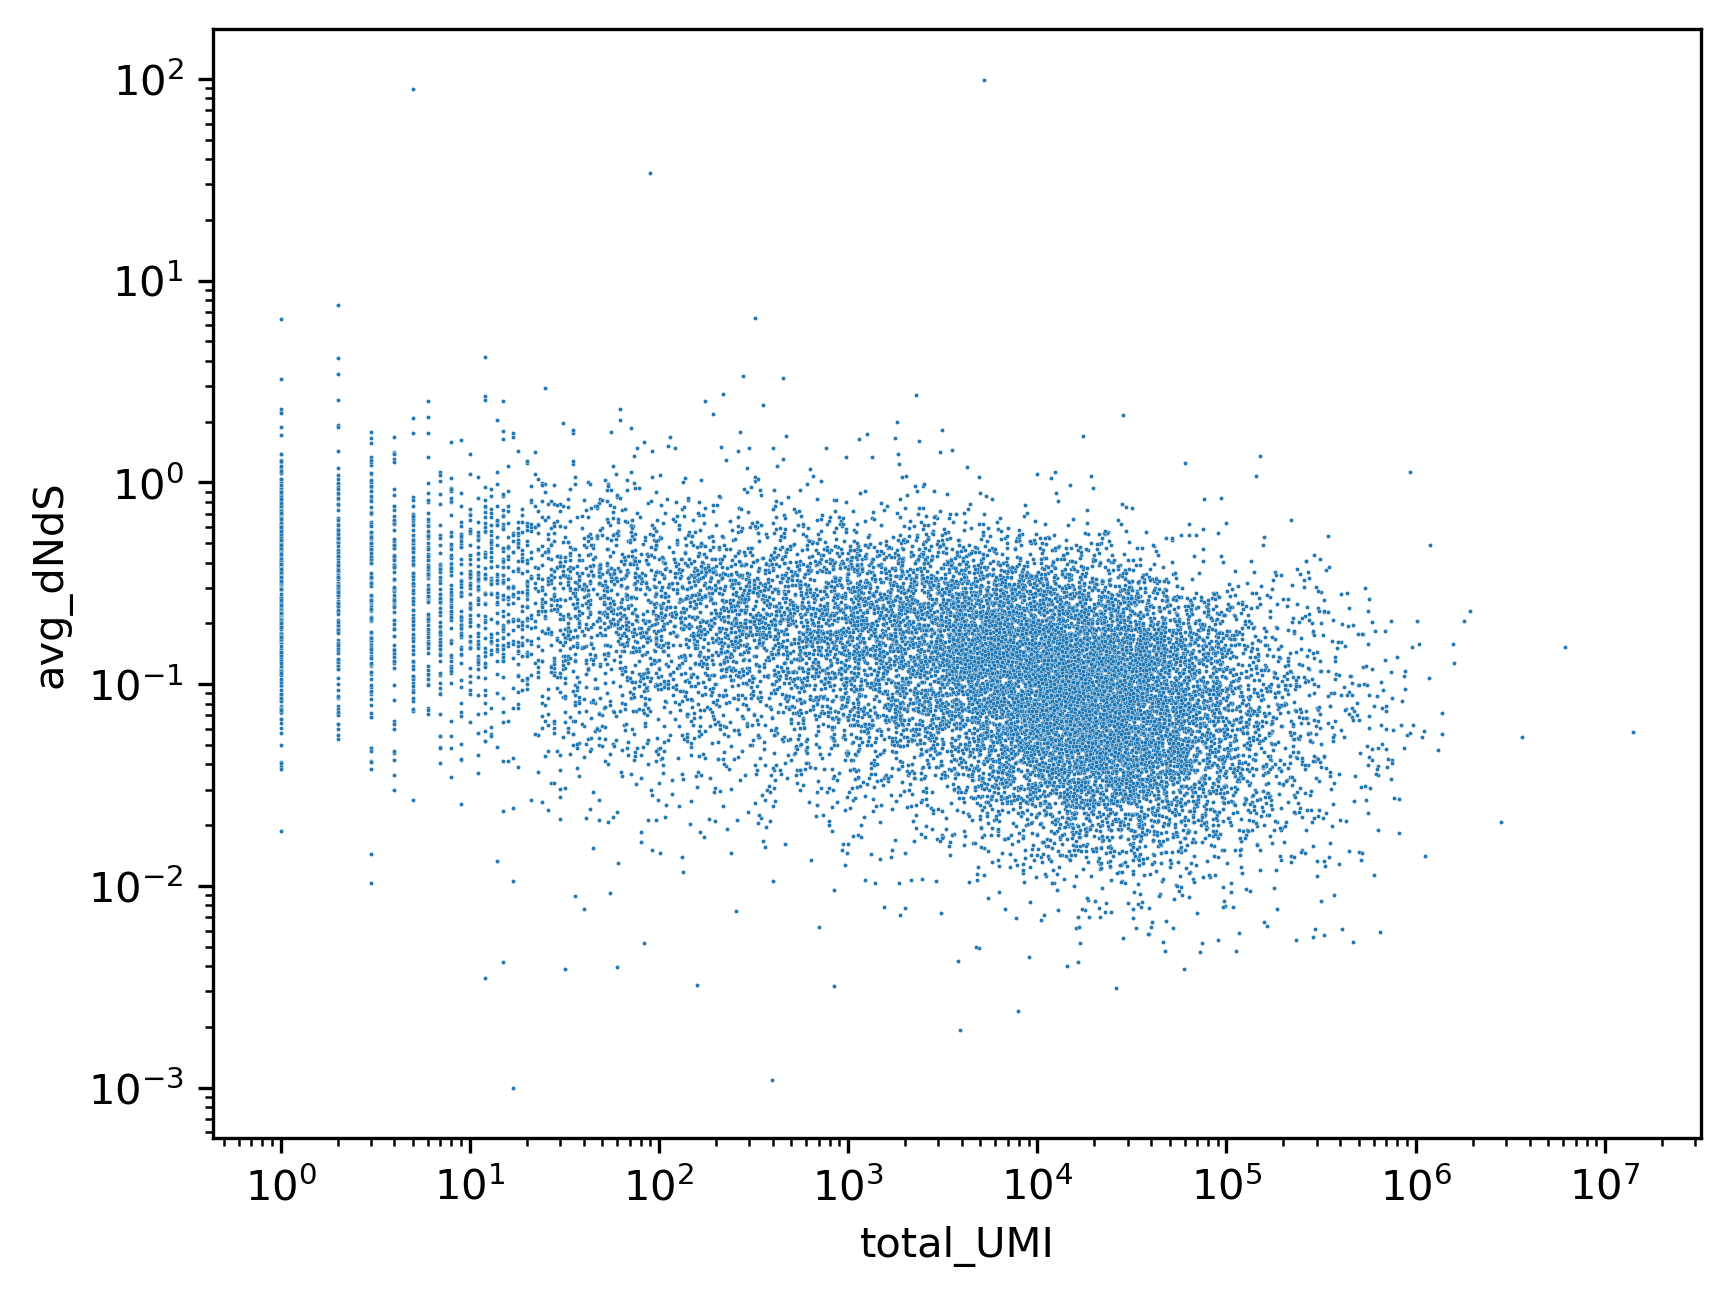

In [338]:
fig,ax=plt.subplots()
ax.set(xscale='log',yscale='log')
sns.scatterplot(data=total_UMI_df,x='total_UMI',y='avg_dNdS',s=1)

In [334]:
pg.corr(total_UMI_df['total_UMI'],total_UMI_df['avg_dNdS'],method='spearman')

n         r           CI95%  p-val  power
spearman  17494 -0.463963  [-0.48, -0.45]    0.0    1.0

[None, None]

<AxesSubplot:xlabel='total_UMI', ylabel='avg_dNdS'>

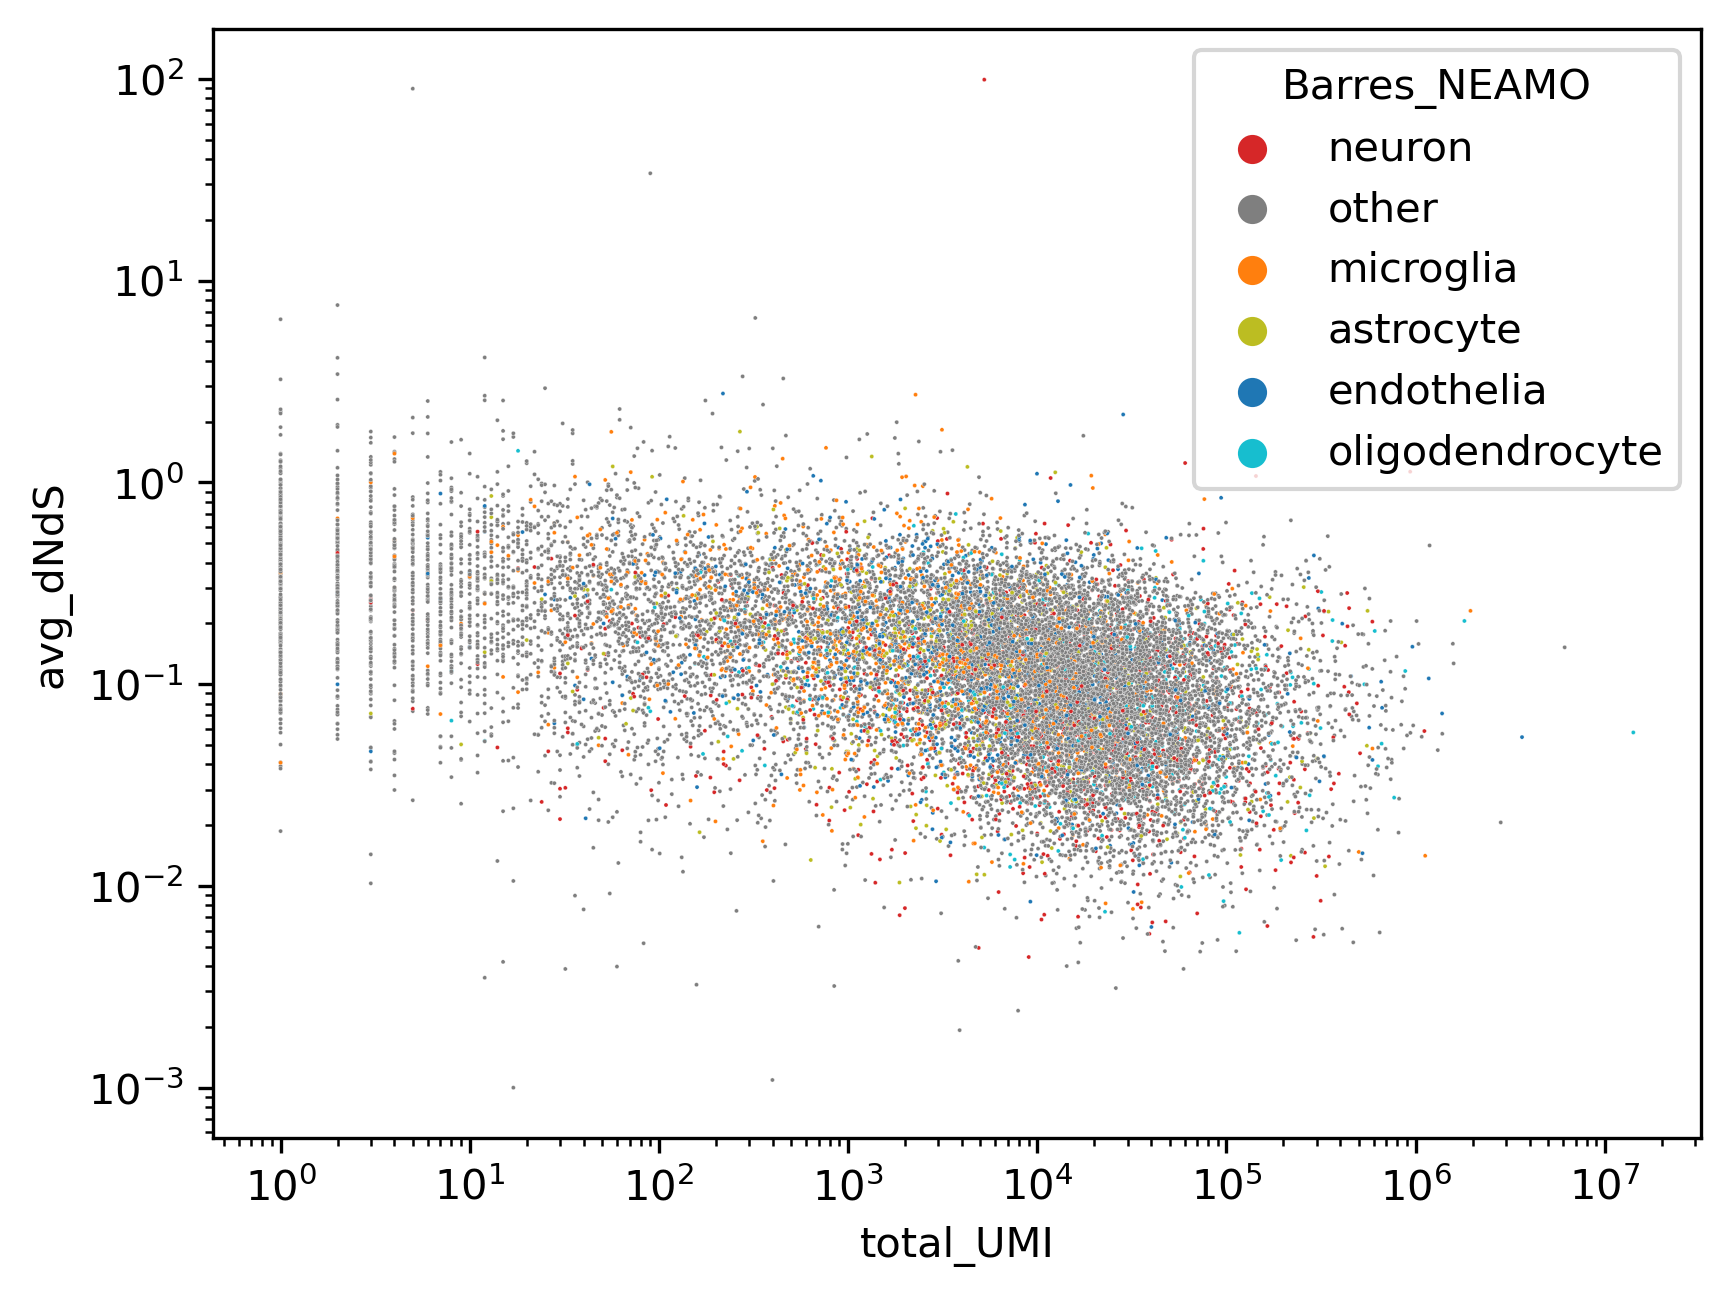

In [339]:
fig,ax=plt.subplots()
ax.set(xscale='log',yscale='log')
sns.scatterplot(data=total_UMI_df,x='total_UMI',y='avg_dNdS',hue='Barres_NEAMO',palette=color_NEAMO_dict,s=1)

[None, None]

<AxesSubplot:xlabel='total_UMI', ylabel='avg_dNdS'>

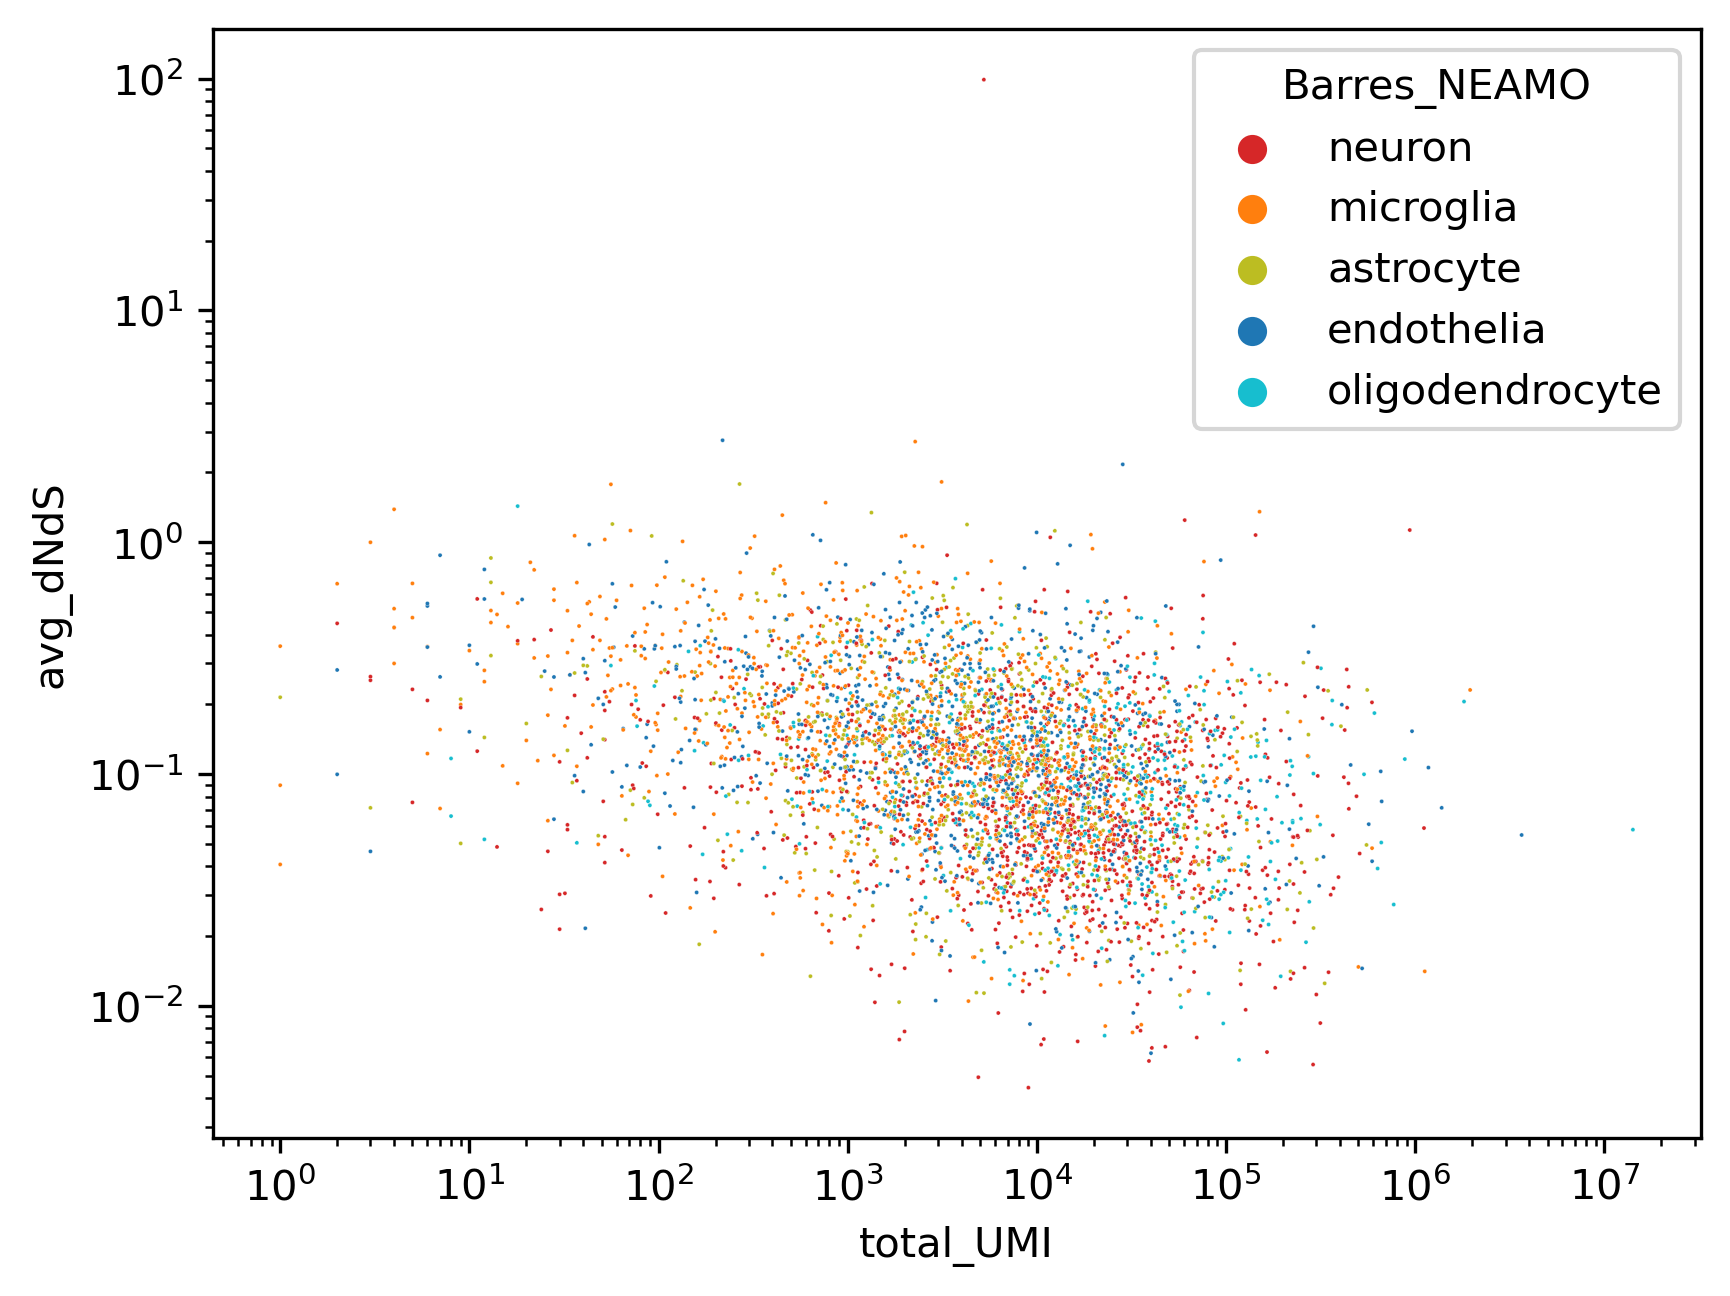

In [340]:
fig,ax=plt.subplots()
ax.set(xscale='log',yscale='log')
sns.scatterplot(data=total_UMI_df[total_UMI_df['Barres_NEAMO']!='other'],x='total_UMI',y='avg_dNdS',hue='Barres_NEAMO',palette=color_NEAMO_dict,s=1)

In [348]:
UMI_dNdS_corr_dict={}
for celltype in ['endothelia', 'astrocyte', 'neuron', 'microglia', 'oligodendrocyte']:
    df = total_UMI_df[total_UMI_df['Barres_NEAMO']==celltype]
    print(celltype)
    pg.corr(df['total_UMI'],df['avg_dNdS'],method='spearman')
    UMI_dNdS_corr_dict[celltype]=pg.corr(df['total_UMI'],df['avg_dNdS'],method='spearman')

endothelia


n         r          CI95%         p-val  power
spearman  932 -0.353161  [-0.41, -0.3]  9.207439e-29    1.0

astrocyte


n         r           CI95%         p-val  power
spearman  824 -0.369186  [-0.43, -0.31]  5.240574e-28    1.0

neuron


n         r           CI95%         p-val  power
spearman  1294 -0.219753  [-0.27, -0.17]  1.292865e-15    1.0

microglia


n         r           CI95%         p-val  power
spearman  1056 -0.420161  [-0.47, -0.37]  2.042118e-46    1.0

oligodendrocyte


n         r           CI95%         p-val     power
spearman  520 -0.233438  [-0.31, -0.15]  7.246136e-08  0.999722

In [364]:
for (celltype1, celltype2) in combinations(['endothelia', 'astrocyte', 'neuron', 'microglia', 'oligodendrocyte'],r=2):
    r1 = UMI_dNdS_corr_dict[celltype1]['r'][0]
    r2 = UMI_dNdS_corr_dict[celltype2]['r'][0]
    n1 = UMI_dNdS_corr_dict[celltype1]['n'][0]
    n2 = UMI_dNdS_corr_dict[celltype2]['n'][0]
    z, p = independent_corr(r1=r1,r2=r2,n1=n1,n2=n2)
    print(f"{celltype1} vs {celltype2}: z={z}, p={p}")

endothelia vs astrocyte: z=0.3847480460076812, p=0.7004240946378328
endothelia vs neuron: z=3.385464746481986, p=0.0007105783617513683
endothelia vs microglia: z=1.7514524841261512, p=0.07986799920902543
endothelia vs oligodendrocyte: z=2.3916476136190092, p=0.01677293766189858
astrocyte vs neuron: z=3.6758193798174372, p=0.000237087226218069
astrocyte vs microglia: z=1.2974437598994462, p=0.19447854408254184
astrocyte vs oligodendrocyte: z=2.6655637400014434, p=0.007685936007039373
neuron vs microglia: z=5.406269046626451, p=6.43511111064754e-08
neuron vs oligodendrocyte: z=0.2771747582629522, p=0.78164592058735
microglia vs oligodendrocyte: z=3.911683064286041, p=9.165514239151129e-05


##### Correlated with CNS total UMI (as defined by linhe_class)

In [384]:
total_CNS_UMI_df['Barres_NEAMO']='other'

for celltype in ['endothelia', 'astrocyte', 'neuron', 'microglia', 'oligodendrocyte']:
    total_CNS_UMI_df.loc[np.isin(total_CNS_UMI_df['Accession'],NEAMO_dict[celltype]['Gene stable ID']),'Barres_NEAMO']=celltype

[None, None]

<AxesSubplot:xlabel='total_CNS_UMI', ylabel='avg_dNdS'>

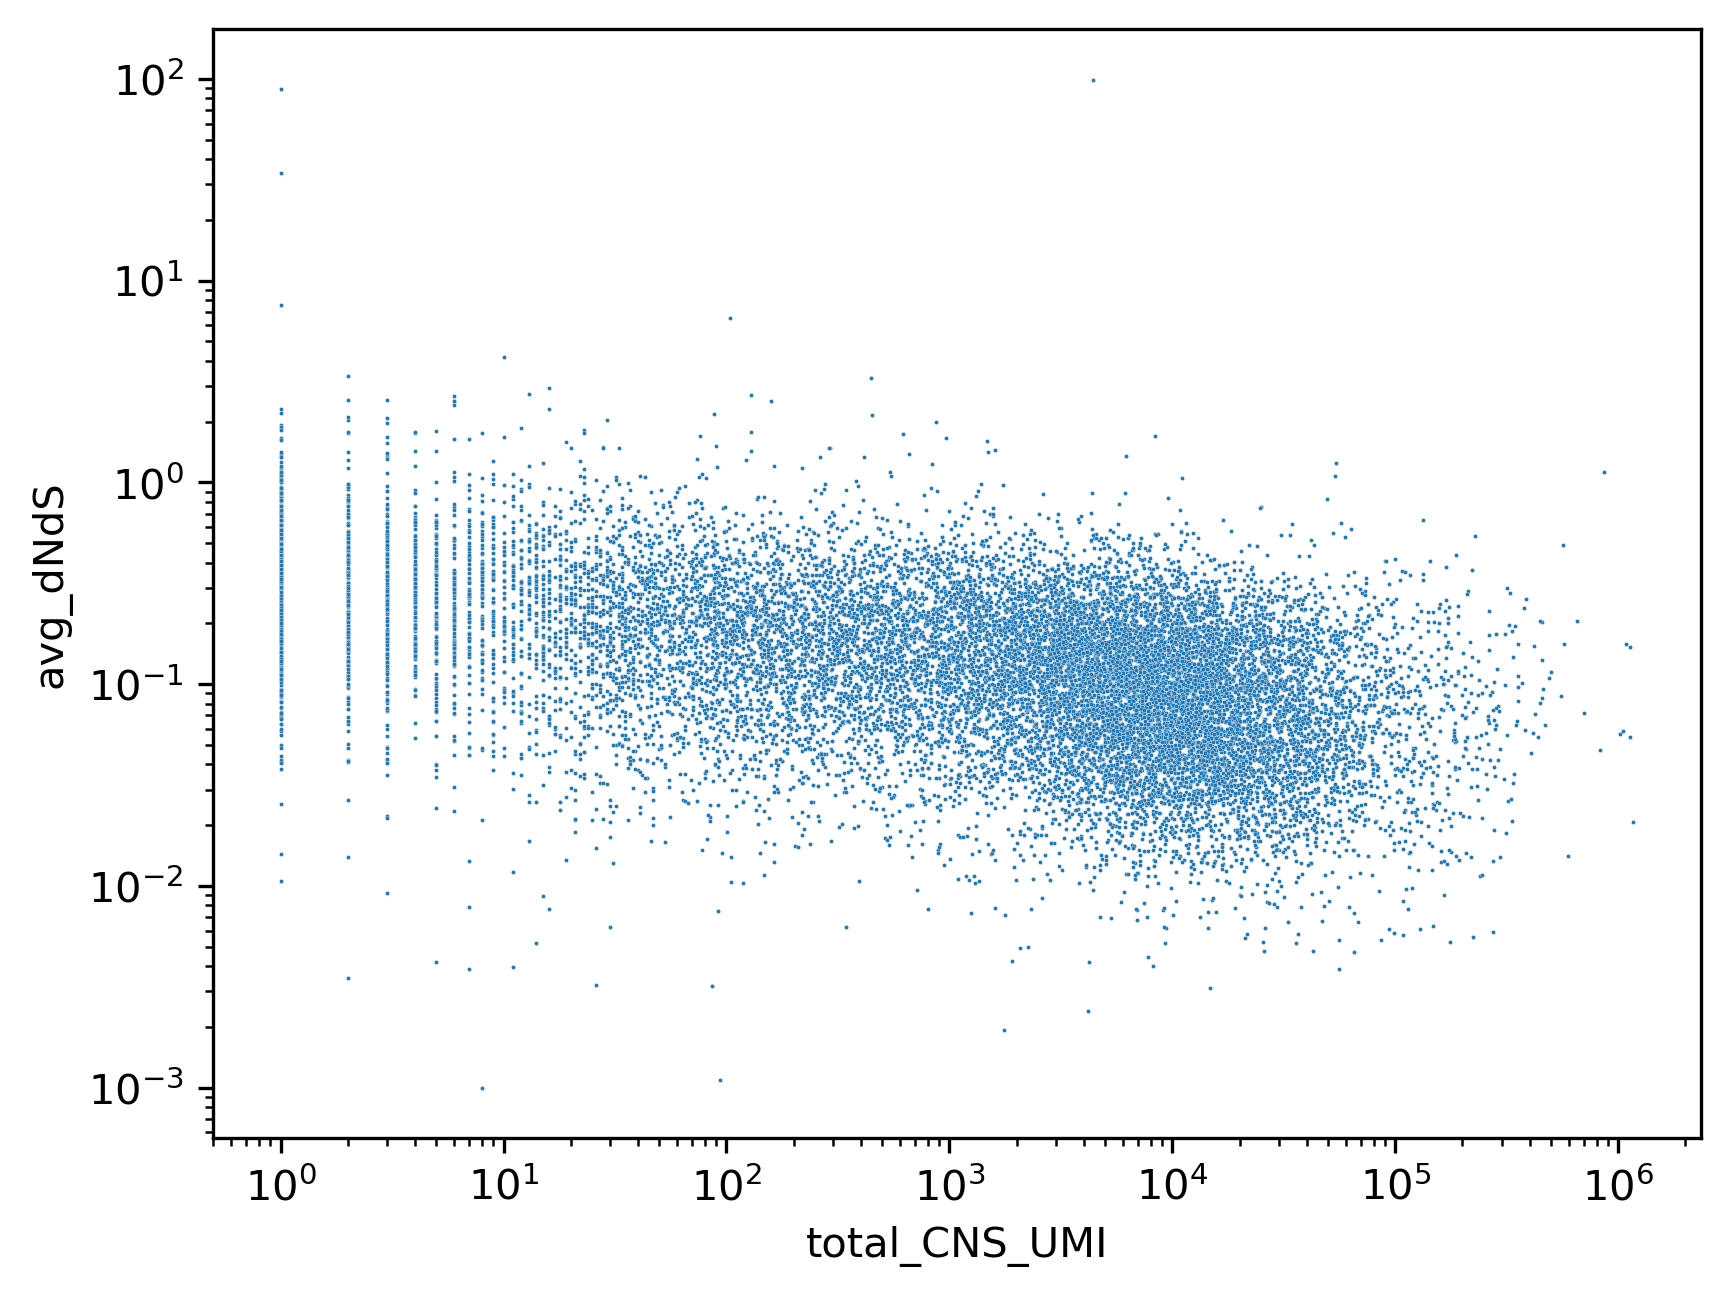

In [385]:
fig,ax=plt.subplots()
ax.set(xscale='log',yscale='log')
sns.scatterplot(data=total_CNS_UMI_df,x='total_CNS_UMI',y='avg_dNdS',s=1)

In [386]:
pg.corr(total_CNS_UMI_df['total_CNS_UMI'],total_CNS_UMI_df['avg_dNdS'],method='spearman')

n         r           CI95%  p-val  power
spearman  17121 -0.456266  [-0.47, -0.44]    0.0    1.0

[None, None]

<AxesSubplot:xlabel='total_CNS_UMI', ylabel='avg_dNdS'>

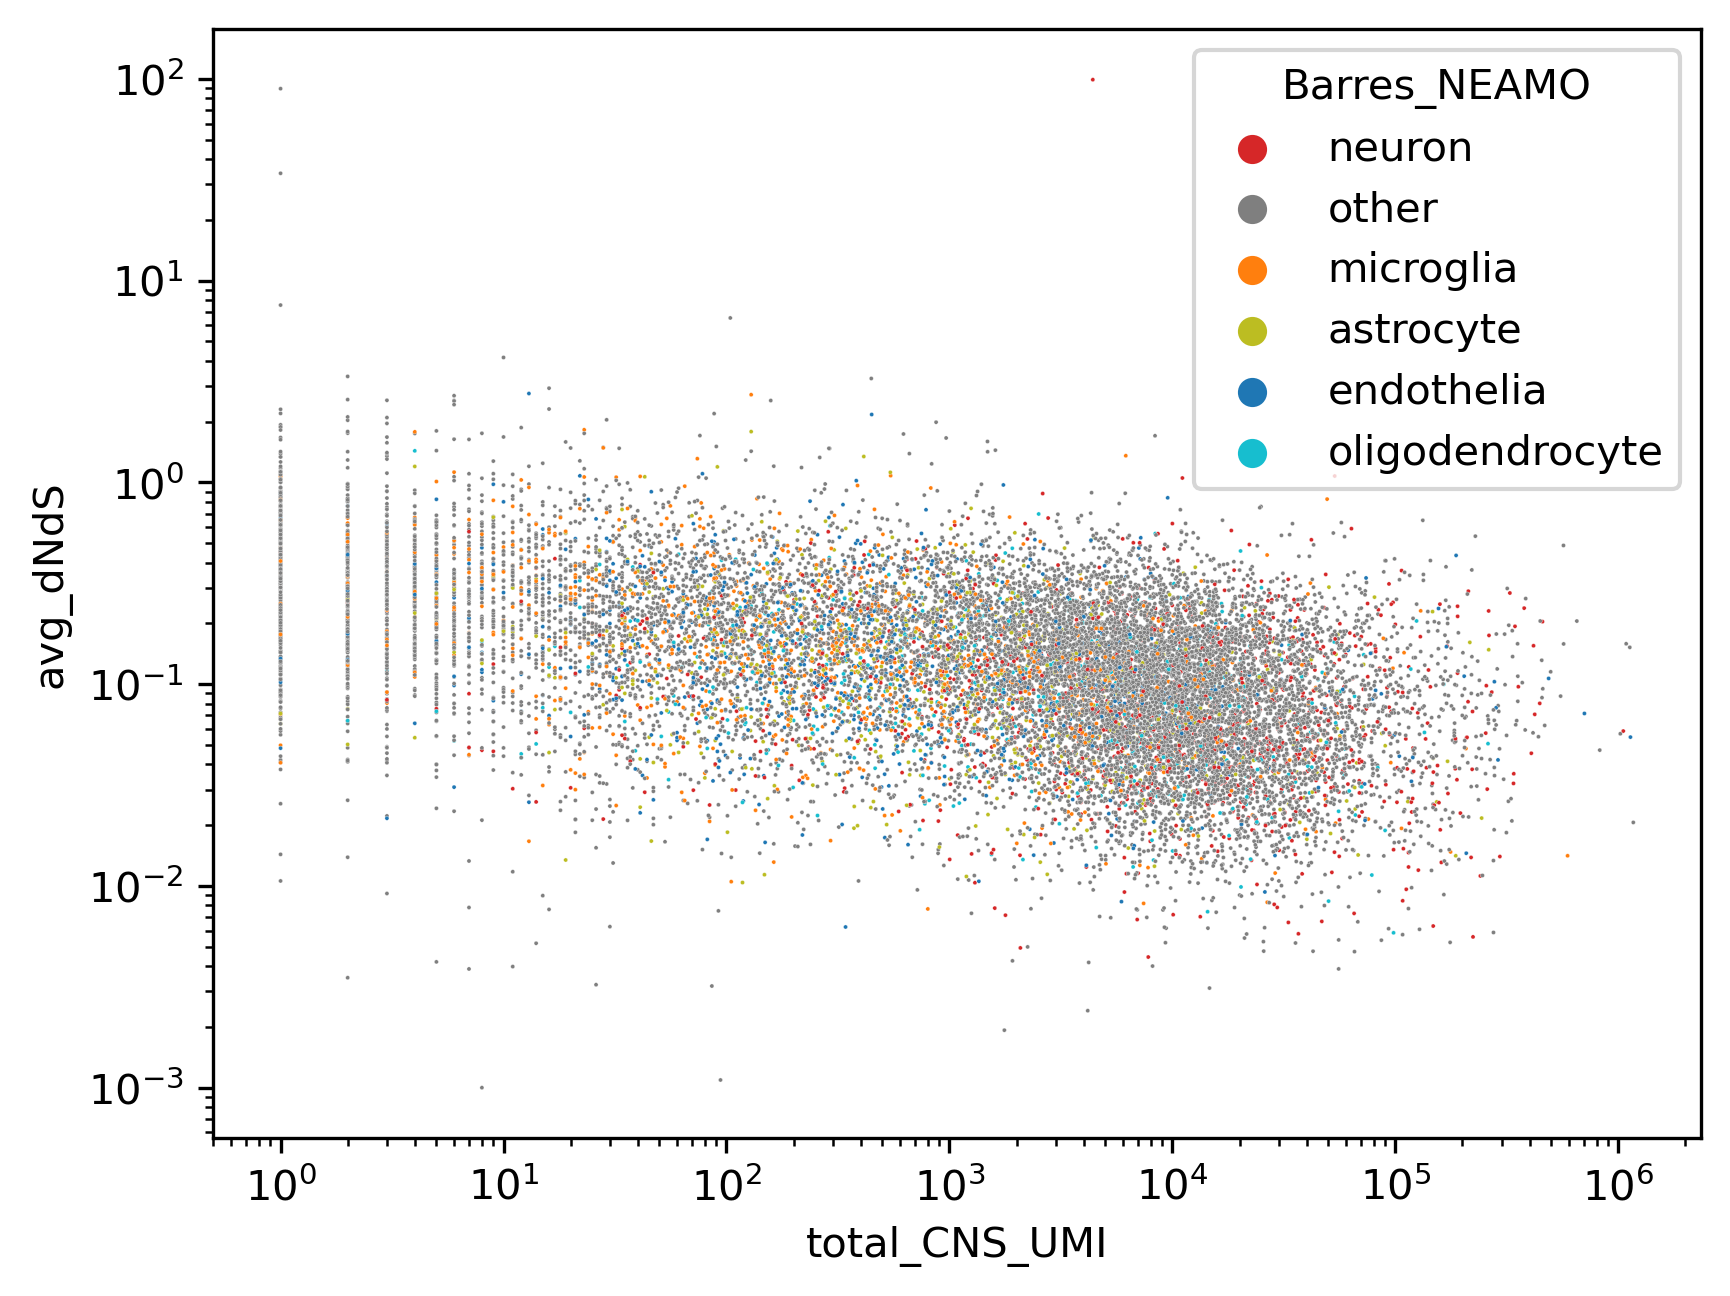

In [387]:
fig,ax=plt.subplots()
ax.set(xscale='log',yscale='log')
sns.scatterplot(data=total_CNS_UMI_df,x='total_CNS_UMI',y='avg_dNdS',hue='Barres_NEAMO',palette=color_NEAMO_dict,s=1)

[None, None]

<AxesSubplot:xlabel='total_CNS_UMI', ylabel='avg_dNdS'>

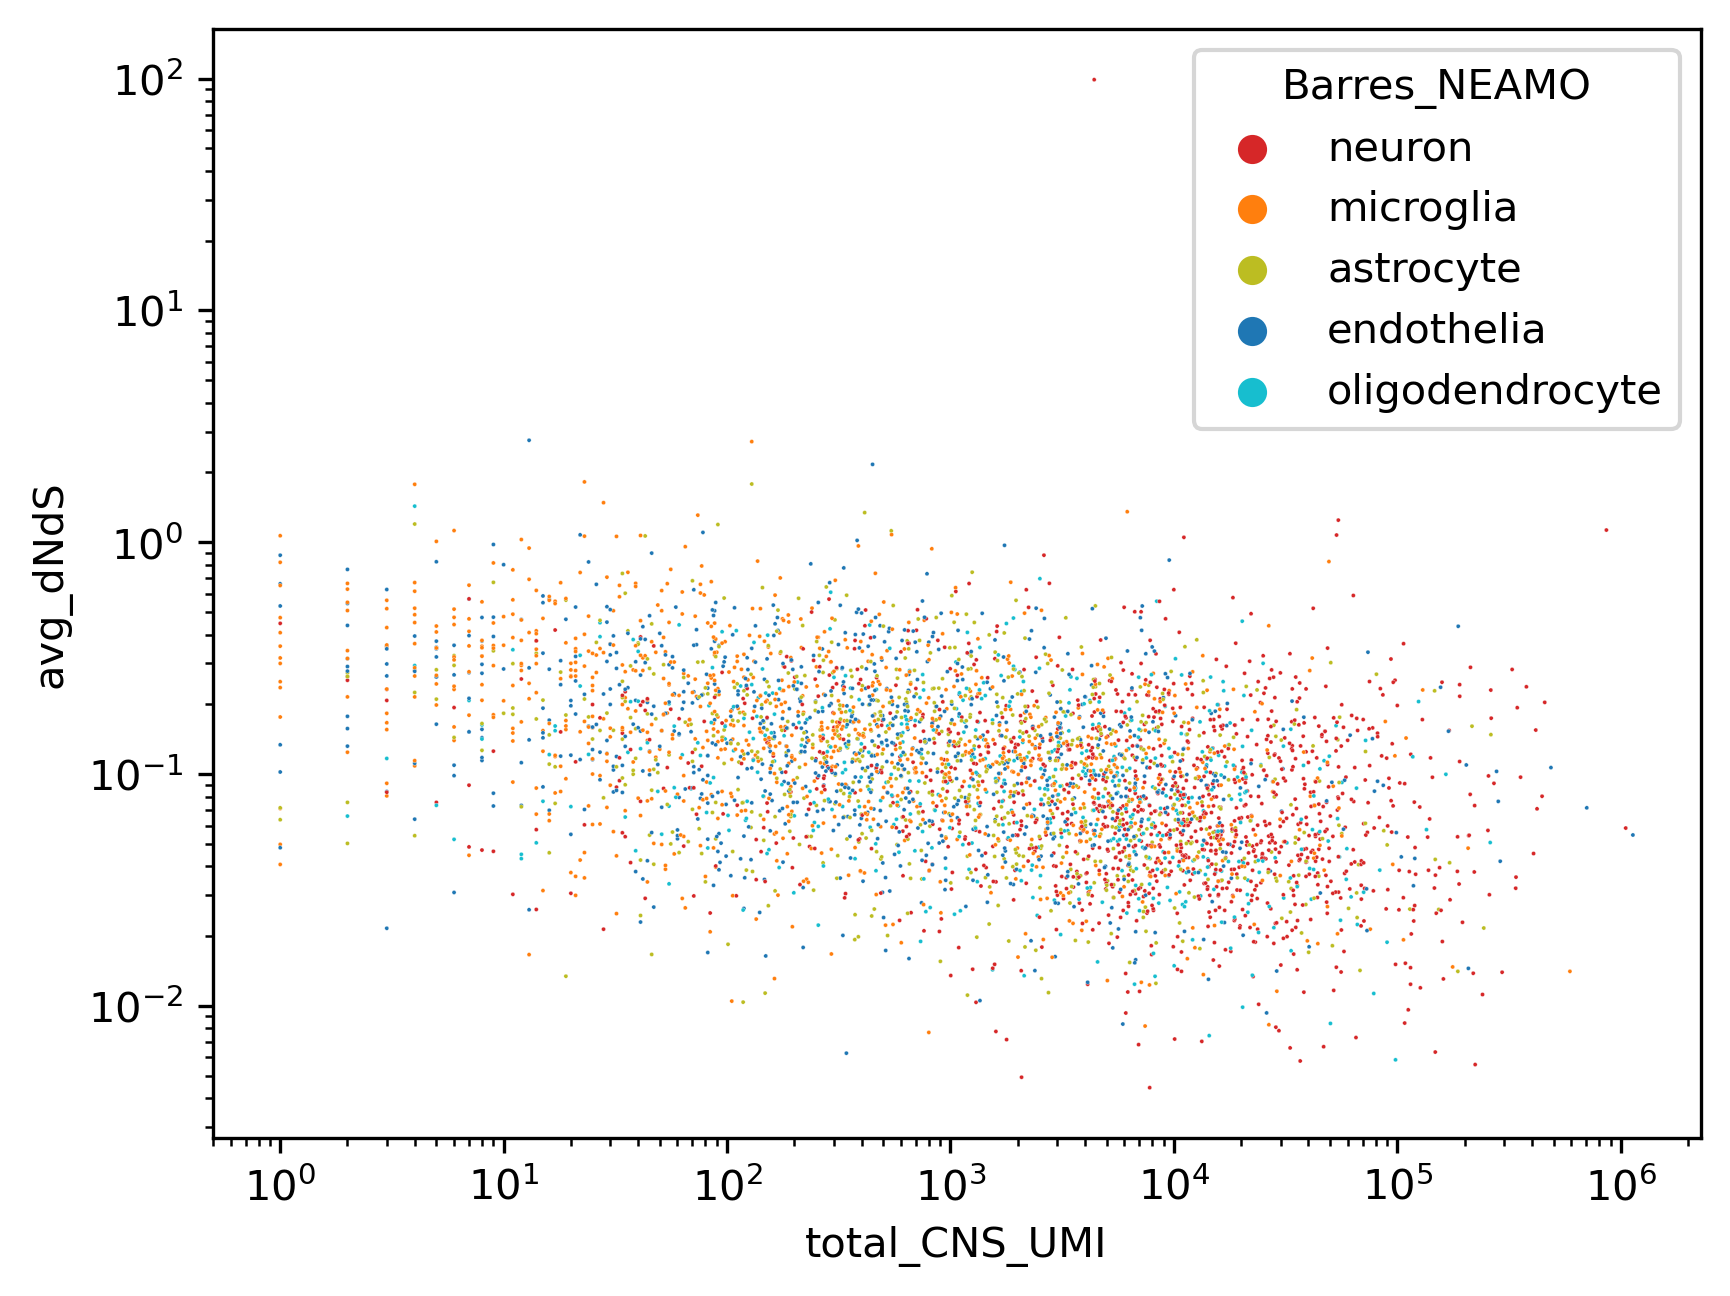

In [388]:
fig,ax=plt.subplots()
ax.set(xscale='log',yscale='log')
sns.scatterplot(data=total_CNS_UMI_df[total_CNS_UMI_df['Barres_NEAMO']!='other'],x='total_CNS_UMI',y='avg_dNdS',hue='Barres_NEAMO',palette=color_NEAMO_dict,s=1)

In [389]:
CNS_UMI_dNdS_corr_dict={}
for celltype in ['endothelia', 'astrocyte', 'neuron', 'microglia', 'oligodendrocyte']:
    df = total_CNS_UMI_df[total_CNS_UMI_df['Barres_NEAMO']==celltype]
    print(celltype)
    pg.corr(df['total_CNS_UMI'],df['avg_dNdS'],method='spearman')
    CNS_UMI_dNdS_corr_dict[celltype]=pg.corr(df['total_CNS_UMI'],df['avg_dNdS'],method='spearman')

endothelia


n         r           CI95%         p-val  power
spearman  926 -0.367565  [-0.42, -0.31]  5.345737e-31    1.0

astrocyte


n         r          CI95%         p-val  power
spearman  821 -0.356693  [-0.41, -0.3]  4.873233e-26    1.0

neuron


n         r           CI95%         p-val  power
spearman  1293 -0.230052  [-0.28, -0.18]  5.434977e-17    1.0

microglia


n         r           CI95%         p-val  power
spearman  1042 -0.475965  [-0.52, -0.43]  5.025134e-60    1.0

oligodendrocyte


n         r           CI95%         p-val  power
spearman  520 -0.362264  [-0.43, -0.29]  1.431573e-17    1.0

In [390]:
for (celltype1, celltype2) in combinations(['endothelia', 'astrocyte', 'neuron', 'microglia', 'oligodendrocyte'],r=2):
    r1 = CNS_UMI_dNdS_corr_dict[celltype1]['r'][0]
    r2 = CNS_UMI_dNdS_corr_dict[celltype2]['r'][0]
    n1 = CNS_UMI_dNdS_corr_dict[celltype1]['n'][0]
    n2 = CNS_UMI_dNdS_corr_dict[celltype2]['n'][0]
    z, p = independent_corr(r1=r1,r2=r2,n1=n1,n2=n2)
    print(f"{celltype1} vs {celltype2}: z={z}, p={p}")

endothelia vs astrocyte: z=0.26058376756217977, p=0.7944135089129947
endothelia vs neuron: z=3.5108942636695, p=0.000446601999078311
endothelia vs microglia: z=2.921637115856457, p=0.003481969714870692
endothelia vs oligodendrocyte: z=0.11131573121646006, p=0.9113659812257033
astrocyte vs neuron: z=3.1065173329294664, p=0.001893052102780901
astrocyte vs microglia: z=3.09482858655008, p=0.0019692667064479252
astrocyte vs oligodendrocyte: z=0.11387944921108839, p=0.9093333567264257
neuron vs microglia: z=6.801224806256173, p=1.0373257808282688e-11
neuron vs oligodendrocyte: z=2.790385100433691, p=0.005264538234572402
microglia vs oligodendrocyte: z=2.568977369717818, p=0.01019991182117308


### Title

In [ ]:
# TaxonomyRank1_list = np.unique(agg.ca.TaxonomyRank1).tolist()

In [203]:
np.unique(agg.ca.TaxonomyRank2).tolist()

['CNS glia',
 'CNS neurons',
 'Immune cells',
 'Neural crest-like glia',
 'PNS neurons',
 'Vascular cells']

In [205]:
np.unique(agg.ca.TaxonomyRank4).tolist()

['Astrocytes',
 'Cerebellum neurons',
 'Cholinergic and monoaminergic neurons',
 'Choroid epithelial cells',
 'Dentate gyrus granule neurons',
 'Dentate gyrus radial glia-like cells',
 'Di- and mesencephalon excitatory neurons',
 'Di- and mesencephalon inhibitory neurons',
 'Enteric glia',
 'Enteric neurons',
 'Ependymal cells',
 'Glutamatergic neuroblasts',
 'Hindbrain neurons',
 'Microglia',
 'Non-glutamatergic neuroblasts',
 'Olfactory ensheathing cells',
 'Olfactory inhibitory neurons',
 'Oligodendrocyte precursor cells',
 'Oligodendrocytes',
 'Peptidergic neurons',
 'Pericytes',
 'Peripheral sensory neurofilament neurons',
 'Peripheral sensory non-peptidergic neurons',
 'Peripheral sensory peptidergic neurons',
 'Perivascular macrophages',
 'Satellite glia',
 'Schwann cells',
 'Spinal cord excitatory neurons',
 'Spinal cord inhibitory neurons',
 'Subcommissural organ hypendymal cells',
 'Subventricular zone radial glia-like cells',
 'Sympathetic cholinergic neurons',
 'Sympathetic

### Excitable vs Non-excitable in the entire nervous system

In [487]:
# Clusters, excluding linhe_class == 'other', are either excitable or not
excitable_list = ['enteric_neuron','exc_neuron','excitable','inh_neuron','mix_neuron','neuroblasts','pns_neuron']
non_excitable_list = ['PNS_glia','endothelia','enteric_glia','glia','immune']

In [491]:
excitable_cluster_list = cluster_description_df[cluster_description_df.linhe_class.isin(excitable_list)]['Cluster name'].to_list()

In [492]:
non_excitable_cluster_list = cluster_description_df[cluster_description_df.linhe_class.isin(non_excitable_list)]['Cluster name'].to_list()

In [499]:
len(excitable_cluster_list)

218

In [500]:
len(non_excitable_cluster_list)

38

##### Using exclusive principles with trinaries

In [493]:
# excitable cell-specific genes
# genes that are expressed in any excitable cells clusters in the entire nervous system
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, excitable_cluster_list)]>=0.9,axis=1))
# genes not expressed in any non-excitable cell clusters in the entire nervous system
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, non_excitable_cluster_list)]<=0.1,axis=1))

# Accession ID of neuron-specific genes
accession_list = agg.ra.Accession[(condition1&condition2)]
cell_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_list)].copy(deep=True)
gene_num = cell_df.shape[0]
exc_df = cell_df.copy(deep=True)
median_dNdS=np.median(cell_df['avg_dNdS'])

print(f"excitable cell-specific genes with dN/dS: {gene_num} genes")
print(f"excitable cell-specific genes median dN/dS:{median_dNdS}")

excitable cell-specific genes with dN/dS: 2635 genes
excitable cell-specific genes median dN/dS:0.0946070299147409


In [494]:
# non-excitable cell-specific genes
# genes that are expressed in any excitable cells clusters in the entire nervous system
condition1=(np.any(agg['trinaries'][:,np.isin(agg.ca.ClusterName, non_excitable_cluster_list)]>=0.9,axis=1))
# genes not expressed in any non-excitable cell clusters in the entire nervous system
condition2=(np.all(agg['trinaries'][:,np.isin(agg.ca.ClusterName, excitable_cluster_list)]<=0.1,axis=1))

# Accession ID of neuron-specific genes
accession_list = agg.ra.Accession[(condition1&condition2)]
cell_df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_list)].copy(deep=True)
gene_num = cell_df.shape[0]
non_exc_df = cell_df.copy(deep=True)
median_dNdS=np.median(cell_df['avg_dNdS'])

print(f"non-excitable cell-specific genes with dN/dS: {gene_num} genes")
print(f"non-excitable cell-specific genes median dN/dS:{median_dNdS}")

non-excitable cell-specific genes with dN/dS: 0 genes
non-excitable cell-specific genes median dN/dS:nan


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Again, no non-excitable cell-specific genes detected with this method

#### Four-fold enrichment defined excitable vs non-excitable specifically enriched genes

In [495]:
excitable_rows_list = []
non_excitable_rows_list = []

for Accession in all_Accession_list:
    # Check if we have dN/dS value for that gene
    if Accession in avg_dNdS_df.index:

        # define expression level as average expression across corresponding clusters
        excitable_mean = np.mean(agg[agg.ra.Accession==Accession,:][:,np.isin(agg.ca.ClusterName, excitable_cluster_list)])
        non_excitable_mean = np.mean(agg[agg.ra.Accession==Accession,:][:,np.isin(agg.ca.ClusterName, non_excitable_cluster_list)])

        # dN/dS, averaged across 92 species, for that gene
        avg_dNdS = avg_dNdS_df.loc[Accession,'avg_dNdS']
        gene_name = avg_dNdS_df.loc[Accession,'Gene name']

        # define cell type-specific genes as genes 
        # with greater than four times expression than 
        # the average of the other two cell types
        if excitable_mean > non_excitable_mean * 4:
            excitable_rows_list.append(
                {
                    'Accession':Accession,
                    'Gene_name':gene_name,
                    'avg_dNdS':avg_dNdS,
                    'excitability':'excitable'
                }
            )

        if non_excitable_mean > excitable_mean * 4:
            non_excitable_rows_list.append(
                {
                    'Accession':Accession,
                    'Gene_name':gene_name,
                    'avg_dNdS':avg_dNdS,
                    'excitability':'non_excitable'
                }
            )

# Concatenate NEG and convert to dataframe
excitability_list = excitable_rows_list+non_excitable_rows_list
excitability_df = pd.DataFrame(excitability_list)

In [497]:
len(excitable_rows_list)

4666

In [498]:
len(non_excitable_list)

5

This is too little genes to compare. 

### Cluster-enriched genes

In [294]:
np.median(agg['enrichment_q'][:,:])

1.0

(array([[11297.,  1050.,   368., ...,  8980.,  2078.,  3601.],
        [10825.,   791.,   408., ...,  5739.,  1805.,  3172.],
        [ 9776.,  1014.,   597., ...,  2698.,  1388.,  3230.],
        ...,
        [ 8596.,   984.,   495., ...,  8869.,  3200.,  5040.],
        [ 7833.,   946.,   551., ...,  5842.,  2829.,  4610.],
        [ 9544.,   809.,   445., ...,  8426.,  2842.,  5162.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 265 BarContainer objects>)

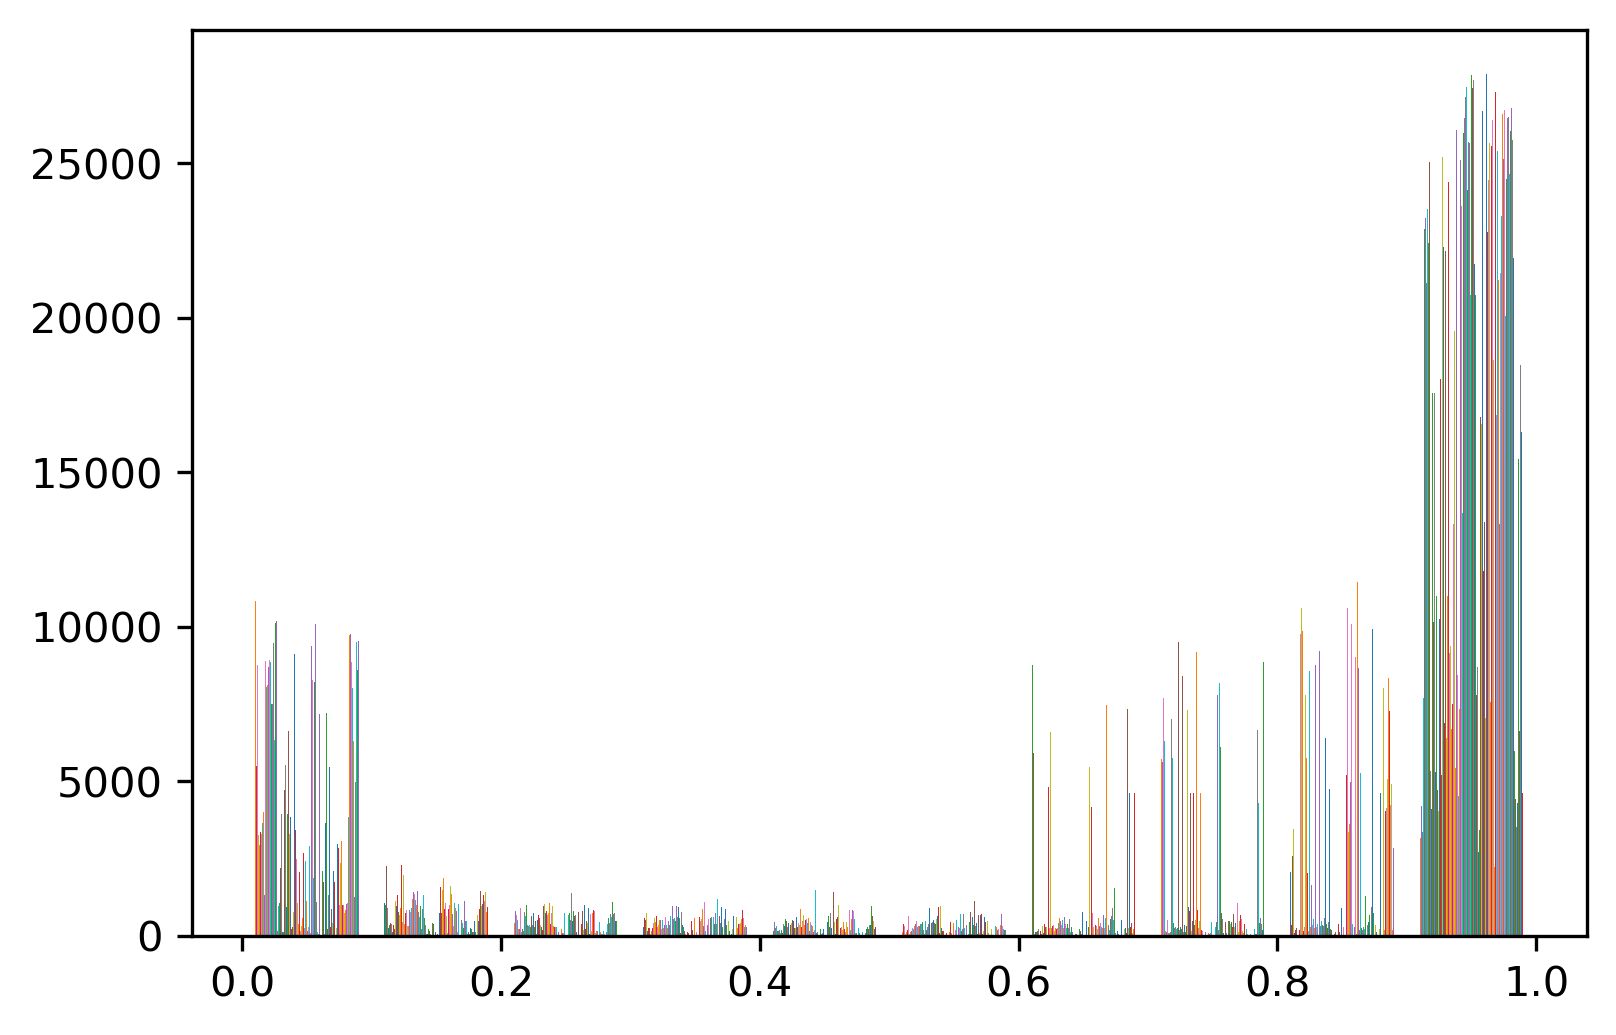

In [295]:
plt.hist(agg['enrichment_q'][:,:])

#### Threshold for enrichment q set at 0.05

In [342]:
cluster_specific_df_list = []
zero_gene_cluster_list = []
zero_dNdS_cluster_list = []
for cluster in all_clusters_list:
    condition1 = (np.any(agg['enrichment_q'][:,agg.ca.ClusterName==cluster]<0.05,axis=1))
    condition2 = (np.all(agg['enrichment_q'][:,agg.ca.ClusterName!=cluster]>=0.05,axis=1))
    accession_list = agg.ra.Accession[condition1&condition2].tolist()
    num_gene = len(accession_list)
    if num_gene >0:
        df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_list)].copy(deep=True)
        df['cluster']=cluster
        if df.shape[0]==0:
            zero_dNdS_cluster_list.append(cluster)
        else:
            cluster_specific_df_list.append(df)
    else:
        zero_gene_cluster_list.append(cluster)
        zero_dNdS_cluster_list.append(cluster)

In [430]:
len(zero_gene_cluster_list)
len(zero_dNdS_cluster_list)

cluster_w_dNdS_list = list(set(all_clusters_list)-set(zero_dNdS_cluster_list))

len(cluster_w_dNdS_list)

In [437]:
cluster_specific_df=pd.concat(cluster_specific_df_list)
cluster_specific_df = cluster_specific_df.merge(cluster_description_df.loc[:,['Cluster name','linhe_class']],left_on='cluster',right_on='Cluster name',how='left')

In [439]:
cluster_specific_df['linhe_CNS_glial_subtype'] = 'not_CNS_glial'
# set microglia color to orange
_list = cluster_description_df[cluster_description_df['Taxonomy_group']=='Microglia']['Cluster name'].to_list()
cluster_specific_df.loc[np.isin(cluster_specific_df['Cluster name'],_list),'linhe_CNS_glial_subtype'] = 'Microglia'
# set astrocyte color to green
_list = cluster_description_df[cluster_description_df['Taxonomy_group']=='Astrocytes']['Cluster name'].to_list()
cluster_specific_df.loc[np.isin(cluster_specific_df['Cluster name'],_list),'linhe_CNS_glial_subtype'] = 'Astrocytes'
# set oligodendrocyte color to cyan
_list = cluster_description_df[np.isin(cluster_description_df['Taxonomy_group'],['Oligodendrocyte precursor cells','Oligodendrocytes'])]['Cluster name'].to_list()
cluster_specific_df.loc[np.isin(cluster_specific_df['Cluster name'],_list),'linhe_CNS_glial_subtype'] = 'Oligodendrocytes'
# set ependymal color to purple
_list = cluster_description_df[cluster_description_df['Taxonomy_group']=='Ependymal cells']['Cluster name'].to_list()
cluster_specific_df.loc[np.isin(cluster_specific_df['Cluster name'],_list),'linhe_CNS_glial_subtype'] = 'Ependymal cells'

In [441]:
np.unique(cluster_specific_df['linhe_CNS_glial_subtype'],return_counts=True)

(array(['Astrocytes', 'Ependymal cells', 'Microglia', 'Oligodendrocytes',
        'not_CNS_glial'], dtype=object),
 array([  5,  44,   6,  10, 439]))

In [433]:
cluster_specific_median_dNdS_dict = {}
for cluster in cluster_w_dNdS_list:
    med_dNdS = np.median(cluster_specific_df[cluster_specific_df['Cluster name']==cluster]['avg_dNdS'])
    cluster_specific_median_dNdS_dict[cluster]=med_dNdS
ranked_cluster_list = []
for (k,v) in sorted(cluster_specific_median_dNdS_dict.items(), key=lambda item: item[1]):
    ranked_cluster_list.append(k)

In [484]:
agg.ca.ClusterName[agg.ca.TaxonomyRank1=='Vascular']

array([], dtype=object)

In [480]:
cluster_specific_df[cluster_specific_df['cluster']=='MEGLU3']

Gene name  avg_dNdS cluster Cluster name linhe_class  \
169   Sult3a1   2.52886  MEGLU3       MEGLU3  exc_neuron   

    linhe_CNS_glial_subtype  
169           not_CNS_glial

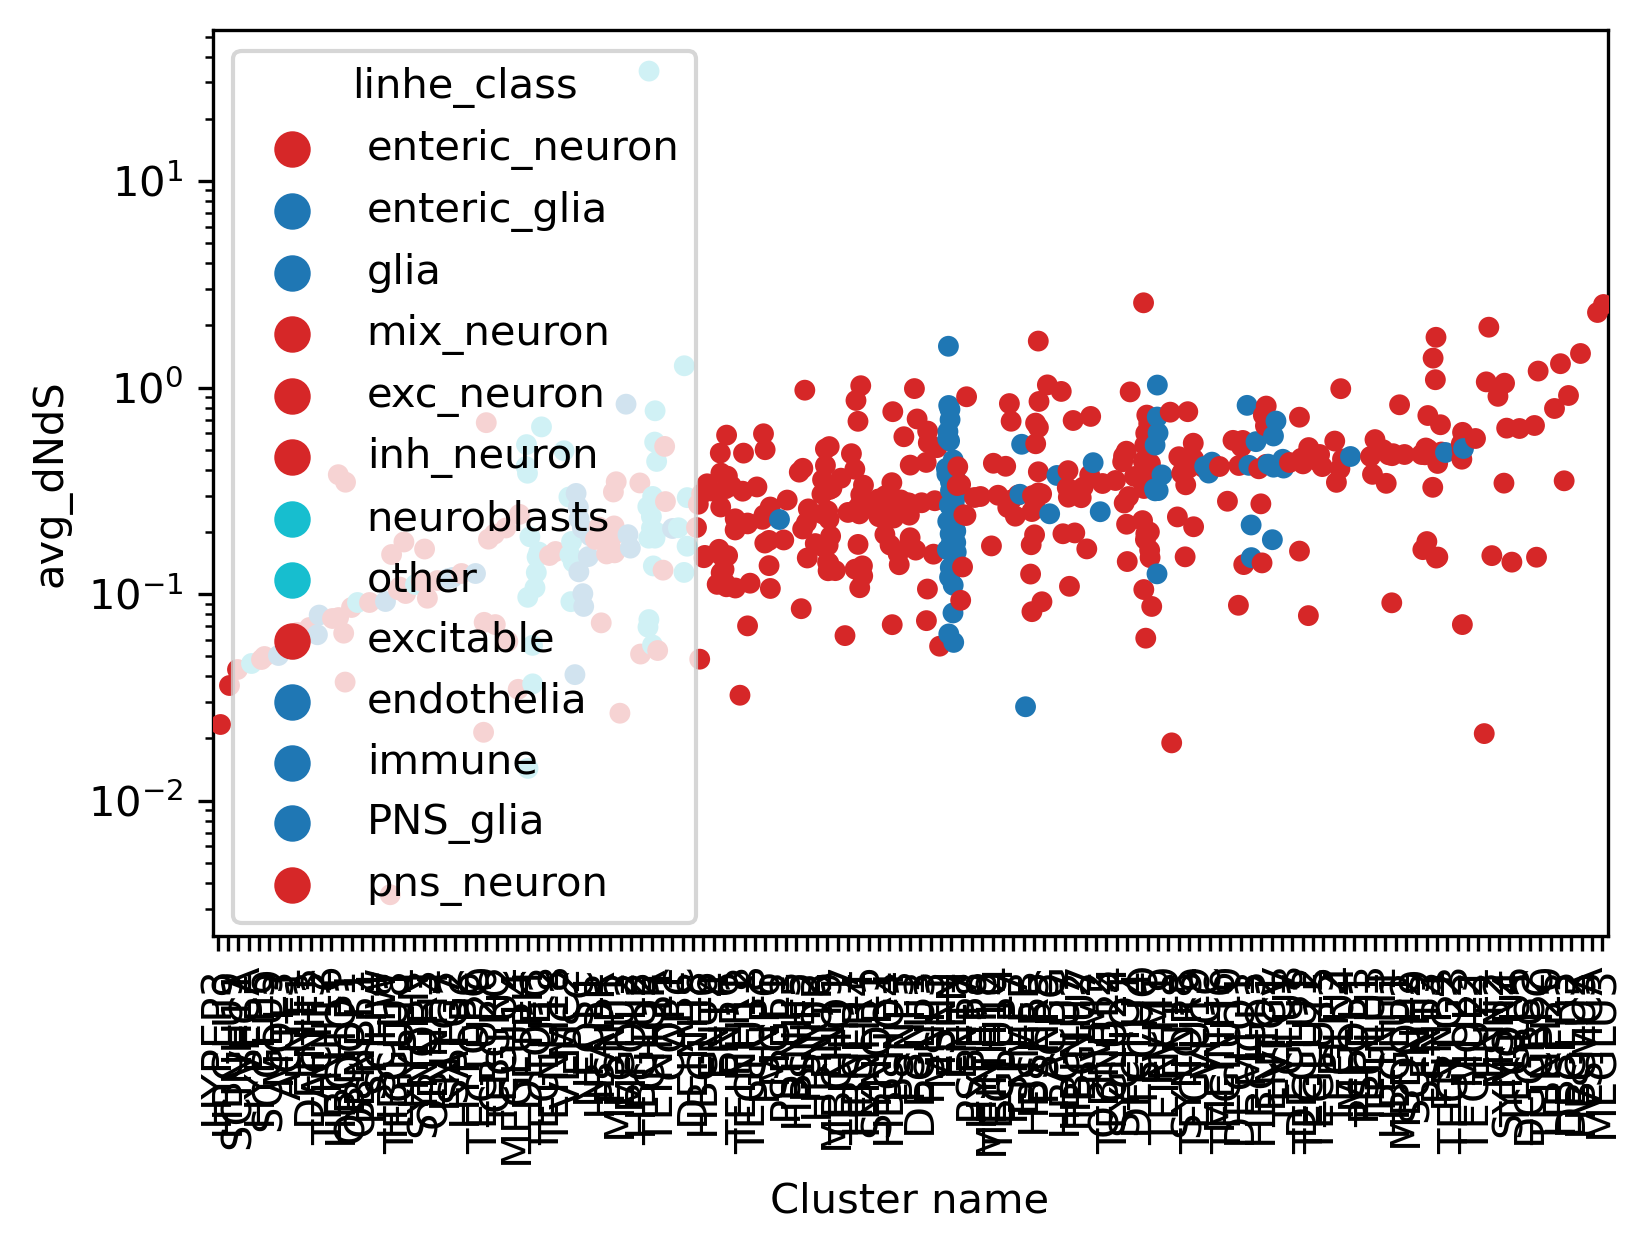

In [443]:
# plt.figure(figsize=(8.5,11))
_ = plt.figure()
# max_dNdS = symbol_dNdS_df.avg_dNdS.max()
# min_dNdS = symbol_dNdS_df.avg_dNdS.min()
_ = sns.stripplot(x='Cluster name',y='avg_dNdS',data=cluster_specific_df,order=ranked_cluster_list,jitter=0.5,hue='linhe_class',palette=color_excitable_dict)
_ = plt.gca().set_yscale('log')
_ = plt.xticks(rotation=90)

<Figure size 1800x1200 with 0 Axes>

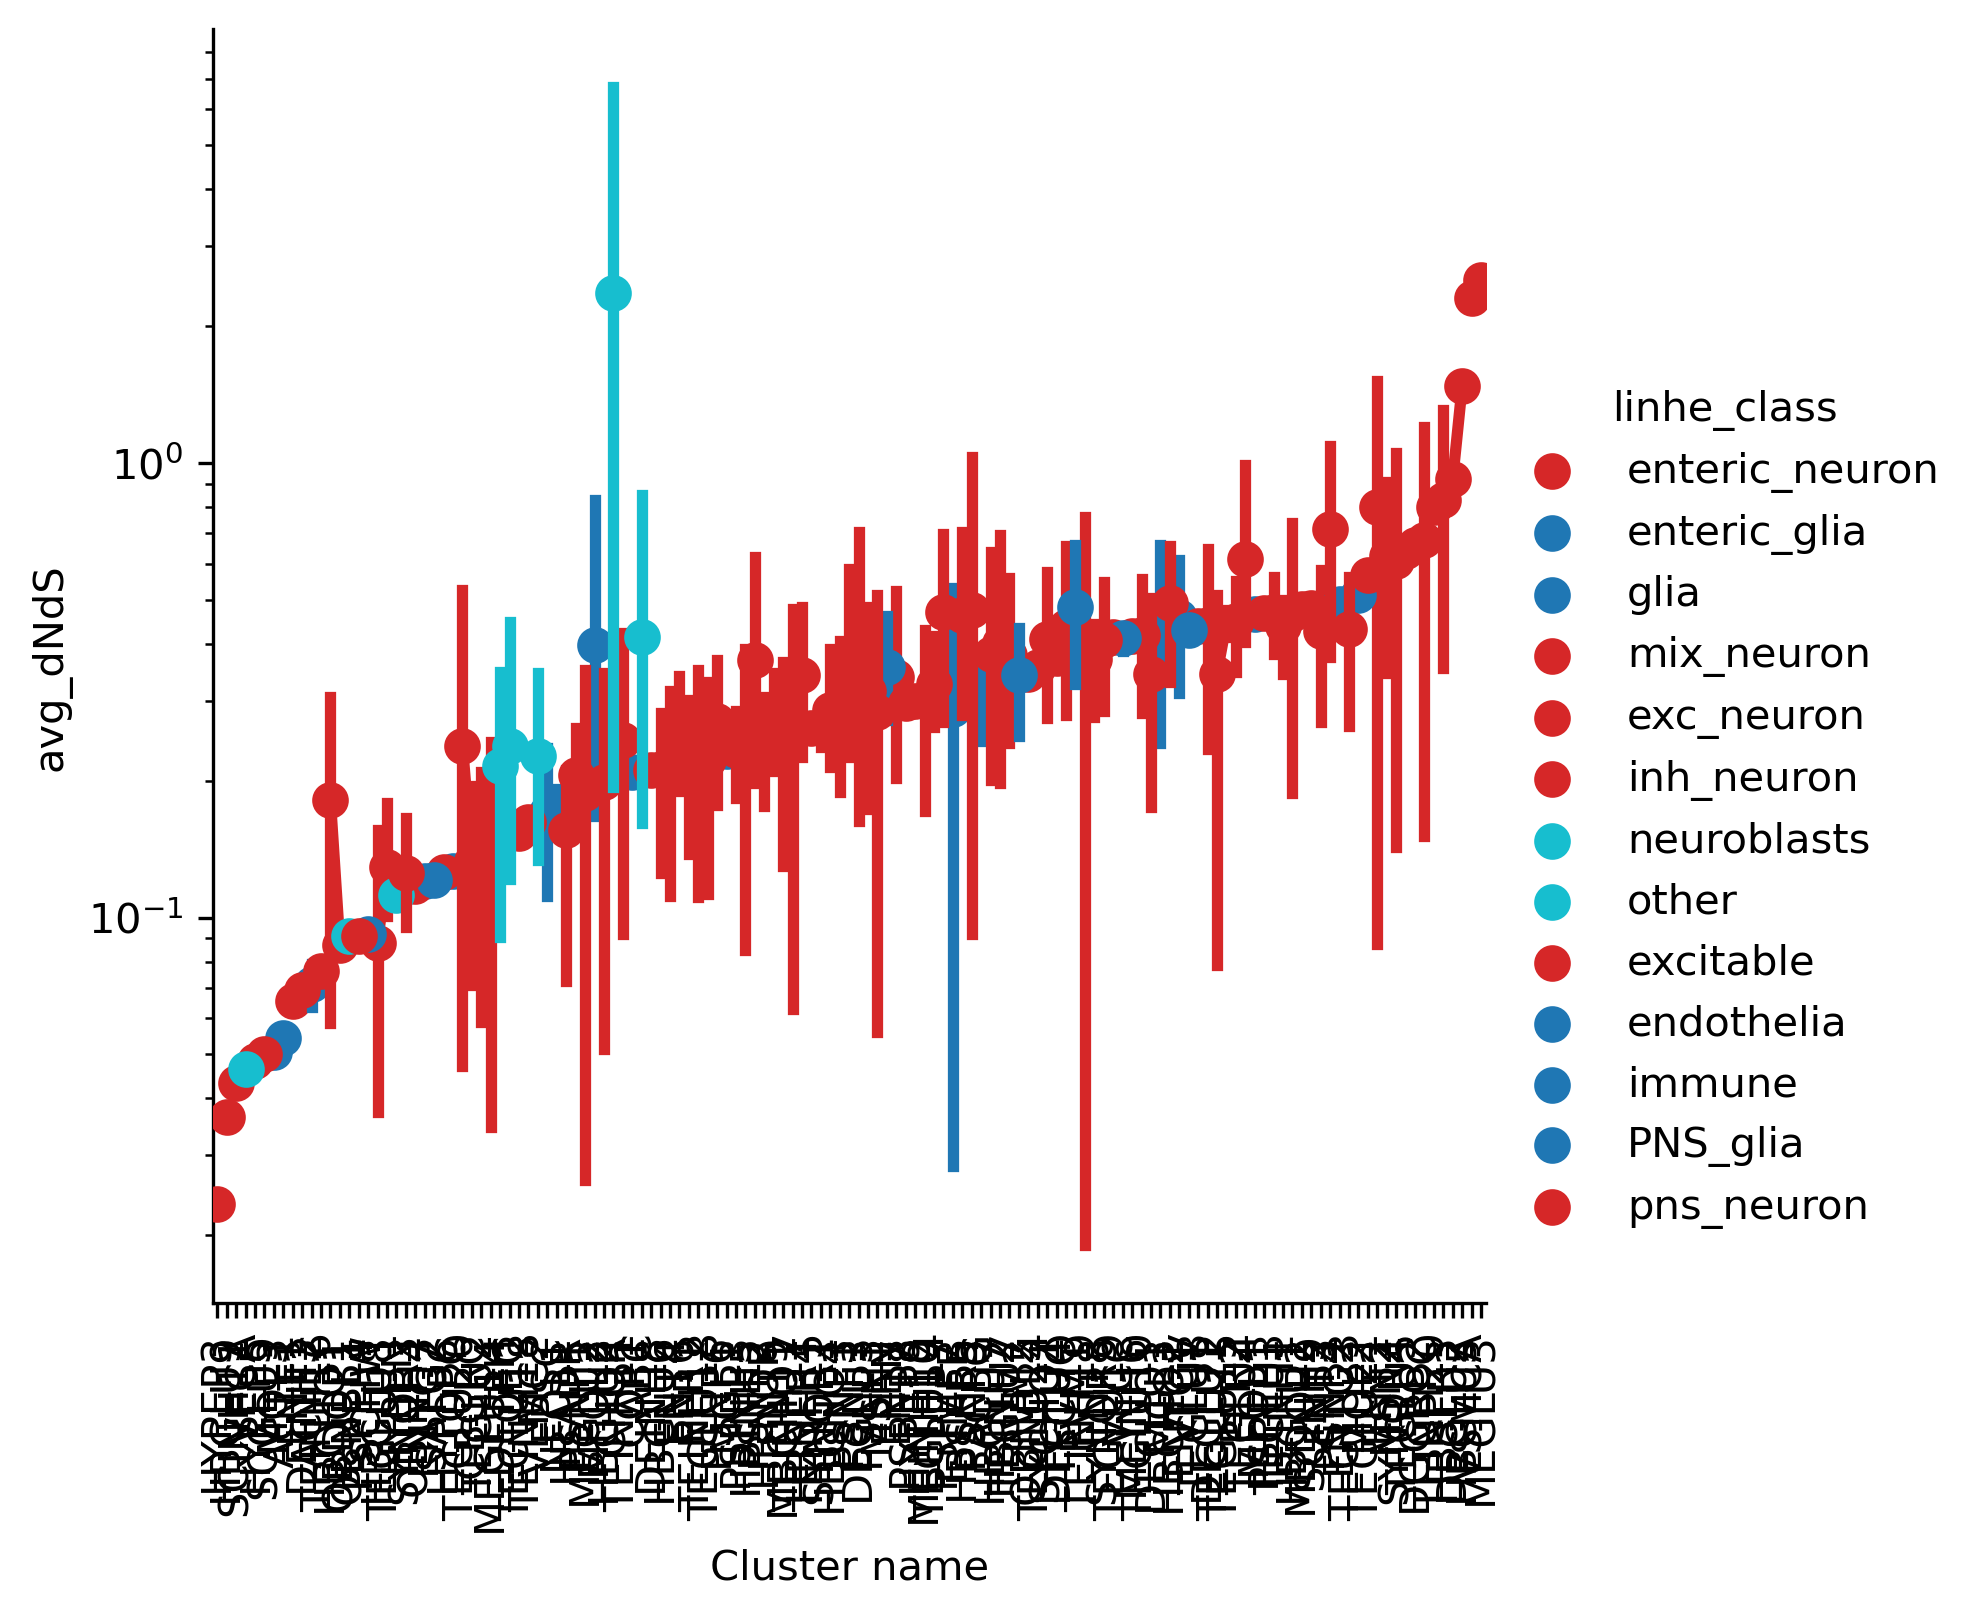

In [445]:
_ = plt.figure()
_ = sns.catplot(data=cluster_specific_df,x='Cluster name',y='avg_dNdS',hue='linhe_class',palette=color_excitable_dict,order=ranked_cluster_list,kind='point')
_ = plt.gca().set_yscale('log')
_ = plt.xticks(rotation=90)

<Figure size 1800x1200 with 0 Axes>

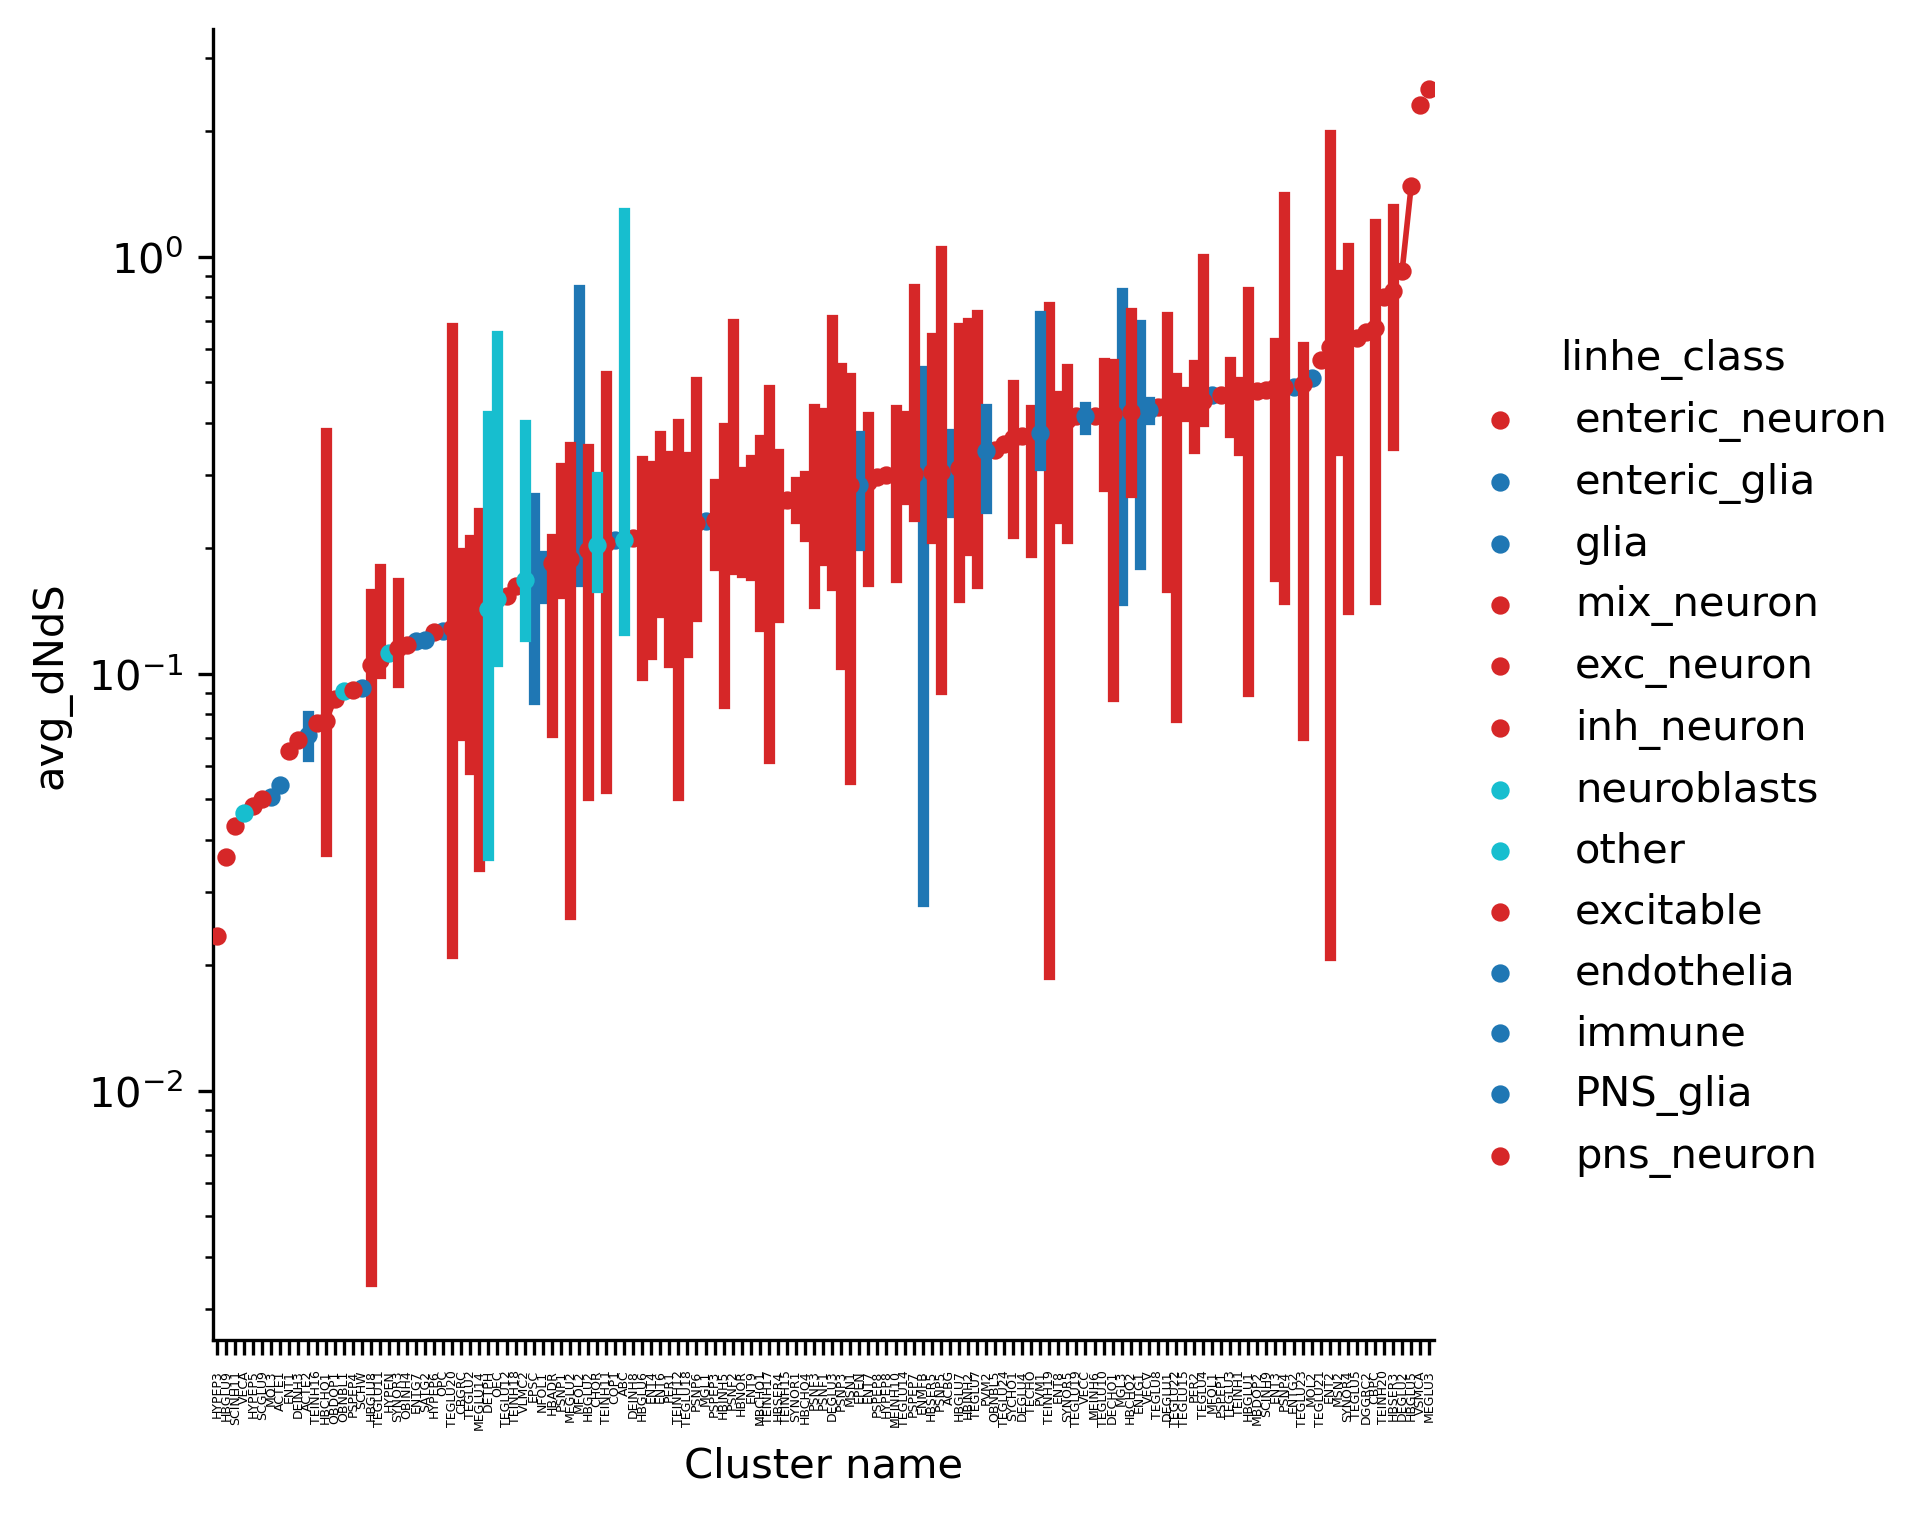

In [462]:
_ = plt.figure()
catplot = sns.catplot(data=cluster_specific_df,x='Cluster name',y='avg_dNdS',hue='linhe_class',palette=color_excitable_dict,order=ranked_cluster_list,estimator=np.median,kind='point',errorbar='ci',scale=0.5)
_ = plt.gca().set_yscale('log')
# _ = plt.rc('xtick',labelsize=3)
_ = plt.xticks(rotation=90)

<Figure size 1800x1200 with 0 Axes>

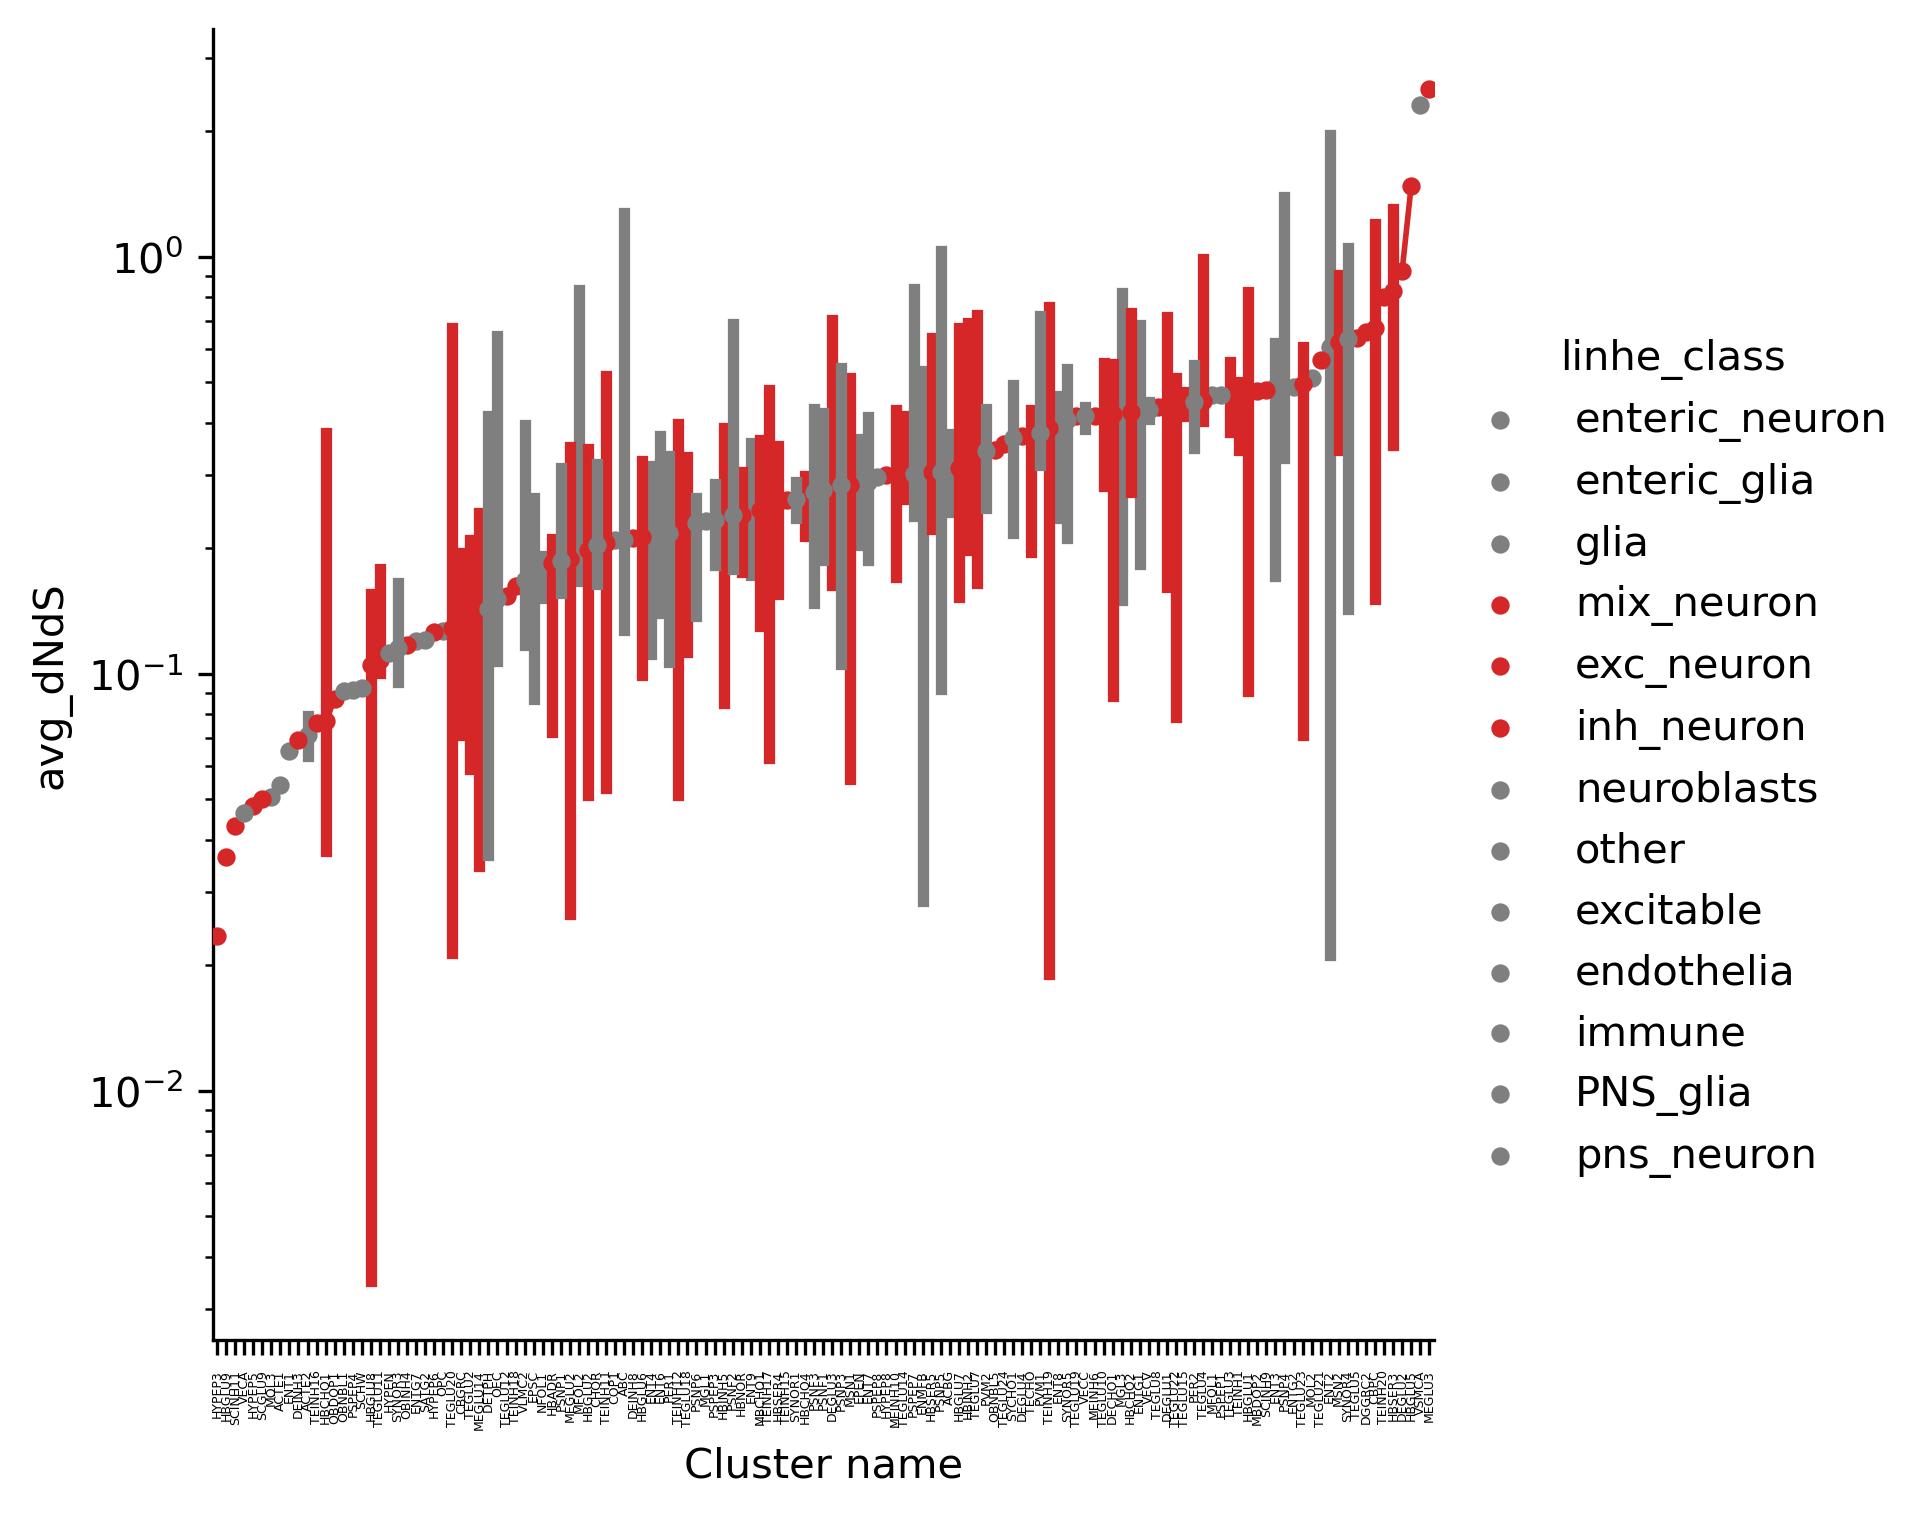

In [463]:
_ = plt.figure()
catplot = sns.catplot(data=cluster_specific_df,x='Cluster name',y='avg_dNdS',hue='linhe_class',palette=color_CNS_neuron_dict,order=ranked_cluster_list,estimator=np.median,kind='point',errorbar='ci',scale=0.5)
_ = plt.gca().set_yscale('log')
# _ = plt.rc('xtick',labelsize=3)
_ = plt.xticks(rotation=90)

<Figure size 1800x1200 with 0 Axes>

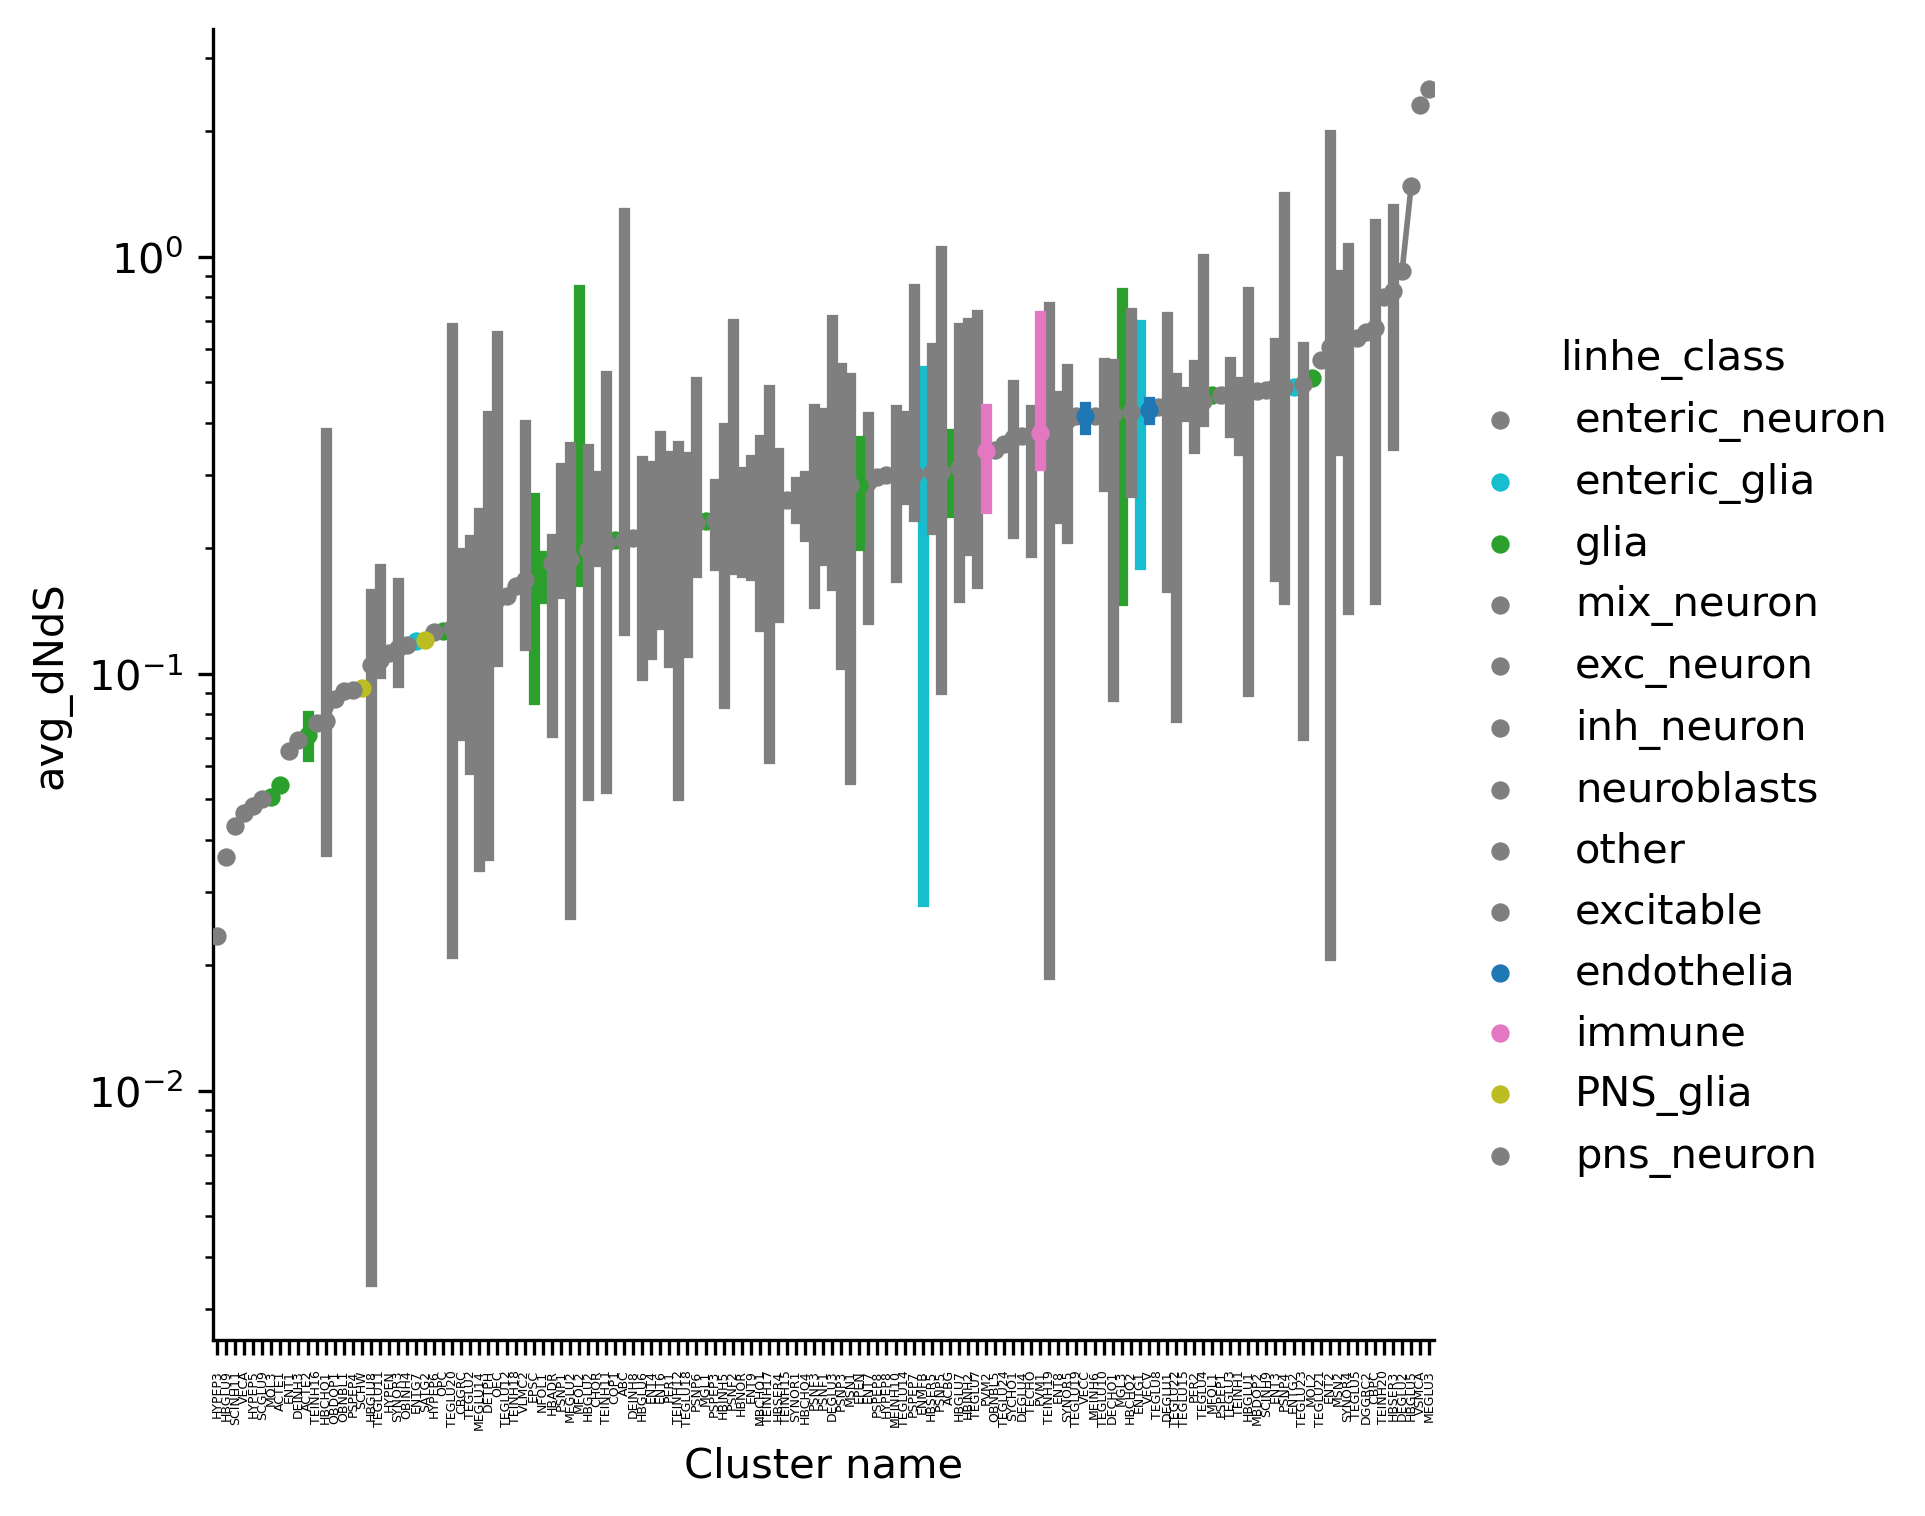

In [464]:
_ = plt.figure()
catplot = sns.catplot(data=cluster_specific_df,x='Cluster name',y='avg_dNdS',hue='linhe_class',palette=color_glia_endo_immune_dict,order=ranked_cluster_list,estimator=np.median,kind='point',errorbar='ci',scale=0.5)
_ = plt.gca().set_yscale('log')
# _ = plt.rc('xtick',labelsize=3)
_ = plt.xticks(rotation=90)

#### Threshold of enrichment q set at 0.1

In [465]:
ten_percent_FDR_cluster_specific_df_list = []
ten_percent_FDR_zero_gene_cluster_list = []
ten_percent_FDR_zero_dNdS_cluster_list = []
for cluster in all_clusters_list:
    condition1 = (np.any(agg['enrichment_q'][:,agg.ca.ClusterName==cluster]<0.1,axis=1))
    condition2 = (np.all(agg['enrichment_q'][:,agg.ca.ClusterName!=cluster]>=0.1,axis=1))
    accession_list = agg.ra.Accession[condition1&condition2].tolist()
    num_gene = len(accession_list)
    if num_gene >0:
        df = avg_dNdS_df[avg_dNdS_df.index.isin(accession_list)].copy(deep=True)
        df['cluster']=cluster
        if df.shape[0]==0:
            ten_percent_FDR_zero_dNdS_cluster_list.append(cluster)
        else:
            ten_percent_FDR_cluster_specific_df_list.append(df)
    else:
        ten_percent_FDR_zero_gene_cluster_list.append(cluster)
        ten_percent_FDR_zero_dNdS_cluster_list.append(cluster)

In [466]:
len(ten_percent_FDR_zero_gene_cluster_list)
len(ten_percent_FDR_zero_dNdS_cluster_list)

ten_percent_FDR_cluster_w_dNdS_list = list(set(all_clusters_list)-set(ten_percent_FDR_zero_dNdS_cluster_list))

len(ten_percent_FDR_cluster_w_dNdS_list)

96

133

132

In [467]:
ten_percent_FDR_cluster_specific_df=pd.concat(ten_percent_FDR_cluster_specific_df_list)
ten_percent_FDR_cluster_specific_df = ten_percent_FDR_cluster_specific_df.merge(cluster_description_df.loc[:,['Cluster name','linhe_class']],left_on='cluster',right_on='Cluster name',how='left')

In [469]:
ten_percent_FDR_cluster_specific_df['linhe_CNS_glial_subtype'] = 'not_CNS_glial'
# set microglia color to orange
_list = cluster_description_df[cluster_description_df['Taxonomy_group']=='Microglia']['Cluster name'].to_list()
ten_percent_FDR_cluster_specific_df.loc[np.isin(ten_percent_FDR_cluster_specific_df['Cluster name'],_list),'linhe_CNS_glial_subtype'] = 'Microglia'
# set astrocyte color to green
_list = cluster_description_df[cluster_description_df['Taxonomy_group']=='Astrocytes']['Cluster name'].to_list()
ten_percent_FDR_cluster_specific_df.loc[np.isin(ten_percent_FDR_cluster_specific_df['Cluster name'],_list),'linhe_CNS_glial_subtype'] = 'Astrocytes'
# set oligodendrocyte color to cyan
_list = cluster_description_df[np.isin(cluster_description_df['Taxonomy_group'],['Oligodendrocyte precursor cells','Oligodendrocytes'])]['Cluster name'].to_list()
ten_percent_FDR_cluster_specific_df.loc[np.isin(ten_percent_FDR_cluster_specific_df['Cluster name'],_list),'linhe_CNS_glial_subtype'] = 'Oligodendrocytes'
# set ependymal color to purple
_list = cluster_description_df[cluster_description_df['Taxonomy_group']=='Ependymal cells']['Cluster name'].to_list()
ten_percent_FDR_cluster_specific_df.loc[np.isin(ten_percent_FDR_cluster_specific_df['Cluster name'],_list),'linhe_CNS_glial_subtype'] = 'Ependymal cells'

In [470]:
ten_percent_FDR_cluster_specific_median_dNdS_dict = {}
for cluster in ten_percent_FDR_cluster_w_dNdS_list:
    med_dNdS = np.median(ten_percent_FDR_cluster_specific_df[ten_percent_FDR_cluster_specific_df['Cluster name']==cluster]['avg_dNdS'])
    ten_percent_FDR_cluster_specific_median_dNdS_dict[cluster]=med_dNdS
ten_percent_FDR_ranked_cluster_list = []
for (k,v) in sorted(ten_percent_FDR_cluster_specific_median_dNdS_dict.items(), key=lambda item: item[1]):
    ten_percent_FDR_ranked_cluster_list.append(k)

<Figure size 1800x1200 with 0 Axes>

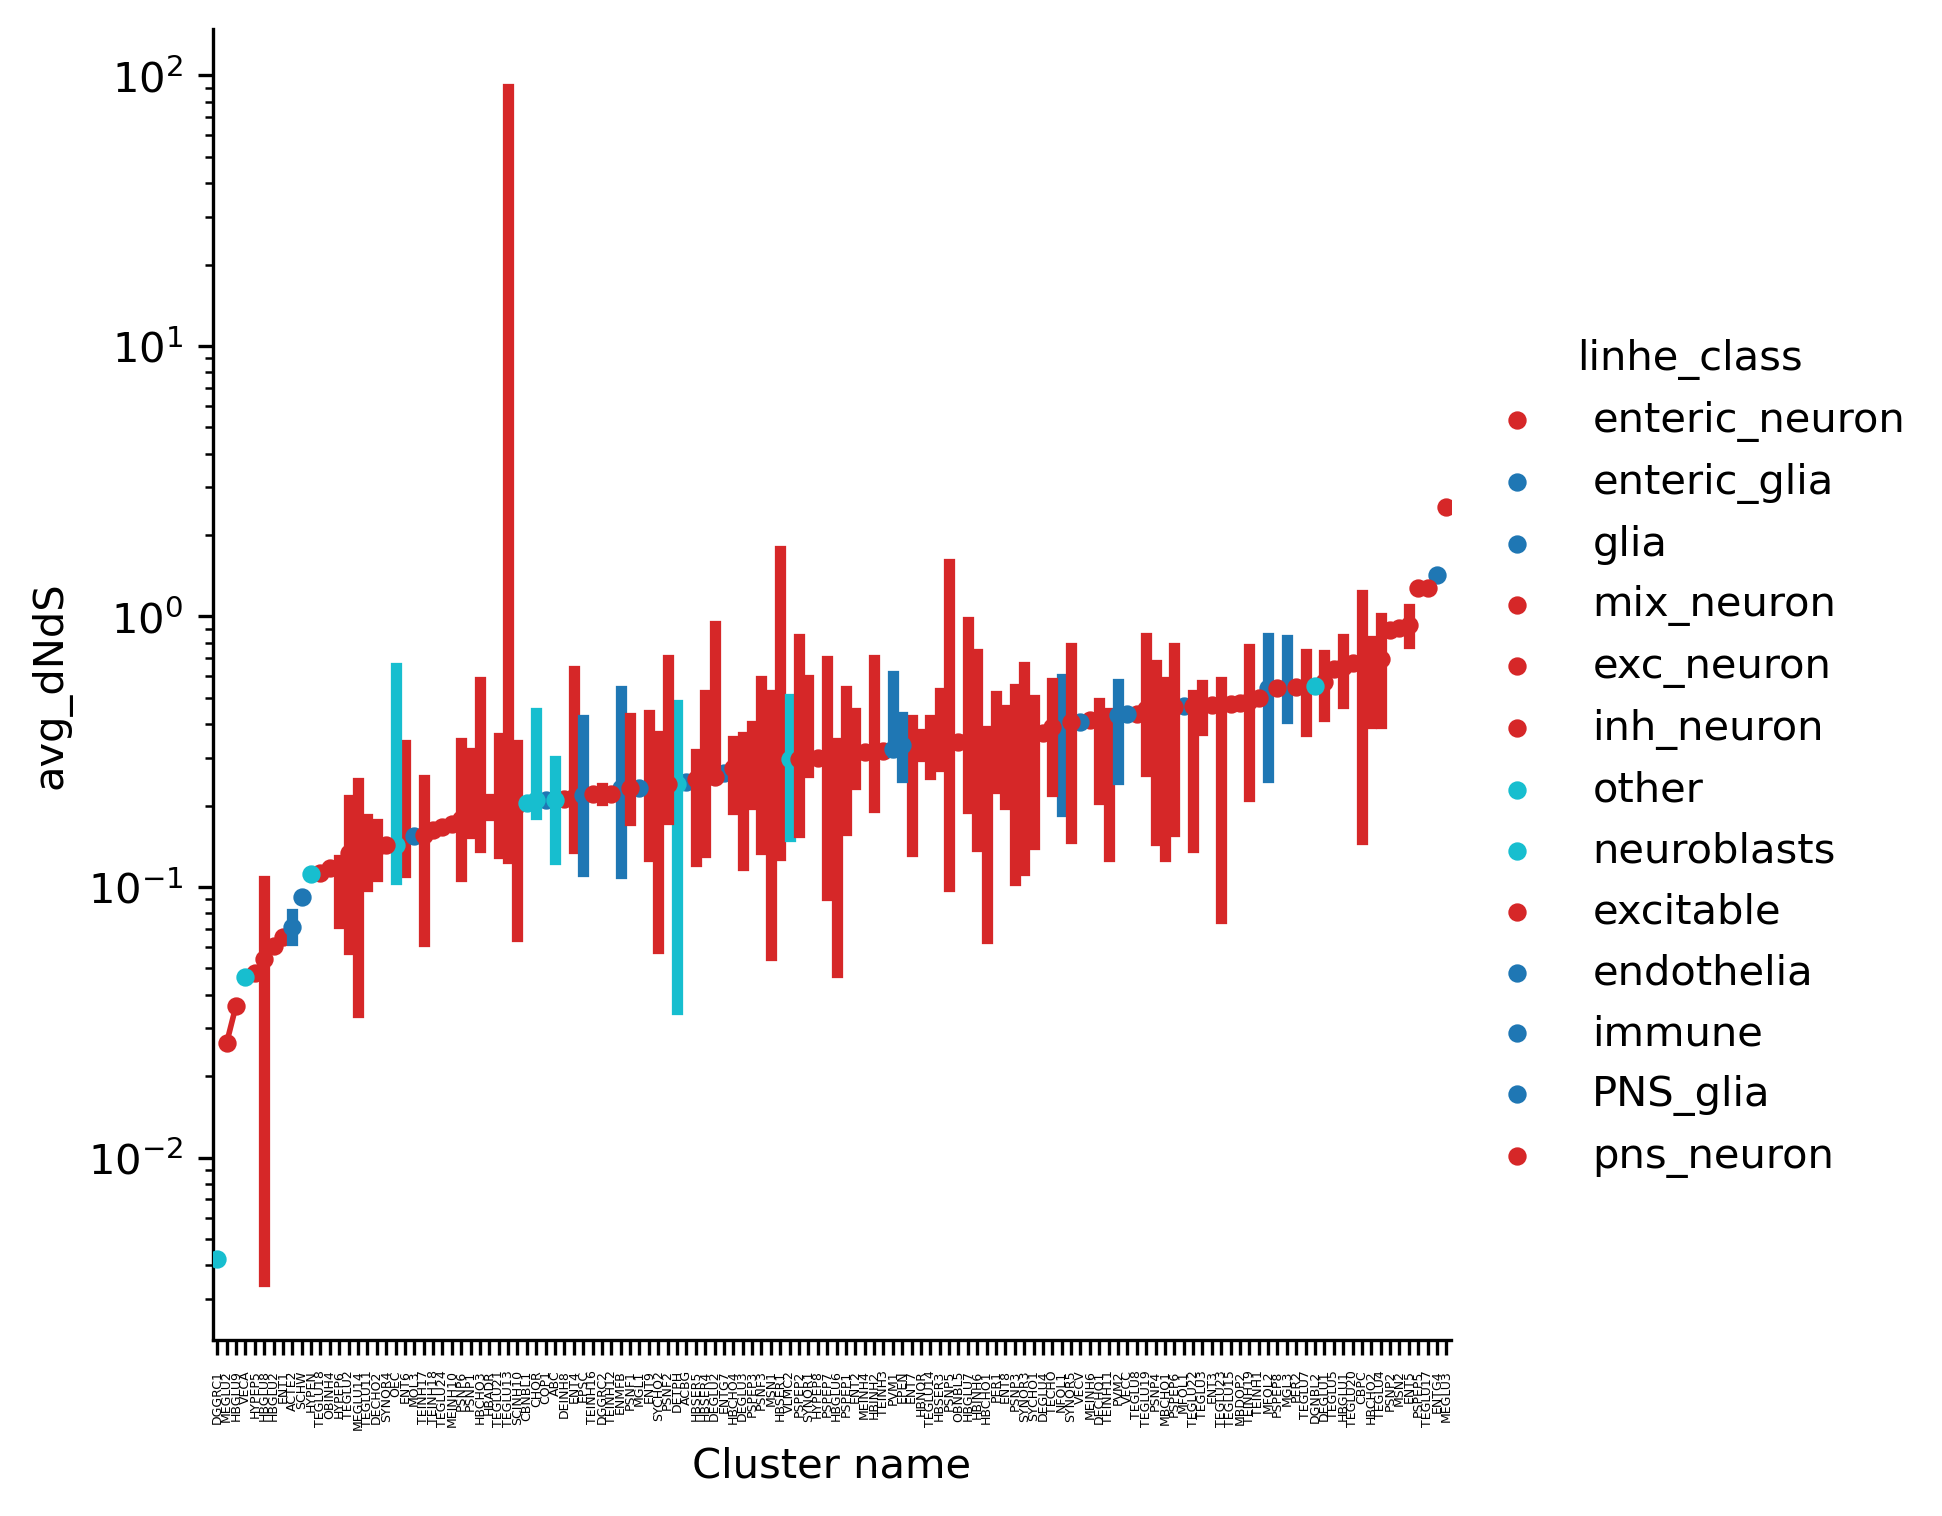

In [473]:
_ = plt.figure()
catplot = sns.catplot(data=ten_percent_FDR_cluster_specific_df,x='Cluster name',y='avg_dNdS',hue='linhe_class',palette=color_excitable_dict,order=ten_percent_FDR_ranked_cluster_list,estimator=np.median,kind='point',errorbar='ci',scale=0.5)
_ = plt.gca().set_yscale('log')
# _ = plt.rc('xtick',labelsize=3)
_ = plt.xticks(rotation=90)

<Figure size 1800x1200 with 0 Axes>

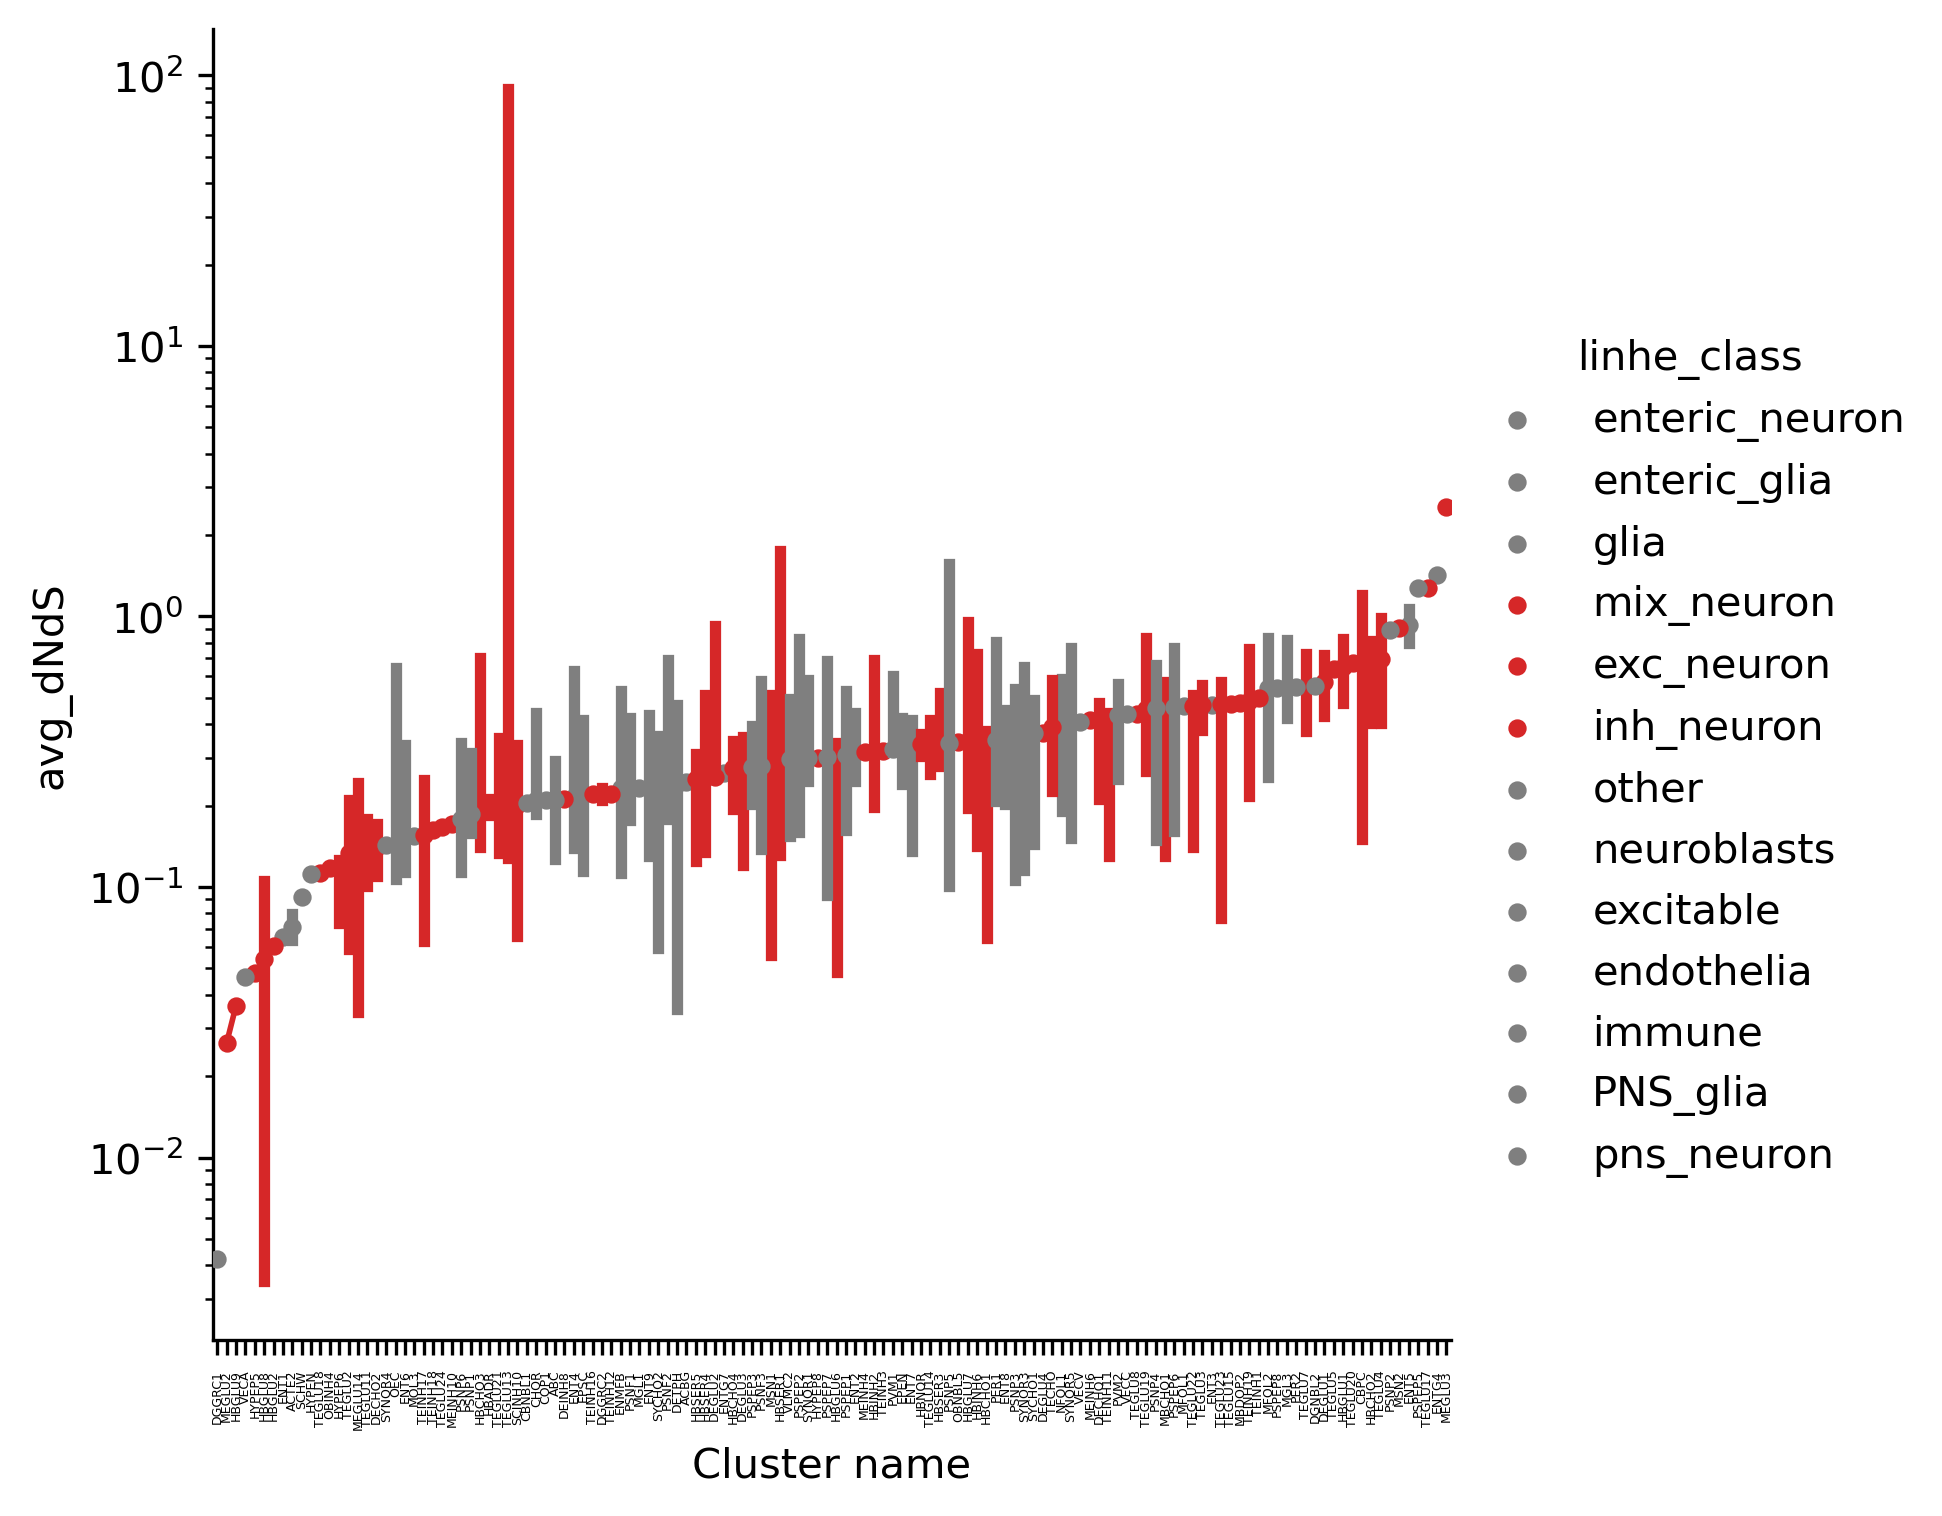

In [474]:
_ = plt.figure()
catplot = sns.catplot(data=ten_percent_FDR_cluster_specific_df,x='Cluster name',y='avg_dNdS',hue='linhe_class',palette=color_CNS_neuron_dict,order=ten_percent_FDR_ranked_cluster_list,estimator=np.median,kind='point',errorbar='ci',scale=0.5)
_ = plt.gca().set_yscale('log')
# _ = plt.rc('xtick',labelsize=3)
_ = plt.xticks(rotation=90)

<Figure size 1800x1200 with 0 Axes>

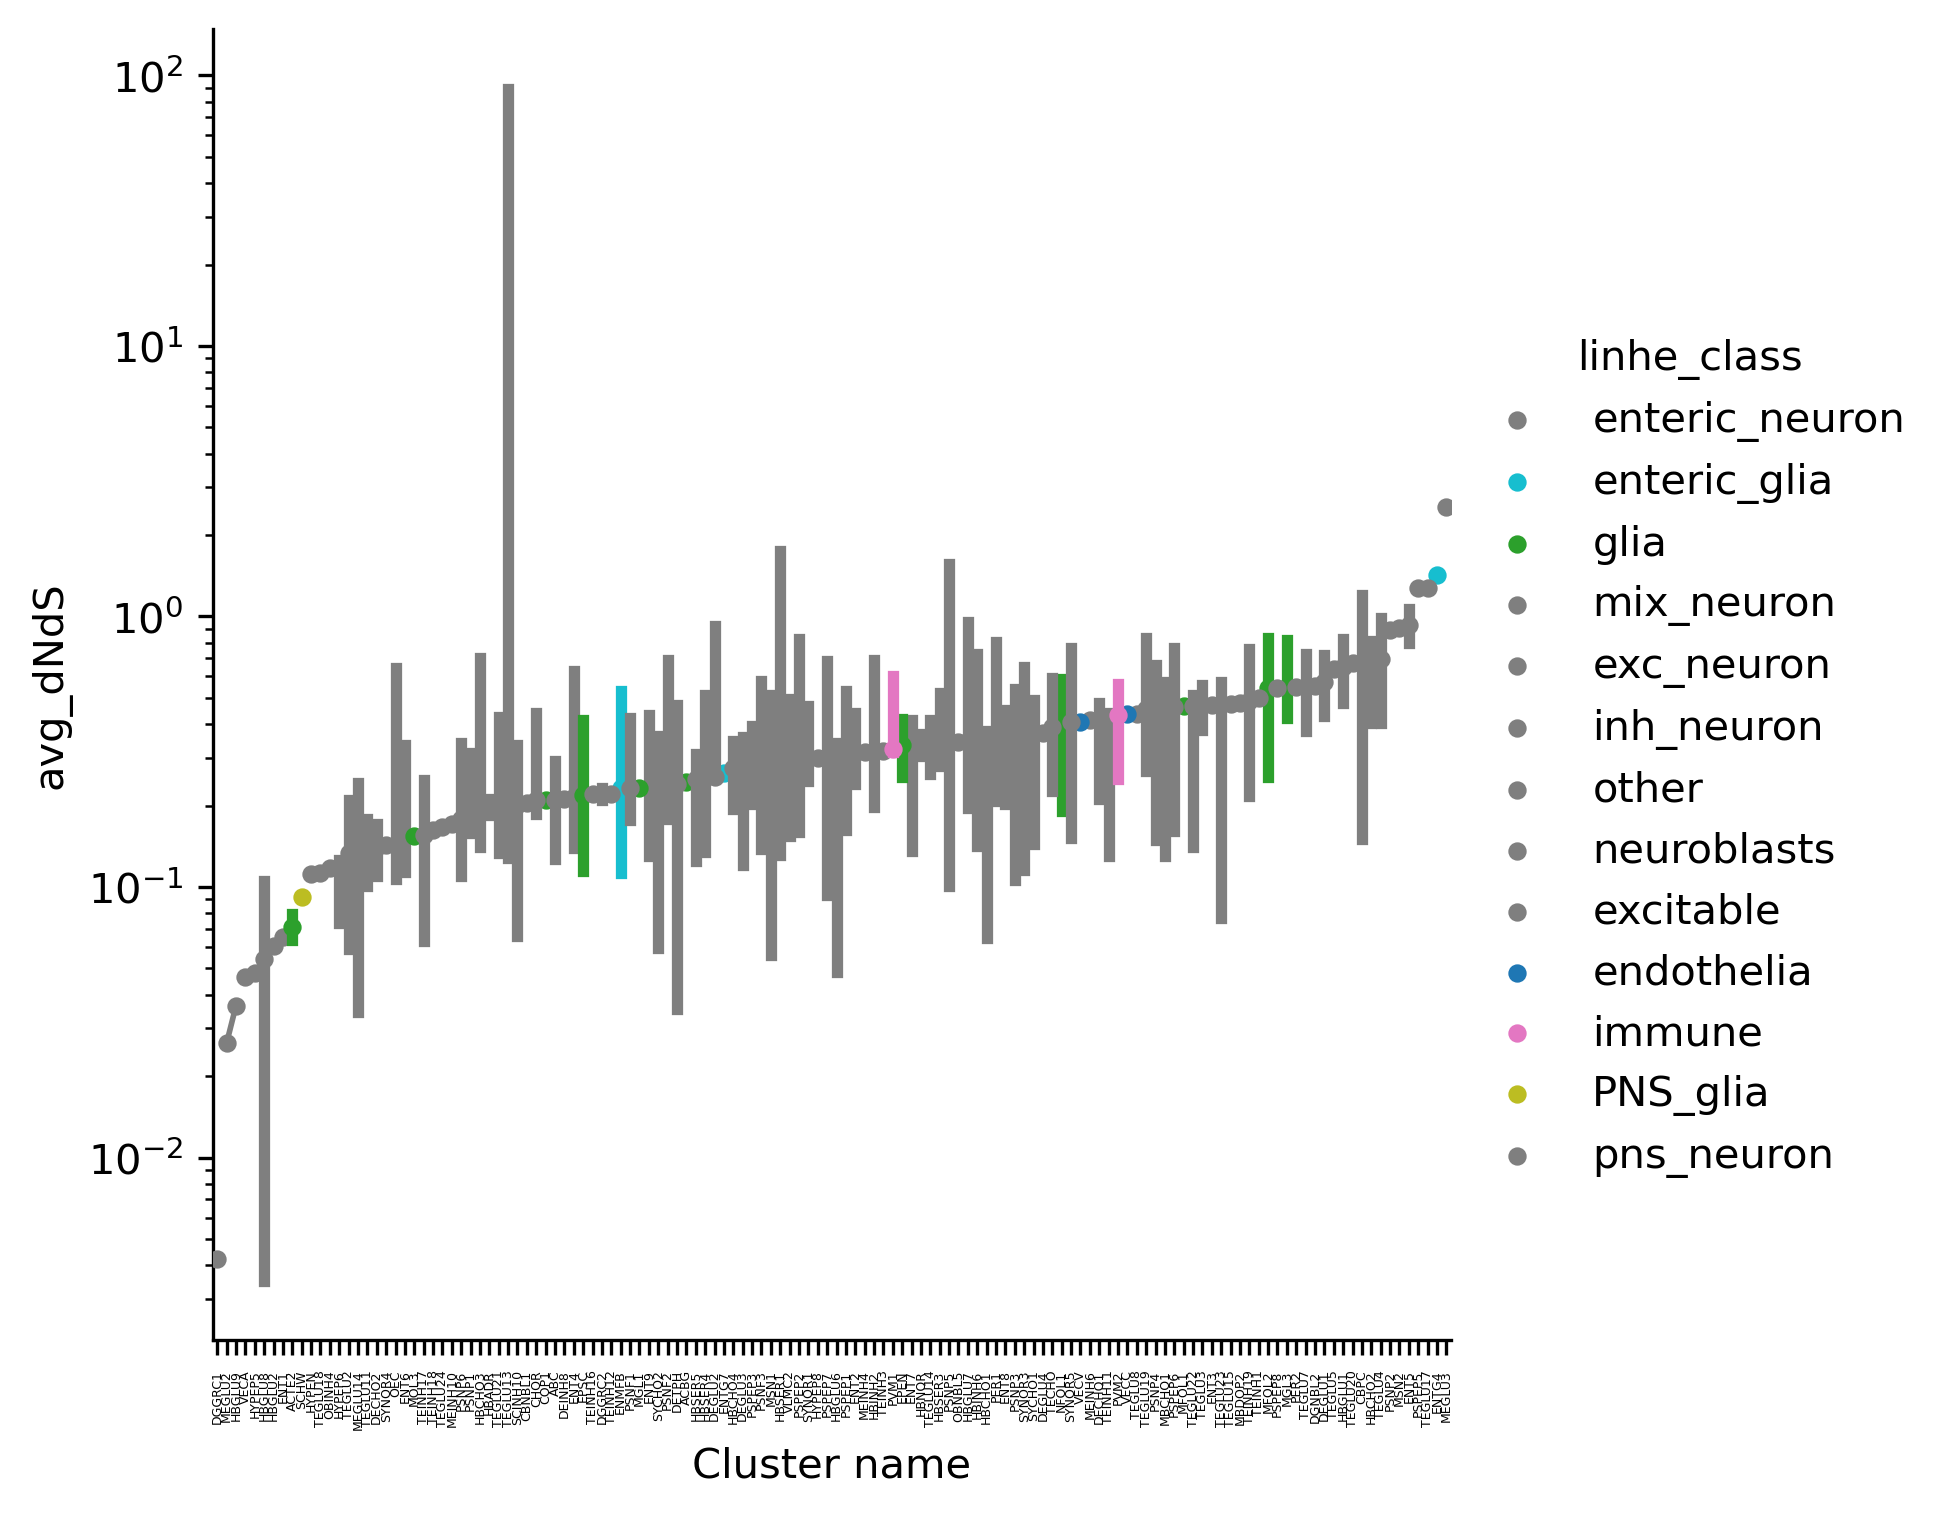

In [475]:
_ = plt.figure()
catplot = sns.catplot(data=ten_percent_FDR_cluster_specific_df,x='Cluster name',y='avg_dNdS',hue='linhe_class',palette=color_glia_endo_immune_dict,order=ten_percent_FDR_ranked_cluster_list,estimator=np.median,kind='point',errorbar='ci',scale=0.5)
_ = plt.gca().set_yscale('log')
# _ = plt.rc('xtick',labelsize=3)
_ = plt.xticks(rotation=90)

### Multiple Regression

##### preparing dataframe

In [54]:
mr_df = pd.DataFrame(data=agg[:,:],
                     index = agg.ra.Accession,
                     columns = agg.ca.ClusterName)

In [55]:
mr_df = mr_df.merge(avg_dNdS_df,left_index=True,right_index=True,how='inner')

In [56]:
np.unique(agg.ca.TaxonomyRank1,return_counts=True)

(array(['Glia', 'Immune cells', 'Neurons', 'Vascular cells'], dtype=object),
 array([ 36,   5, 214,  10]))

In [57]:
for celltype in ['Glia', 'Immune cells', 'Neurons', 'Vascular cells']:
    celltype_cluster_list = agg.ca.ClusterName[agg.ca.TaxonomyRank1==celltype].tolist()
    df = mr_df.loc[:,celltype_cluster_list].copy(deep=True)
    col_name = f"{celltype} avg UMI"
    mr_df[col_name]=np.mean(df,axis=1)

In [68]:
# CNS neuron, endothelia, glia, aka NEG, cluster-specific genes
mr_df['CNS Neuron avg UMI']=np.mean(mr_df.loc[:,CNS_neuron_cluster_list],axis=1)
mr_df['CNS Endothelia avg UMI']=np.mean(mr_df.loc[:,CNS_endothelia_cluster_list],axis=1)
mr_df['CNS Glia avg UMI']=np.mean(mr_df.loc[:,CNS_glia_cluster_list],axis=1)

##### Linear Regression with all genes

In [535]:
# Using TaxonomyRank1, average UMI of 
# Vascular, Immune, Neuron, Glia (VING) clusters 
X = mr_df[['Vascular cells avg UMI','Immune cells avg UMI','Neurons avg UMI','Glia avg UMI']]
y = mr_df['avg_dNdS']
VING_regr = linear_model.LinearRegression()
VING_regr.fit(X, y)

LinearRegression()

In [536]:
VING_regr.coef_

array([-0.00255982,  0.00568016, -0.04354511, -0.00396541])

In [540]:
VING_regr.score(X, y)

0.0006392114565719753

This model does a terrible job describing the relationship. 

In [543]:
# What about every cluster? 
X = mr_df[agg.ca.ClusterName]
y = mr_df['avg_dNdS']
all_cluster_regr = linear_model.LinearRegression()
all_cluster_regr.fit(X, y)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


LinearRegression()

In [548]:
all_cluster_regr.score(X,y)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


0.003756312615556756

In [549]:
# What about just neuron clusters? 
X = mr_df[agg.ca.ClusterName[agg.ca.TaxonomyRank1=='Neurons']]
y = mr_df['avg_dNdS']
N_cluster_regr = linear_model.LinearRegression()
N_cluster_regr.fit(X, y)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


LinearRegression()

In [550]:
N_cluster_regr.score(X,y)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


0.0032818391051159246

In [553]:
# What about just neuron average? 
x = mr_df['Neurons avg UMI']
y = mr_df['avg_dNdS']
slope, intercept, r, p, std_err = stats.linregress(x, y)

In [555]:
r*r

0.0006283284261341853

In [556]:
slope

-0.044745718352494086

In [596]:
celltype_cluster_list = cluster_description_df[np.isin(cluster_description_df['linhe_class'],['exc_neuron','inh_neuron'])]['Cluster name'].tolist()
df = mr_df.loc[:,celltype_cluster_list].copy(deep=True)
col_name = "CNS Neuron avg UMI"
mr_df[col_name]=np.mean(df,axis=1)

In [598]:
# What about just CNS neuron average? 
x = mr_df['CNS Neuron avg UMI']
y = mr_df['avg_dNdS']
slope, intercept, r, p, std_err = stats.linregress(x, y)

In [599]:
r*r

0.0006666369169938197

##### Spearman (Rank-based) correlation of all genes to dN/dS

In [128]:
mr_df

ENT9      ENT8      ENT6      ENT5      ENT4  \
ENSMUSG00000024647  13.976331  0.422680  0.127119  0.084942  0.038710   
ENSMUSG00000041544   0.390533  0.000000  0.000000  0.000000  0.000000   
ENSMUSG00000029503   7.609467  1.381443  0.186441  0.517375  0.412903   
ENSMUSG00000039942   0.928994  0.092784  0.194915  0.127413  0.148387   
ENSMUSG00000059187   8.739645  9.000000  3.601695  1.752896  1.103226   
...                       ...       ...       ...       ...       ...   
ENSMUSG00000035757   0.236686  0.195876  0.194915  0.084942  0.122581   
ENSMUSG00000026860   1.508876  0.917526  0.483051  0.370656  0.277419   
ENSMUSG00000026766   0.568047  0.680412  0.483051  0.220077  0.303226   
ENSMUSG00000026799   0.248521  0.082474  0.033898  0.046332  0.077419   
ENSMUSG00000021832   0.952663  0.917526  0.440678  0.320463  0.361290   

                        ENT7      ENT3      ENT2      ENT1     ENTG1  ...  \
ENSMUSG00000024647  0.000000  0.006452  0.018692  0.071429  0.012270  ...   
ENSMUSG00000041544  0.032258  0.000000  0.009346  0.000000  0.000000  ...   
ENSMUSG00000029503  1.322581  1.219355  1.373832  1.714286  0.006135  ...   
ENSMUSG00000039942  0.193548  0.070968  0.214953  0.142857  0.000000  ...   
ENSMUSG00000059187  1.870968  0.090323  0.065421  2.214286  0.000000  ...   
...                      ...       ...       ...       ...       ...  ...   
ENSMUSG00000035757  0.161290  0.148387  0.214953  0.071429  0.110429  ...   
ENSMUSG00000026860  0.516129  0.529032  0.626168  0.714286  0.208589  ...   
ENSMUSG00000026766  0.806452  0.290323  0.457944  0.642857  0.582822  ...   
ENSMUSG00000026799  0.161290  0.096774  0.121495  0.357143  0.116564  ...   
ENSMUSG00000021832  0.548387  0.496774  0.794393  1.000000  0.779141  ...   

                        PSNP6  Gene name  avg_dNdS  Glia avg UMI  \
ENSMUSG00000024647   0.007576      Cbln2  0.047158      0.007370   
ENSMUSG00000041544   0.007576      Disp3  0.049768      0.023578   
ENSMUSG00000029503   1.590909      P2rx2  0.140467      0.006919   
ENSMUSG00000039942   0.159091     Ptger4  0.076129      0.005384   
ENSMUSG00000059187   0.007576      Tafa1  0.018042      0.021413   
...                       ...        ...       ...           ...   
ENSMUSG00000035757   0.583333    Selenoo  0.103501      0.076482   
ENSMUSG00000026860  11.977273    Sh3glb2  0.043883      0.213355   
ENSMUSG00000026766   1.265152     Mmadhc  0.092318      0.163799   
ENSMUSG00000026799   0.416667      Med27  0.016523      0.062439   
ENSMUSG00000021832   3.878788      Psmc6  0.118070      0.179157   

                    Immune cells avg UMI  Neurons avg UMI  \
ENSMUSG00000024647              0.002738         0.392894   
ENSMUSG00000041544              0.000935         0.043284   
ENSMUSG00000029503              0.000000         0.104096   
ENSMUSG00000039942              0.006125         0.027324   
ENSMUSG00000059187              0.005469         0.543955   
...                                  ...              ...   
ENSMUSG00000035757              0.035748         0.115281   
ENSMUSG00000026860              0.067792         0.968500   
ENSMUSG00000026766              0.050299         0.227755   
ENSMUSG00000026799              0.016298         0.095802   
ENSMUSG00000021832              0.082168         0.539815   

                    Vascular cells avg UMI  CNS Neuron avg UMI  \
ENSMUSG00000024647                0.004849            0.367382   
ENSMUSG00000041544                0.001228            0.044238   
ENSMUSG00000029503                0.000000            0.007958   
ENSMUSG00000039942                0.000284            0.009760   
ENSMUSG00000059187                0.007025            0.499984   
...                                    ...                 ...   
ENSMUSG00000035757                0.075923            0.103202   
ENSMUSG00000026860                0.294007            0.633062   
ENSMUSG00000026766                0.136905            0.163781   
ENSMUSG000000

In [132]:
y = mr_df['avg_dNdS']
VING_col_list = ['Vascular cells avg UMI','Immune cells avg UMI','Neurons avg UMI','Glia avg UMI']
for col in VING_col_list:
    x = mr_df[col]
    print(col)
    pg.corr(x,y,method='spearman')

Vascular cells avg UMI


n         r           CI95%  p-val  power
spearman  19146 -0.435592  [-0.45, -0.42]    0.0    1.0

Immune cells avg UMI


n         r          CI95%  p-val  power
spearman  19146 -0.383384  [-0.4, -0.37]    0.0    1.0

Neurons avg UMI


n         r          CI95%  p-val  power
spearman  19146 -0.514236  [-0.52, -0.5]    0.0    1.0

Glia avg UMI


n         r           CI95%  p-val  power
spearman  19146 -0.453003  [-0.46, -0.44]    0.0    1.0

In [146]:
spearman_df = pd.DataFrame()
y = mr_df['avg_dNdS']
for col in mr_df.loc[:,'ENT9':'PSNP6'].columns:
    # print(col)
    x = mr_df[col]
    df = pg.corr(x,y,method='spearman')
    df['Cluster']=col
    spearman_df=pd.concat([spearman_df,df],ignore_index=True)
    # df['']

In [157]:
spearman_df = spearman_df.merge(cluster_description_df.loc[:,'Cluster name':'Probable location (manually assigned)'],left_on='Cluster',right_on='Cluster name',how='left')

In [158]:
spearman_df[spearman_df['p-val']!=0]

n         r           CI95%          p-val  power Cluster  \
109  19146 -0.245525  [-0.26, -0.23]  7.964988e-261    1.0   DETPH   

    Cluster name                Description    Region  \
109        DETPH  Neuroblast-like, habenula  Thalamus   

    Developmental compartment  linhe_class    Neurotransmitter  \
109              Diencephalon  neuroblasts  Glutamate (VGLUT2)   

                                Comment                 Taxonomy_group  \
109  Neurotransmitter assigned manually  Non-glutamatergic neuroblasts   

    Probable location (manually assigned)  
109                       Medial habenula

In [159]:
spearman_df.to_excel('../results/single-cell/zeisel_2018/dNdS_spearman_corr_UMI.xlsx',sheet_name='all_genes_all_clusters',index=False)

<Figure size 1800x1200 with 0 Axes>

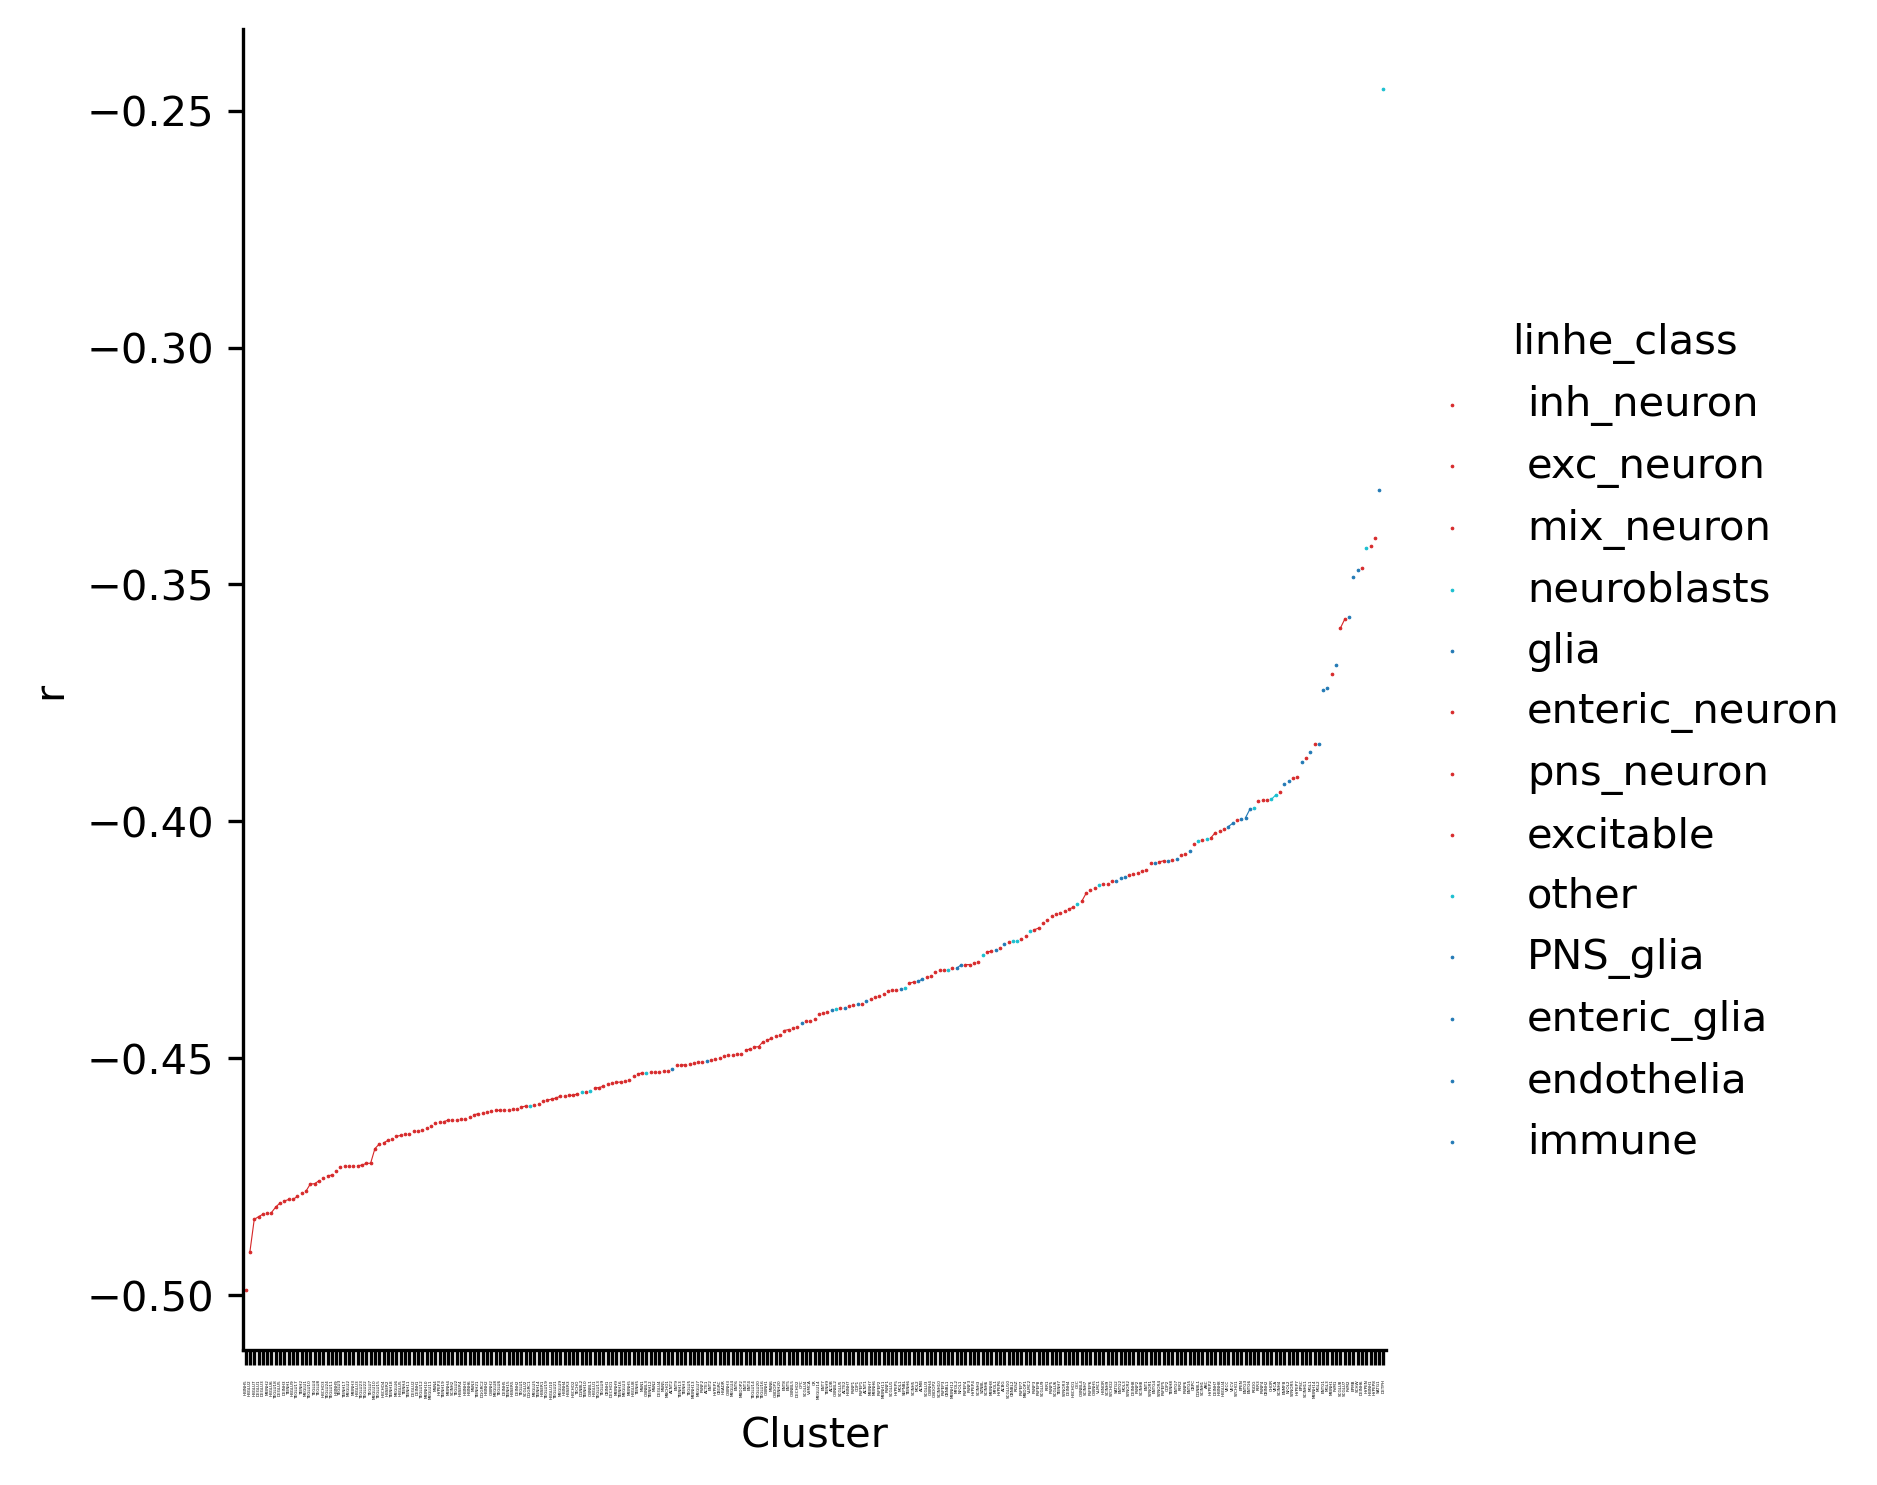

<Figure size 1800x1200 with 0 Axes>

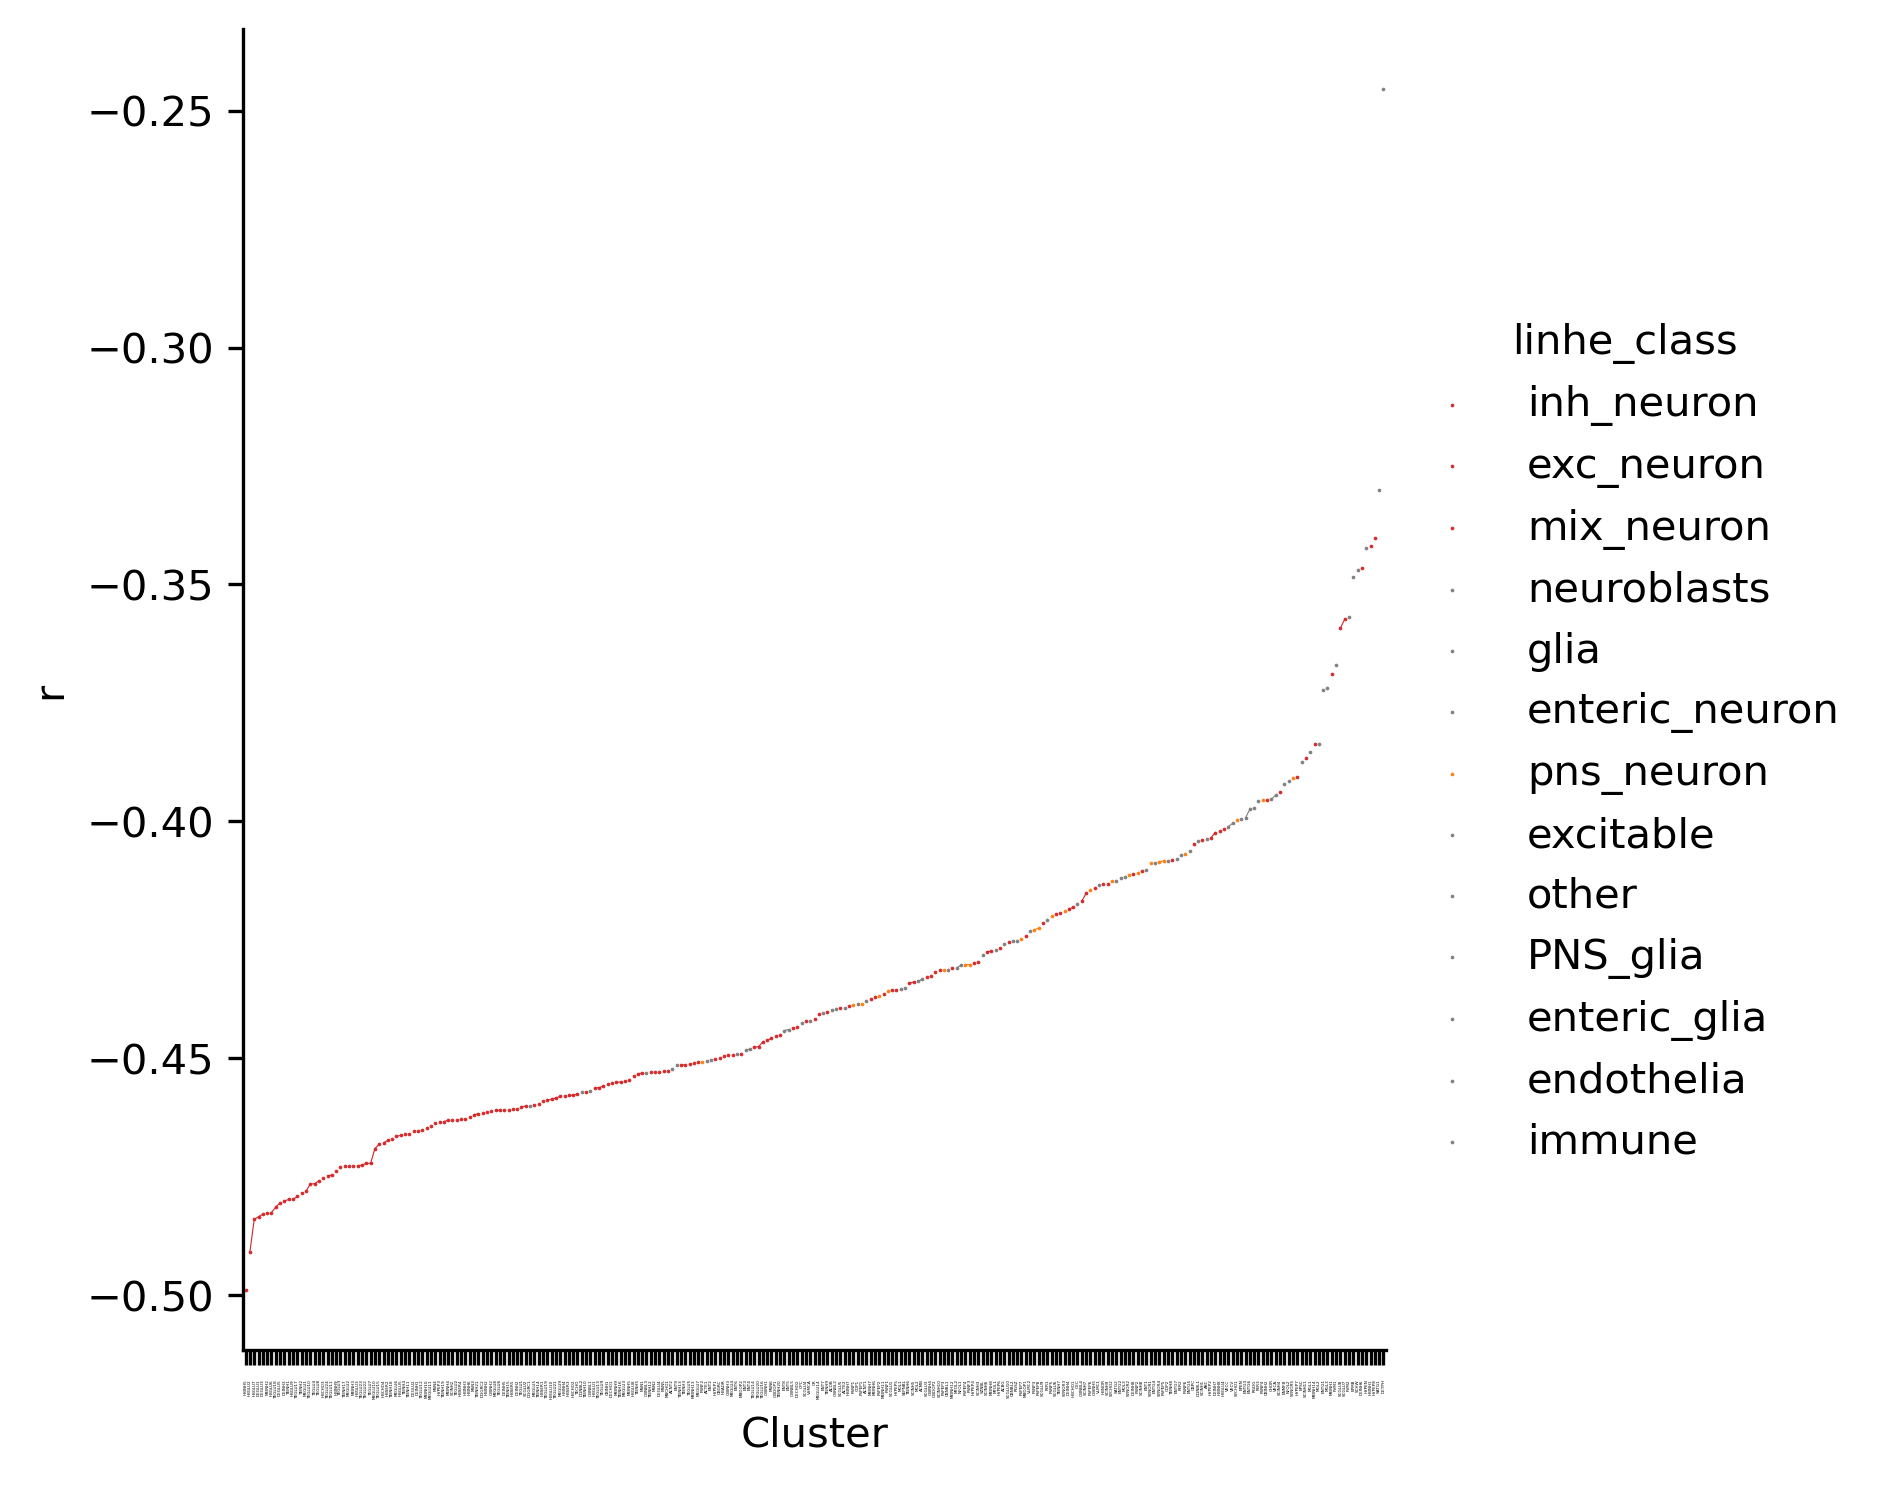

<Figure size 1800x1200 with 0 Axes>

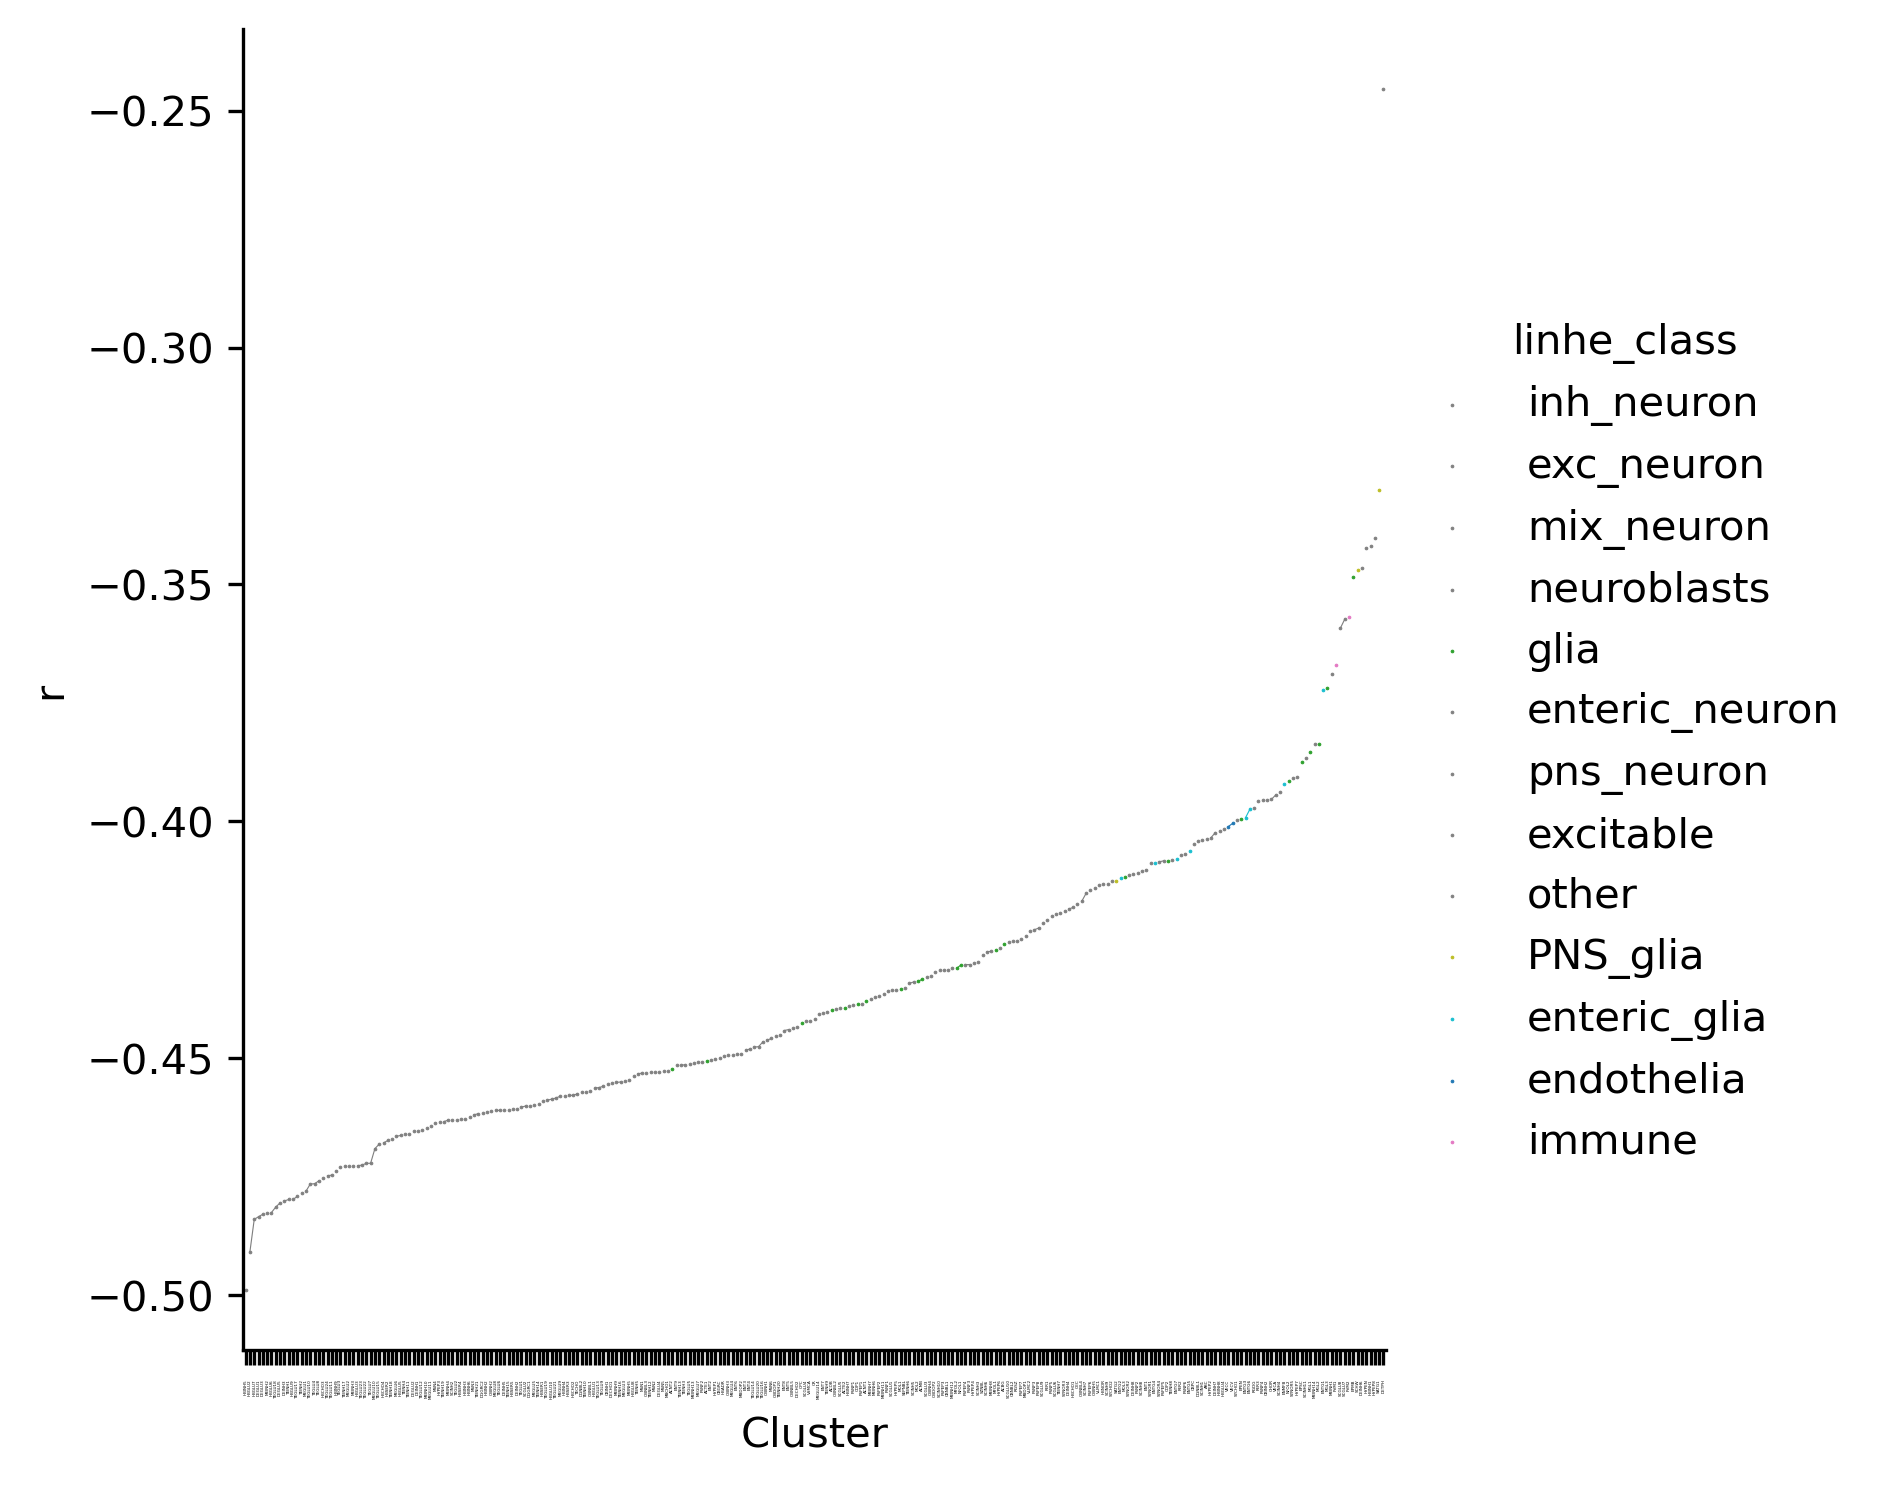

<Figure size 1800x1200 with 0 Axes>

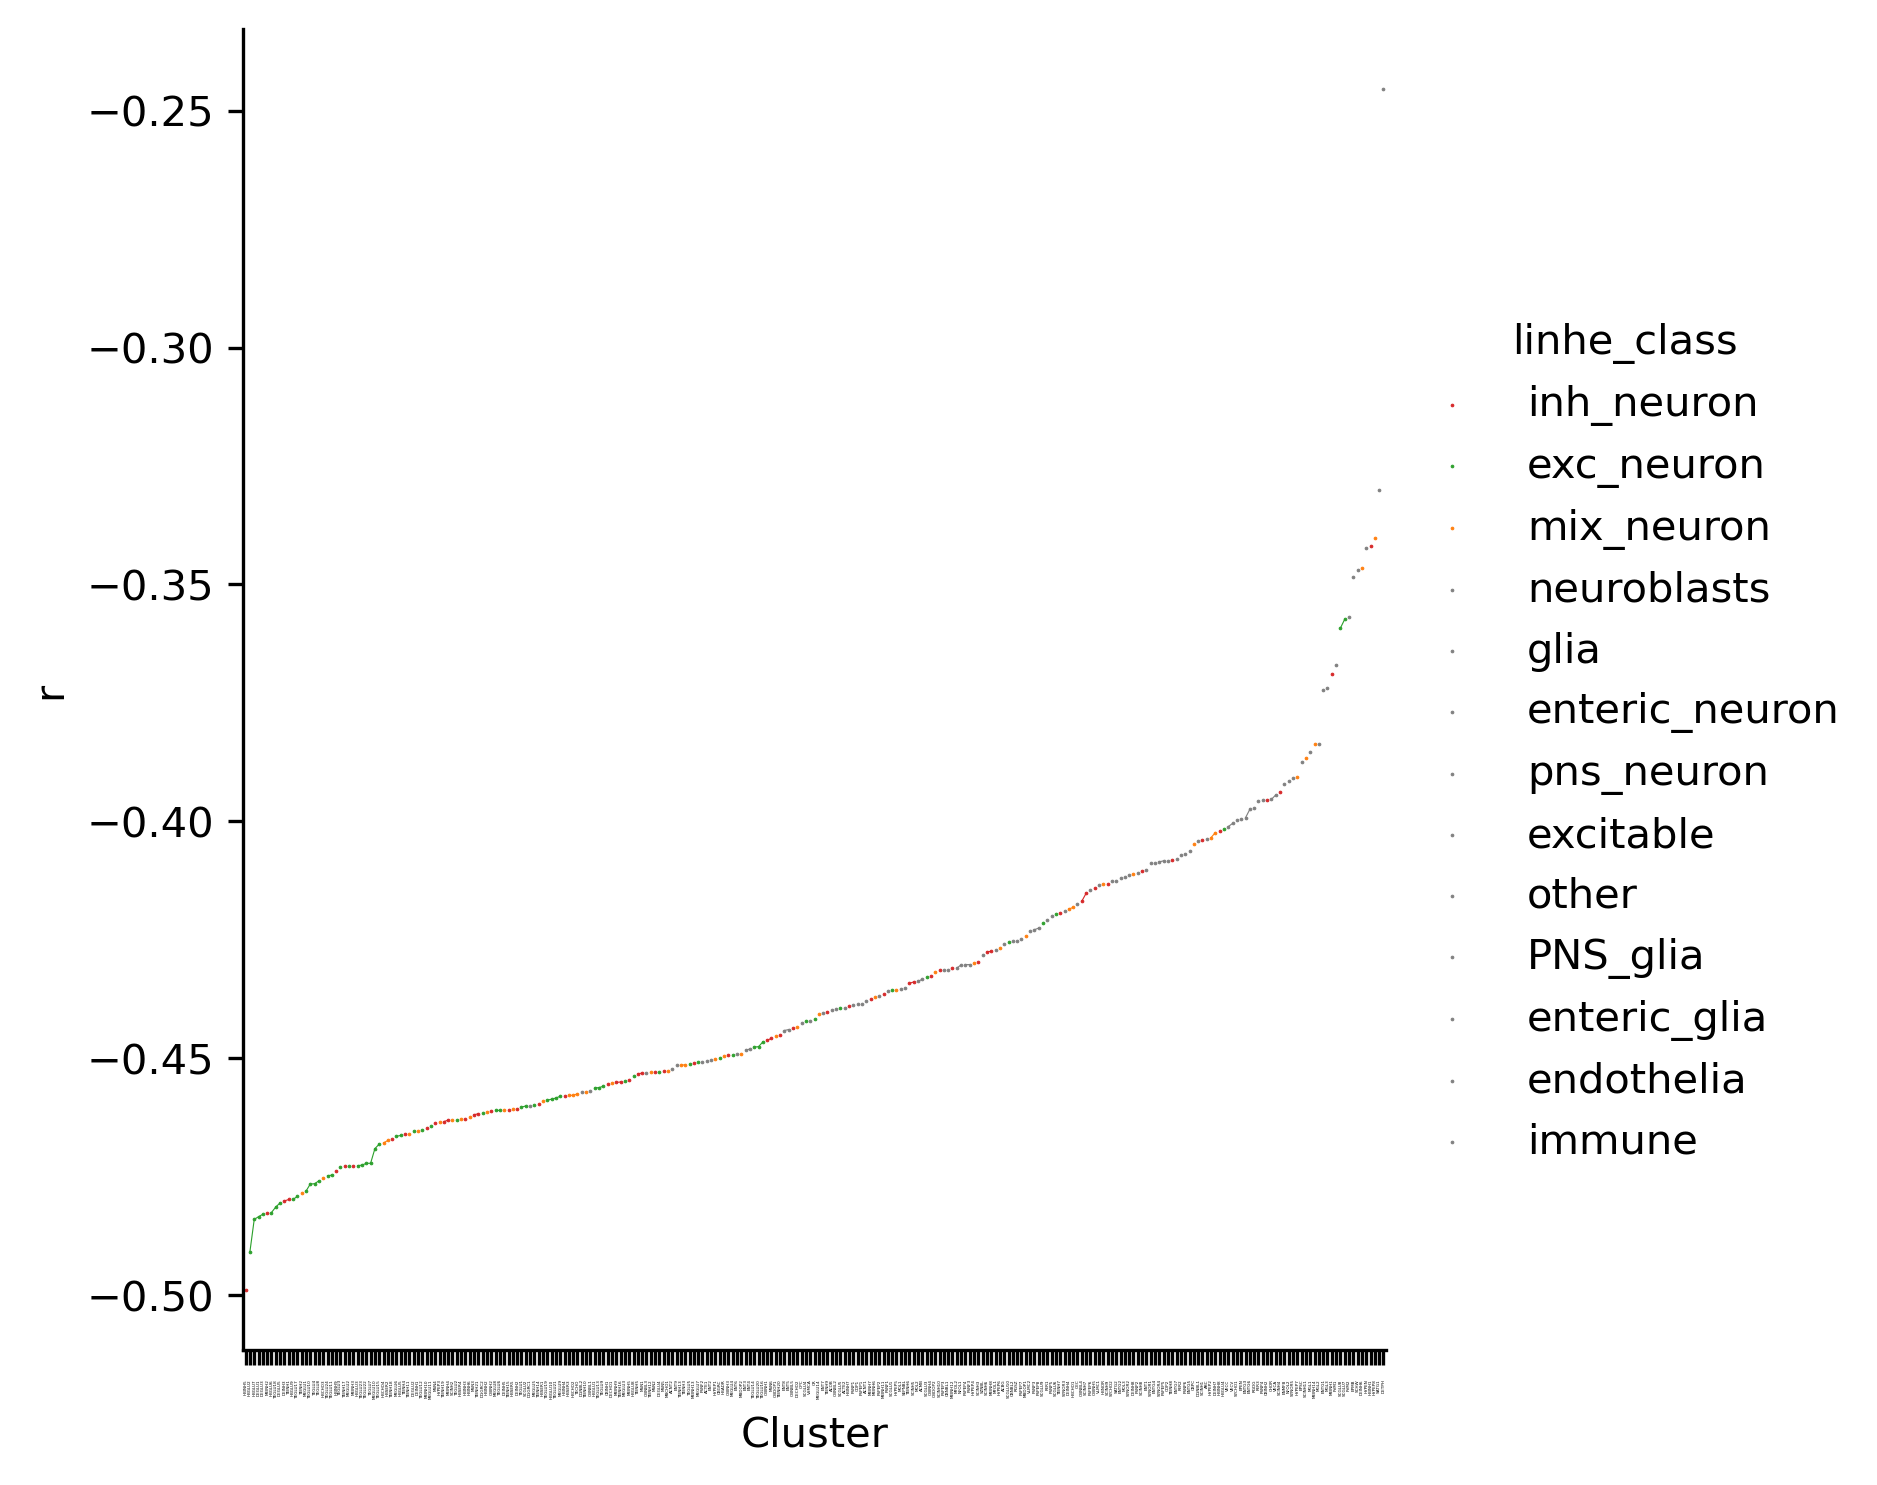

In [174]:
df = spearman_df.sort_values(by='r')
for palette in [color_excitable_dict, color_neuron_dict, color_glia_endo_immune_dict,color_exc_inh_dict]:
    _ = plt.figure()
    catplot = sns.catplot(data=df,x='Cluster',y='r',hue='linhe_class',palette=palette,kind='point',scale=0.1)
    # _ = plt.gca().set_yscale('log')
    _ = plt.rc('xtick',labelsize=0.5) # matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    _ = plt.xticks(rotation=90)

##### Modeling with log10 transformed data

In [121]:
# agg.ca.NCells

In [117]:
# minimum UMI
# df = mr_df.loc[:,'ENT9':'PSNP6']
df = mr_df[['Vascular cells avg UMI','Immune cells avg UMI','Neurons avg UMI','Glia avg UMI']]
df.where(df.gt(0)).min().min()
df.max().max()

1.1144519905227002e-06

95.79130655345233

In [99]:
np.log10(1e-7)

-7.0

In [101]:
df = mr_df[['Vascular cells avg UMI','Immune cells avg UMI','Neurons avg UMI','Glia avg UMI']].copy(deep=True)
# df.replace(0,1e-7,inplace=True)
df += 1e-7 # a small epsilon to avoid log 0 problem; epsilon smaller than minimum non-zero UMI
np.log10(df)

Vascular cells avg UMI  Immune cells avg UMI  \
ENSMUSG00000024647               -2.314294             -2.562584   
ENSMUSG00000041544               -2.910792             -3.029047   
ENSMUSG00000029503               -7.000000             -7.000000   
ENSMUSG00000039942               -3.546160             -2.212920   
ENSMUSG00000059187               -2.153318             -2.262076   
...                                    ...                   ...   
ENSMUSG00000035757               -1.119626             -1.446742   
ENSMUSG00000026860               -0.531643             -1.168818   
ENSMUSG00000026766               -0.863580             -1.298440   
ENSMUSG00000026799               -1.296244             -1.787869   
ENSMUSG00000021832               -0.716422             -1.085299   

                    Neurons avg UMI  Glia avg UMI  
ENSMUSG00000024647        -0.405724     -2.132547  
ENSMUSG00000041544        -1.363673     -1.627499  
ENSMUSG00000029503        -0.982565     -2.159962  
ENSMUSG00000039942        -1.563461     -2.268852  
ENSMUSG00000059187        -0.264437     -1.669312  
...                             ...           ...  
ENSMUSG00000035757        -0.938241     -1.116438  
ENSMUSG00000026860        -0.013901     -0.670897  
ENSMUSG00000026766        -0.642532     -0.785690  
ENSMUSG00000026799        -1.018624     -1.204545  
ENSMUSG00000021832        -0.267755     -0.746767  

[19146 rows x 4 columns]

In [ ]:
# Using TaxonomyRank1, average UMI of 
# Vascular, Immune, Neuron, Glia (VING) clusters 
X = mr_df[['Vascular cells avg UMI','Immune cells avg UMI','Neurons avg UMI','Glia avg UMI']]
y = mr_df['avg_dNdS']
VING_regr = linear_model.LinearRegression()
VING_regr.fit(X, y)

##### Regression within cell type specific genes: linear and spearman 

In [72]:
mr_four_fold_enriched_df = pd.merge(NEG_df[['Accession','Gene_name','CNS_NEG']],mr_df,left_on='Accession',right_index=True,how='left')

In [82]:
type(df['CNS Neuron avg UMI'])

pandas.core.series.Series

n         r           CI95%  p-val  power
spearman  4901 -0.534433  [-0.55, -0.51]    0.0    1.0

LinregressResult(slope=-0.15410069989296676, intercept=-1.219000354774559, rvalue=-0.530331844077705, pvalue=0.0, stderr=0.0035195857571406197, intercept_stderr=0.008087745595016245)

0.28125186484285913

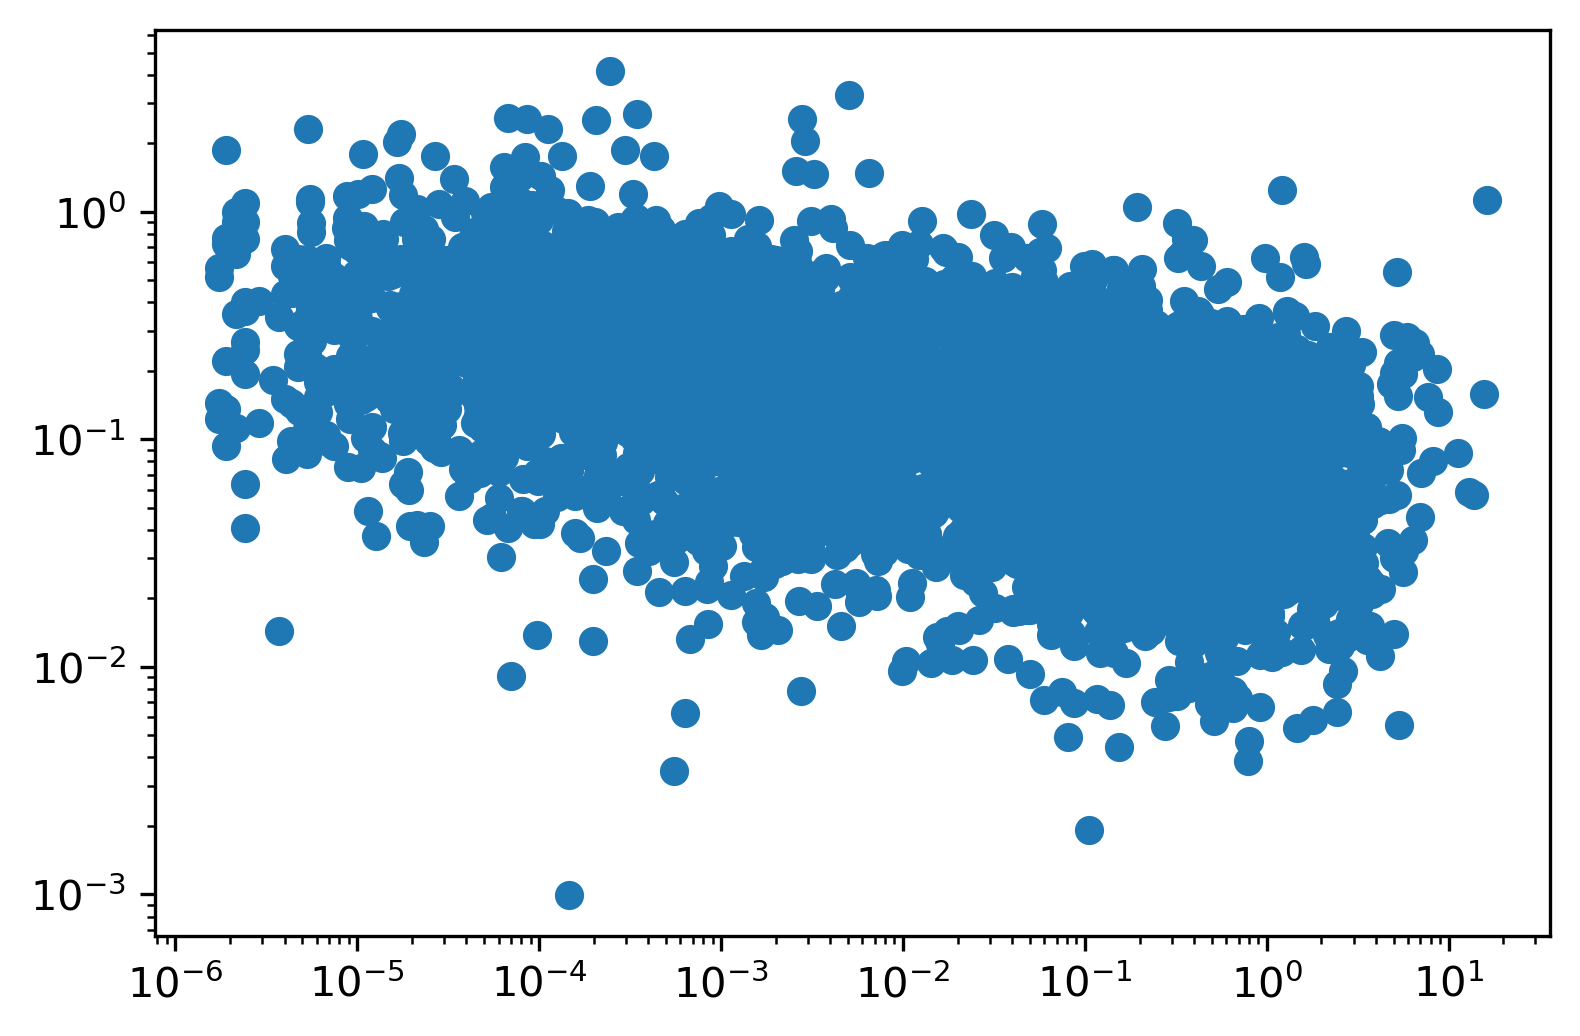

In [123]:
df = mr_four_fold_enriched_df[mr_four_fold_enriched_df['CNS_NEG']=='CNS_Neuron']
pg.corr(df['CNS Neuron avg UMI'],df['avg_dNdS'],method='spearman')
x = np.log10(df['CNS Neuron avg UMI'])
y = np.log10(df['avg_dNdS'])
slope, intercept, r, p, std_err = stats.linregress(x, y)
stats.linregress(x, y)
r*r
fig = plt.figure()
ax = plt.gca()
ax.scatter(df['CNS Neuron avg UMI'],df['avg_dNdS'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

n         r         CI95%         p-val  power
spearman  1098 -0.348729  [-0.4, -0.3]  9.477958e-33    1.0

LinregressResult(slope=-0.11986450757772578, intercept=-0.9668807782172284, rvalue=-0.33472823220834247, pvalue=3.7406459558560134e-30, stderr=0.01019269326254267, intercept_stderr=0.01708223609572339)

0.11204298943732204

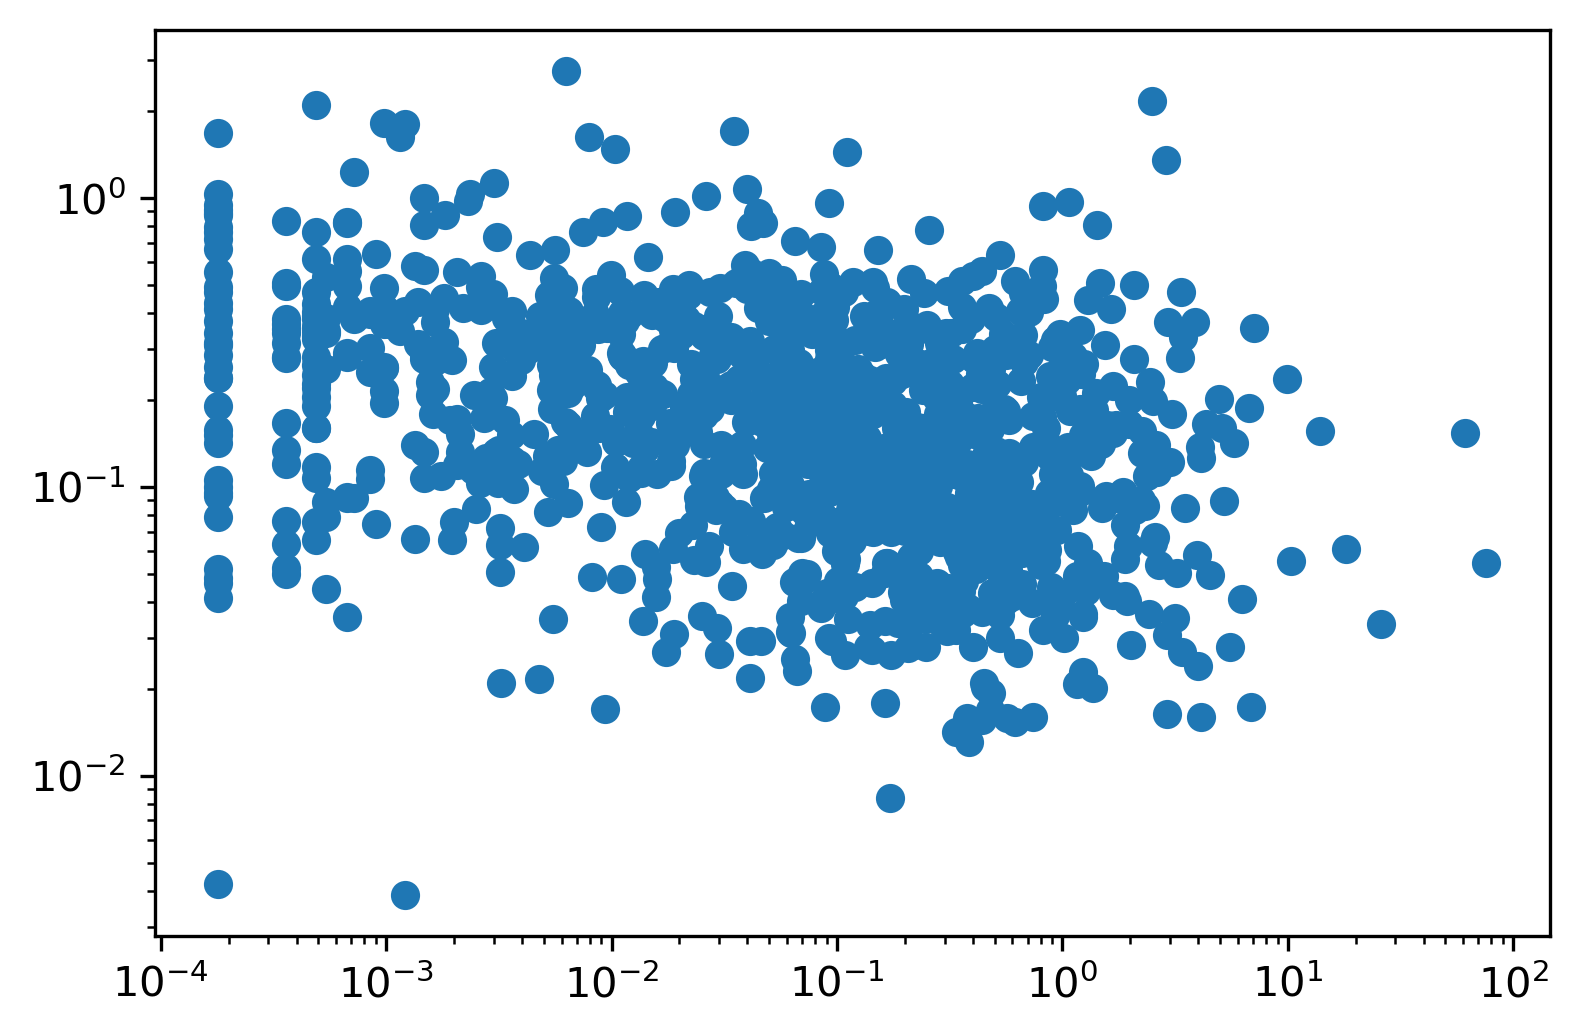

In [124]:
df = mr_four_fold_enriched_df[mr_four_fold_enriched_df['CNS_NEG']=='CNS_Endothelia']
pg.corr(df['CNS Endothelia avg UMI'],df['avg_dNdS'],method='spearman')
x = np.log10(df['CNS Endothelia avg UMI'])
y = np.log10(df['avg_dNdS'])
slope, intercept, r, p, std_err = stats.linregress(x, y)
stats.linregress(x, y)
r*r
fig = plt.figure()
ax = plt.gca()
ax.scatter(df['CNS Endothelia avg UMI'],df['avg_dNdS'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

n         r           CI95%         p-val  power
spearman  1767 -0.404436  [-0.44, -0.36]  1.641112e-70    1.0

LinregressResult(slope=-0.11449321233277197, intercept=-0.9842661064958702, rvalue=-0.3966803791892978, pvalue=1.1481908945489237e-67, stderr=0.006306507357560489, intercept_stderr=0.014956457160787648)

0.1573553232337651

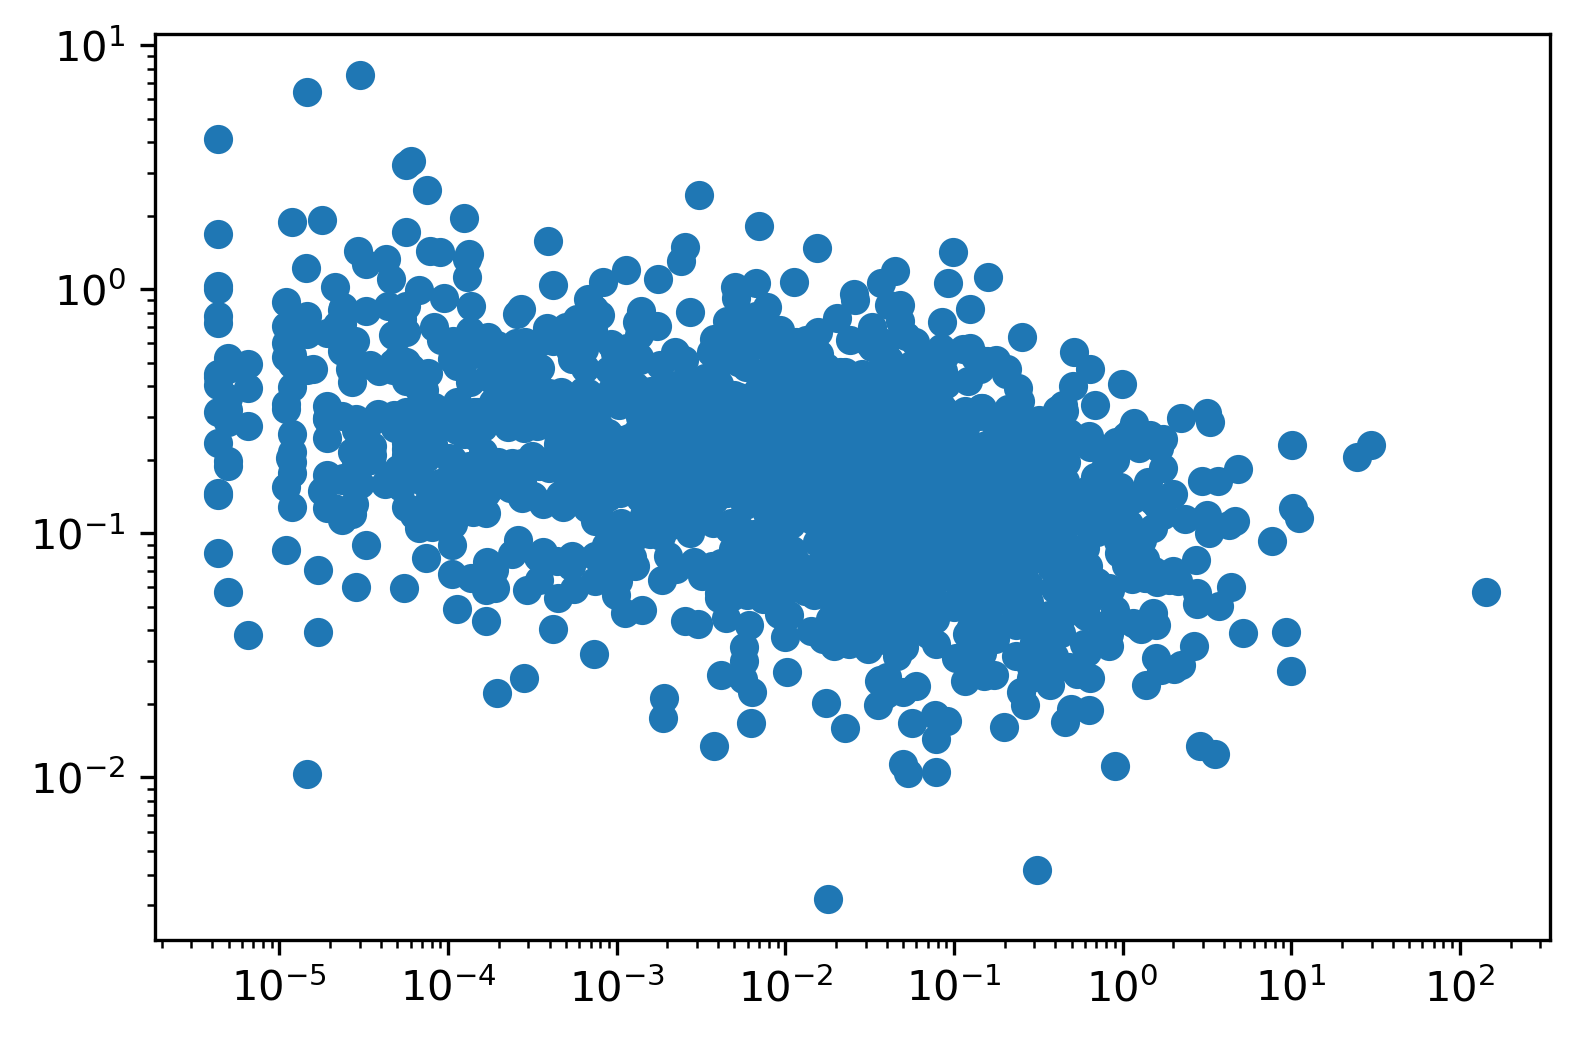

In [125]:
df = mr_four_fold_enriched_df[mr_four_fold_enriched_df['CNS_NEG']=='CNS_Glia']
pg.corr(df['CNS Glia avg UMI'],df['avg_dNdS'],method='spearman')
x = np.log10(df['CNS Glia avg UMI'])
y = np.log10(df['avg_dNdS'])
slope, intercept, r, p, std_err = stats.linregress(x, y)
stats.linregress(x, y)
r*r
fig = plt.figure()
ax = plt.gca()
ax.scatter(df['CNS Glia avg UMI'],df['avg_dNdS'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

# Backup codes

In [ ]:
np.mean()

In [164]:
len(agg.ca.ClusterName=='PER1')

265

In [167]:
agg[:,agg.ca.ClusterName=='PER1'].shape

(27998, 1)

In [ ]:
sns.stripplot(data=tips, x="total_bill", y="day", hue="sex")


In [268]:
useful_ca_keys_list=[
    'ClusterName',
    'Class',
    'TaxonomyRank1',
    'TaxonomyRank2',
    'TaxonomyRank3',
    'TaxonomyRank4',
    'TaxonomySymbol',
    'Region',
    'Probable_location',
    'Developmental_compartment',
    'NCells',
    'Neurotransmitter',
    'MarkerGenes',
    'Comment',
    'Description'
]

In [363]:
# Setting the columns of dataframe recording descriptive statatistics
columns=[]
columns.extend(useful_ca_keys_list)
columns.extend(['Median_dNdS',
                'Confidence_Interval_Low',
                'Confidence_Interval_High',
                'Median_Absolute_Deviation',
                'Normalized_Median_Absolute_Deviation',
                'Number of Genes with dNdS'])
# Setting dataframes to record descirptive stats
# for key in ['tri_09','tri_099','tri_0999','q_005']:
#     f"{key}_descriptive_stats_df" = pd.DataFrame(columns=columns)

## dN/dS of genes with trinaries greater or equal to 0.9 for each cluster 
tri_09_descriptive_stats_df = pd.DataFrame(columns=columns)
## dN/dS of genes with trinaries greater or equal to 0.99 for each cluster 
tri_099_descriptive_stats_df = pd.DataFrame(columns=columns)
## dN/dS of genes with trinaries greater or equal to 0.999 for each cluster 
tri_0999_descriptive_stats_df = pd.DataFrame(columns=columns)

## dN/dS of genes with enrichment q value less or equal to 0.05 for each cluster 
q_005_descriptive_stats_df = pd.DataFrame(columns=columns)

df_dict={
    'tri_09':tri_09_descriptive_stats_df,
    'tri_099':tri_099_descriptive_stats_df,
    'tri_0999':tri_0999_descriptive_stats_df,
    'q_005':q_005_descriptive_stats_df
}

cluster_accession_dict = {} # dictionary storing dicitonaries of accession ID for all clusters/celltyps
cluster_dNdS_dict = {} # dictionary storing dictionaries of dN/dS values that were averaged across 92 species for all clusters/celltypes

for celltype in agg.ca.ClusterName:
    
    Class = agg.ca.Class[agg.ca.ClusterName==celltype]
    TaxonomyRank1 = agg.ca.TaxonomyRank1[agg.ca.ClusterName==celltype]
    TaxonomyRank2 = agg.ca.TaxonomyRank2[agg.ca.ClusterName==celltype]
    TaxonomyRank3 = agg.ca.TaxonomyRank3[agg.ca.ClusterName==celltype]
    TaxonomyRank4 = agg.ca.TaxonomyRank4[agg.ca.ClusterName==celltype]
    TaxonomySymbol = agg.ca.TaxonomySymbol[agg.ca.ClusterName==celltype]
    Region = agg.ca.Region[agg.ca.ClusterName==celltype]
    Probable_location = agg.ca.Probable_location[agg.ca.ClusterName==celltype]
    Developmental_compartment = agg.ca.Developmental_compartment[agg.ca.ClusterName==celltype]
    NCells = agg.ca.NCells[agg.ca.ClusterName==celltype]
    Neurotransmitter = agg.ca.Neurotransmitter[agg.ca.ClusterName==celltype]
    MarkerGenes = agg.ca.MarkerGenes[agg.ca.ClusterName==celltype]
    Comment = agg.ca.Comment[agg.ca.ClusterName==celltype]
    Description = agg.ca.Description[agg.ca.ClusterName==celltype]
    
    accession_list_dict = {}
    dNdS_arr_dict = {}
    # med_dict = {} # medians
    # mad_dict = {} # median absolute deviation, aka, MAD
    # norm_mad_dict = {} # normalized MAD with normalization constant c 0.67, consistent with SD of normally distributed data
    # CI_low_dict = {} # Lower limit of confidence interval
    # CI_hight_dict = {} # Upper limit of confidence interval
    # n_genes_dict = {} # Record number of genes with dN/dS for each cluster and condition
    
    accession_list_dict['tri_09']=agg.ra.Accession[np.any(agg['trinaries'][:,agg.ca.ClusterName==celltype]>=0.9,axis=1)].tolist()
    accession_list_dict['tri_099']=agg.ra.Accession[np.any(agg['trinaries'][:,agg.ca.ClusterName==celltype]>=0.99,axis=1)].tolist()
    accession_list_dict['tri_0999']=agg.ra.Accession[np.any(agg['trinaries'][:,agg.ca.ClusterName==celltype]>=0.999,axis=1)].tolist()
    accession_list_dict['q_005']=agg.ra.Accession[np.any(agg['enrichment_q'][:,agg.ca.ClusterName==celltype]<=0.05,axis=1)].tolist()

    cluster_accession_dict[celltype]=deepcopy(accession_list_dict)
    
    for key in ['tri_09','tri_099','tri_0999','q_005']:
        dNdS_arr = avg_dNdS_df[avg_dNdS_df.index.isin(accession_list_dict[key])].avg_dNdS.to_numpy()
        n_genes = dNdS_arr.shape[0]
        # n_genes_dict[key] = deepcopy(n_genes)
        dNdS_arr_dict[key] = deepcopy(dNdS_arr)
        # dNdS_arr_dict['tri_09'] = avg_dNdS_df[avg_dNdS_df.index.isin(accession_list_dict['tri_09'])].avg_dNdS.to_numpy()
        # dNdS_arr_dict['tri_099'] = avg_dNdS_df[avg_dNdS_df.index.isin(accession_list_dict['tri_099'])].avg_dNdS.to_numpy()
        # dNdS_arr_dict['tri_0999'] = avg_dNdS_df[avg_dNdS_df.index.isin(accession_list_dict['tri_0999'])].avg_dNdS.to_numpy()
        # dNdS_arr_dict['q_005'] = avg_dNdS_df[avg_dNdS_df.index.isin(accession_list_dict['q_005'])].avg_dNdS.to_numpy()
        med=np.median(dNdS_arr)
        mad=pg.mad(dNdS_arr,normalize=False)
        norm_mad=pg.mad(dNdS_arr,normalize=True)
        n=dNdS_arr.shape[0]
        low = stats.binom.interval(alpha=.95,n=dNdS_arr.shape[0],p=.5)[0]
        high = stats.binom.interval(alpha=.95,n=dNdS_arr.shape[0],p=.5)[1]
        try:
            CI_low = heapq.nsmallest(low.astype(int),dNdS_arr)[-1]
        except IndexError:
            CI_low = 0
        try:
            CI_high = heapq.nsmallest(high.astype(int),dNdS_arr)[-1]
        except IndexError:
            CI_high = np.nan
        # CI_low=heapq.nsmallest(stats.binom.interval(alpha=.95,n=n,p=.5)[0].astype(int),dNdS_arr)[-1]
        # CI_high=heapq.nsmallest(stats.binom.interval(alpha=.95,n=n,p=.5)[1].astype(int),dNdS_arr)[-1]
        # med_dict[key]=np.median(dNdS_arr_dict[key])
        # mad_dict[key]=pg.mad(dNdS_arr_dict[key],normalize=False)
        # norm_mad_dict[key]=pg.mad(dNdS_arr_dict[key],normalize=True)
        # CI_low_dict[key]=heapq.nsmallest(stats.binom.interval(alpha=.95,n=dNdS_arr_dict[key].shape[0],p=.5)[0].astype(int),dNdS_arr_dict[key])[-1]
        # CI_high_dict[key]=heapq.nsmallest(stats.binom.interval(alpha=.95,n=dNdS_arr_dict[key].shape[0],p=.5)[1].astype(int),dNdS_arr_dict[key])[-1]


    
        df_dict[key]=pd.concat([df_dict[key], pd.DataFrame(
            {
                'ClusterName':celltype,
                'Class':Class,
                'TaxonomyRank1':TaxonomyRank1,
                'TaxonomyRank2':TaxonomyRank2,
                'TaxonomyRank3':TaxonomyRank3,
                'TaxonomyRank4':TaxonomyRank4,
                'TaxonomySymbol':TaxonomySymbol,
                'Region':Region,
                'Probable_location':Probable_location,
                'Developmental_compartment':Developmental_compartment,
                'NCells':NCells,
                'Neurotransmitter':Neurotransmitter,
                'MarkerGenes':MarkerGenes,
                'Comment':Comment,
                'Description':Description,
                'Median_dNdS':med,
                'Confidence_Interval_Low':CI_low,
                'Confidence_Interval_High':CI_high,
                'Median_Absolute_Deviation':mad,
                'Normalized_Median_Absolute_Deviation':norm_mad,
                'Number of Genes with dNdS':n_genes
            }
        )])
    
    cluster_dNdS_dict[celltype]=deepcopy(dNdS_arr_dict)

In [375]:
path = '../results/single-cell/zeisel_2018/clusters_descriptive_stats.xlsx'

for key in ['tri_09','tri_099','tri_0999','q_005']:
    
    df = df_dict[key].copy(deep=True)
    
    if os.path.isfile(path):
        book = load_workbook(path)
        writer = pd.ExcelWriter(path, engine='openpyxl')
        writer.book = book
        df.to_excel(writer, sheet_name=key, index=False)
        writer.save()
        writer.close()
    else:
        df.to_excel(path, sheet_name=key, index=False)

In [613]:
agg.close()

### Visualization and Statistics

Text(0.5, 0.98, 'Cell type-expressed genes, Taxonomy Rank 1')

Text(0.5, 0, 'dN/dS')

Text(0, 0.5, 'number of genes')

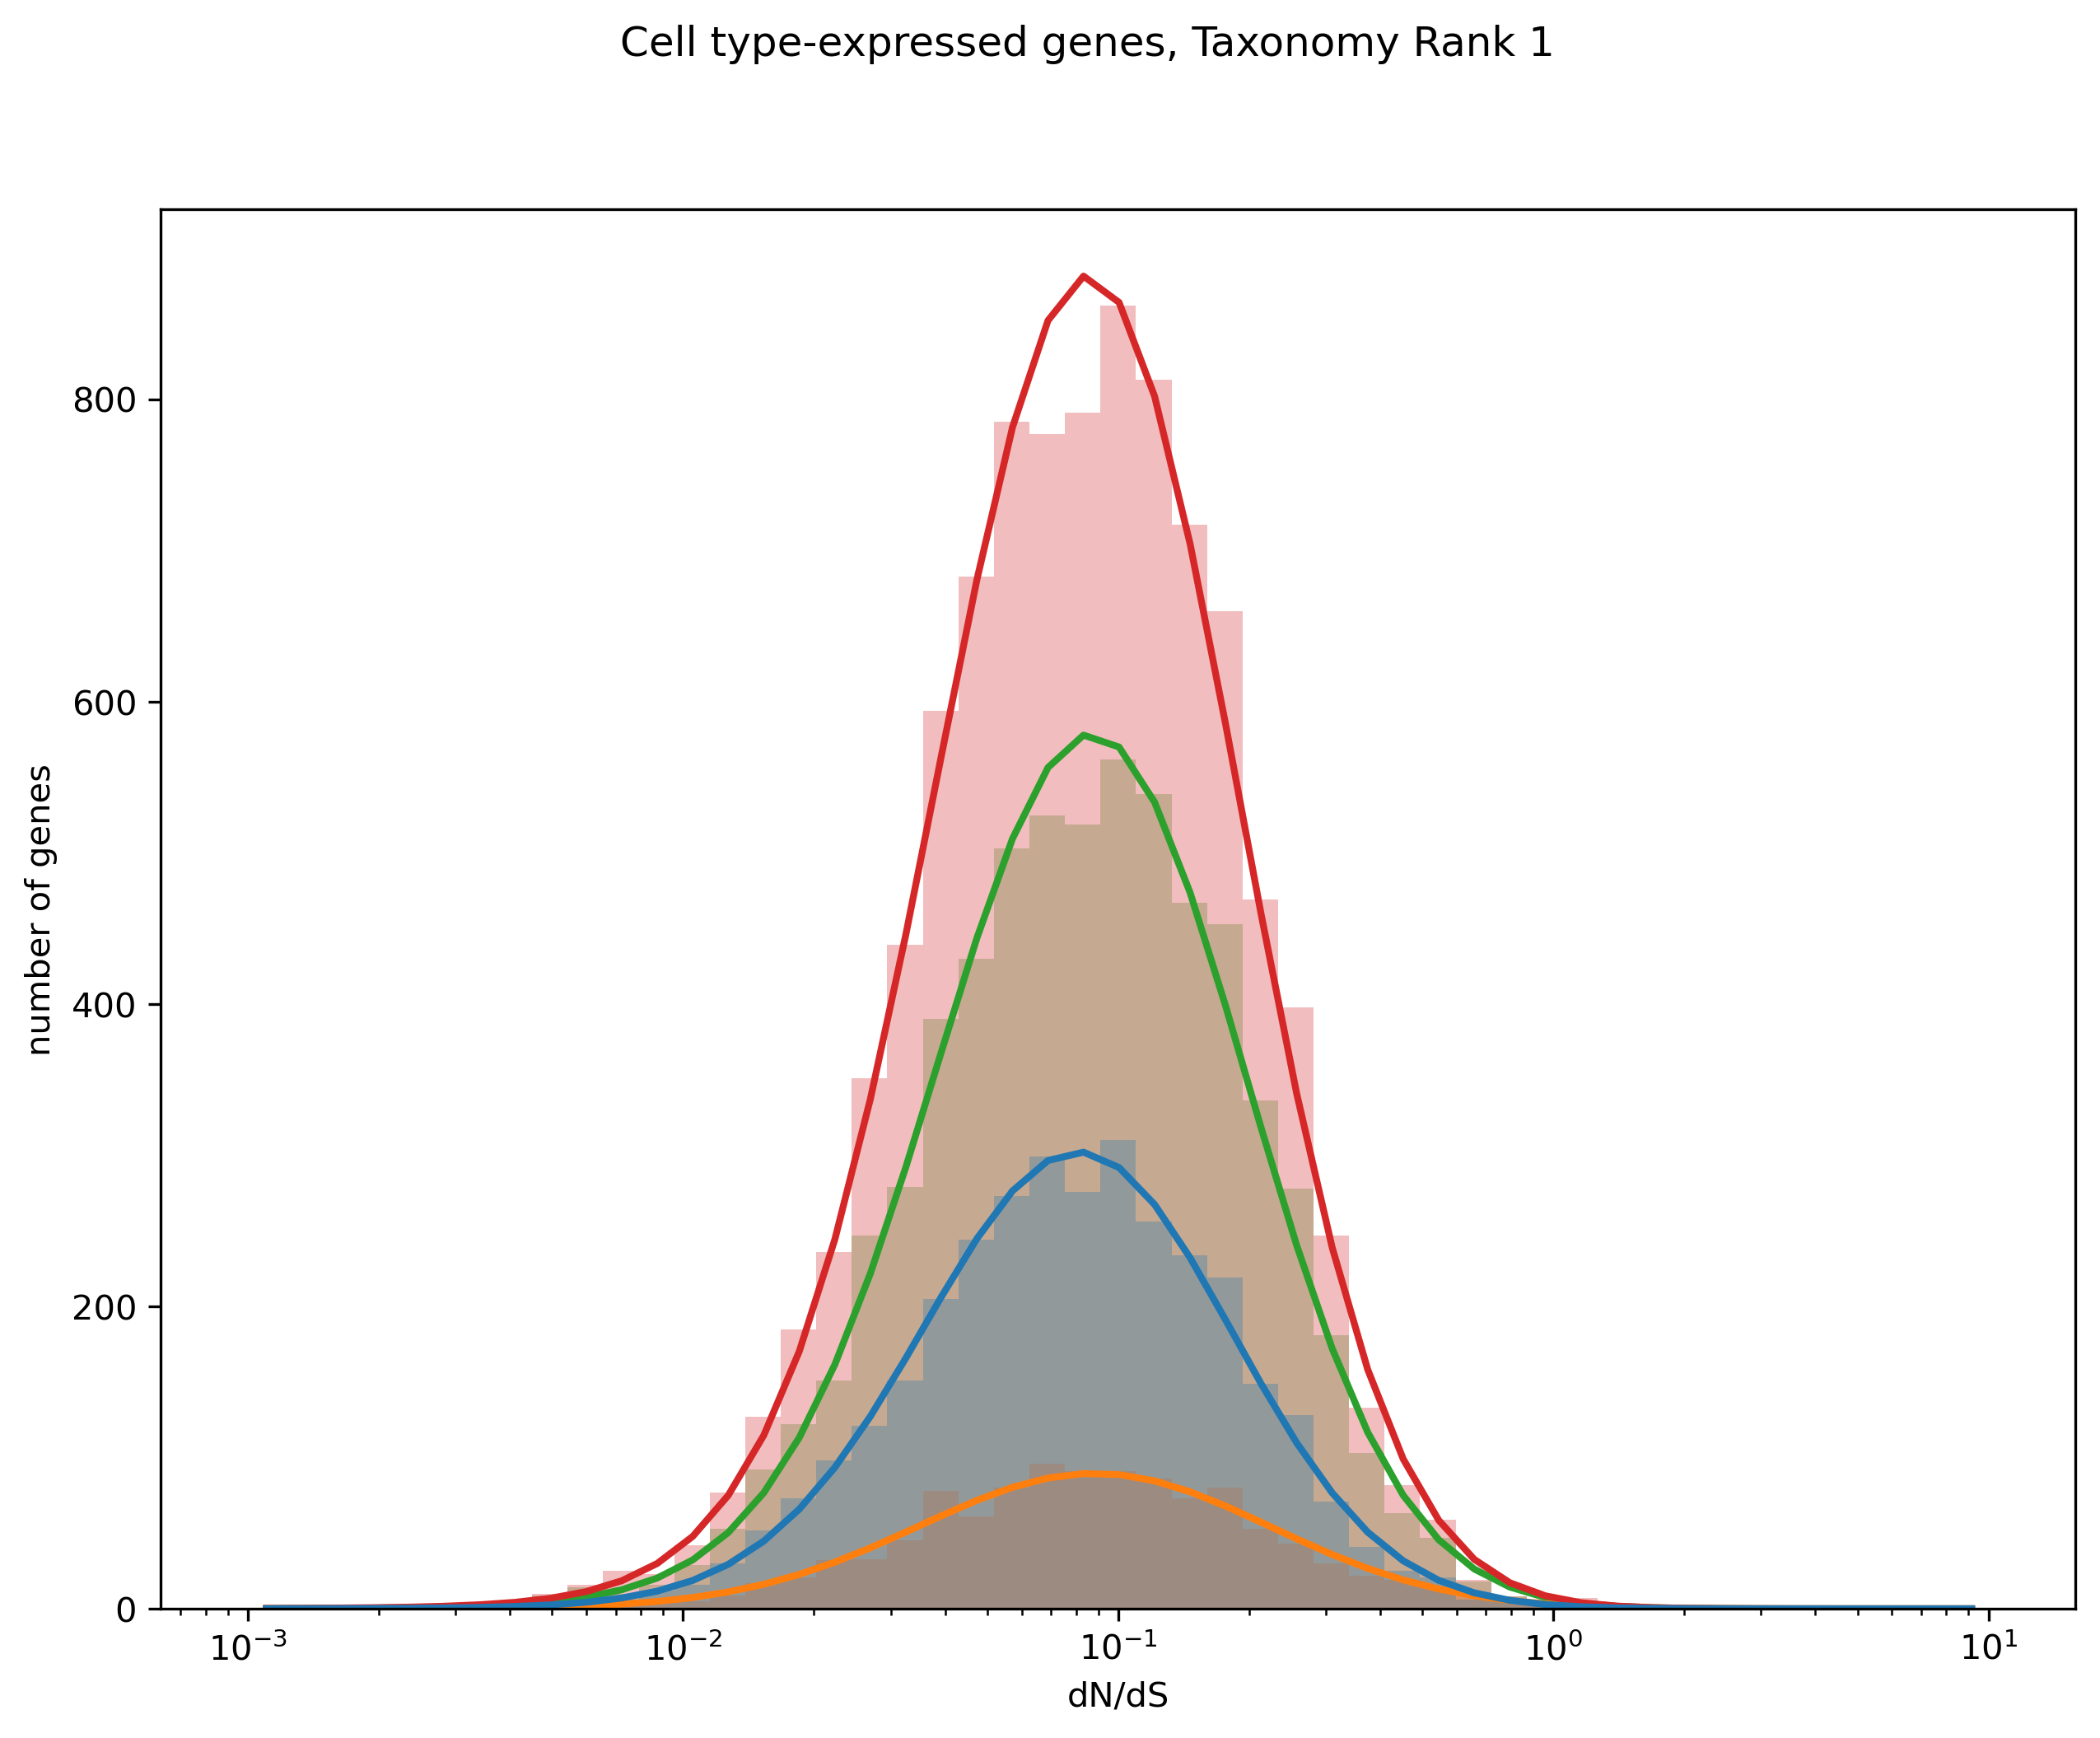

In [174]:
fig = plt.figure(figsize=(10,7.5))
fig.suptitle('Cell type-expressed genes, Taxonomy Rank 1')
grid = plt.GridSpec(nrows=1,ncols=1)
distr_plot = fig.add_subplot(grid[:,:])
bins=np.logspace(np.log10(0.001),np.log10(10), 50)
bins_cntr = (bins[1:] + bins[:-1]) / 2
color_dict={
    'Glia':'tab:green', 
    'Immune cells':'tab:orange', 
    'Neurons':'tab:red', 
    'Vascular cells':'tab:blue'
}
for celltype in TaxonomyRank1_list:
    arr = expressed_avg_dNdS_dict[celltype]['avg_dNdS']
    counts, bin_edges, ignored = distr_plot.hist(arr,bins,histtype='stepfilled',alpha=0.3,color=color_dict[celltype],label='dN/dS of '+celltype+'-specific genes (med={0:.3f})'.format(np.median(arr)))
    try:
        # calculate area of histograms (area under PDF should be 1)
        area_hist = ((bin_edges[1:] - bin_edges[:-1]) * counts).sum()
        shape, loc, scale = stats.lognorm.fit(arr)
        # pdf-values using cdf 
        fit_log_cntr_ = stats.lognorm.cdf(bins, shape, loc=loc, scale=scale)
        fit_log_cntr = np.diff(fit_log_cntr_)
        # plot fitted and scaled PDFs into histogram
        distr_plot.plot(bins_cntr, fit_log_cntr * counts.sum(),color=color_dict[celltype],linestyle='solid', 
                        label='lognormal fit of '+celltype+'-specific dN/dS distribution', linewidth=2)
    except ValueError:
        pass
distr_plot.set_xlabel(xlabel='dN/dS')
distr_plot.set_ylabel(ylabel='number of genes')
distr_plot.set_xscale('log')